This end-to-end data science project is executed as part of the requirements of the course *INSY-695 Advanced Topics in Information Systems* for the **McGill Master of Management Analytics** program. The contributors for this project, along with their github user names and roles are as follows:

1. **Nathan Murstein (NathanMurstein)** - Data Scientist
2. **Hisham Salem (HishamSalem)** - Data Analyst
3. **Dany Stefan (dany-stefan)** - Data Scientist
4. **Jeewon Kim (jeewonk)** - Data Scientist
5. **Diwei Zhu (JuniperZhuDiwei)** - Business Analyst
6. **Oleg Kartavtsev (oleg19989)** - Business Intelligence
7. **Uzair Ahmad (uzairahmadxy)** - Project Manager

# Project Description

Telecommunicaion industry has a huge presence in the economic world. It is estimated that the global telecom services was [valued at](https://www.grandviewresearch.com/industry-analysis/global-telecom-services-market)  **USD 1,657.7 billion** in 2020. One of the major problems Telcos (Telecommunicaion Companies) face is customer churn. According to [Profitwell](https://www.smartlook.com/blog/customer-churn-retention/), the average churn rate in telecom businesses is 22%.

## Objective

This project aims is to use machine learning techniques to remedy the problem of customer churn and provide measurable business value to the telecommunication companies. 

## Pain Points

- Churn leads to higher Customer Acquisition Costs & reduced revenue - acquiring new customers is more costly than keeping the existing ones.

- High churn rates are more likely to compound over time. 

## Business Value

- Increased revenue
- Higher customer satisfaction and loyalty
- Higher market share

## Methodology Overview

Our team focuses on predicting whether or not a customer is likely to churn, using **predictive modelling**. Using this information of churn likelihood, we can take *proactive steps*. One of the most effective methods in marketing, is sending promotions or coupons to customers. Since we cannot send coupons to everyone due to unsustainability of this strategy & high distribution costs, we pick specific customers to send coupons to. To achieve this we leverage the predictive information into an **optimization model**, which recommends a coupon distribution strategy to minimize the loss of revenue (opportunity cost) as a consequency of customer churn.

# Preliminary imports

Please note that the missing libraries need to be installed (pip install, conda install).

In [ ]:
#conda install pandas==1.2.5
#conda install -c conda-forge pandas-profiling=2.8.0
#conda install -c conda-forge boruta_py
#conda install -c conda-forge imbalanced-learn
#conda install -c conda-forge optuna
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= '0.20'
import numpy as np
import pandas as pd
import os
import warnings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import pandas_profiling
from pandas_profiling import ProfileReport
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble  import IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score,pairwise_distances,roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import linear_model
from catboost import CatBoostClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from numpy import argmax
import optuna
import seaborn as sns

In [2]:
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Data Extraction

In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [7]:
print(df['MultipleLines'].unique())
print(df['gender'].unique())
print(df['InternetService'].unique())
print(df['PaymentMethod'].unique())
print(df['Contract'].unique())

['No phone service' 'No' 'Yes']
['Female' 'Male']
['DSL' 'Fiber optic' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['Month-to-month' 'One year' 'Two year']


 # Data Pre-processing
 Contributor(s): @uzairxy
 
 Categorical Variables are encoded.

In [8]:
ore = ce.OrdinalEncoder(
    mapping=[
        {
            'col': 'MultipleLines',
            'mapping': {
                'No phone service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'gender',
            'mapping': {
                'Male': 0,
                'Female': 1
            }
        },
        {
            'col': 'Contract',
            'mapping': {
                'Month-to-month': 1,
                'One year': 2,
                'Two year': 3
            }
        },
        {
            'col': 'InternetService',
            'mapping': {
                'No': 0,
                'DSL': 1,
                'Fiber optic': 2
            }
        },
        {
            'col': 'OnlineSecurity',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'OnlineBackup',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'DeviceProtection',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'TechSupport',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'StreamingTV',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        },
        {
            'col': 'StreamingMovies',
            'mapping': {
                'No internet service': -1,
                'No': 1,
                'Yes': 2
            }
        }
    ]
)

In [9]:
df = ore.fit_transform(df)
df

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG       1              0     Yes         No       1   
1     5575-GNVDE       0              0      No         No      34   
2     3668-QPYBK       0              0      No         No       2   
3     7795-CFOCW       0              0      No         No      45   
4     9237-HQITU       1              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB       0              0     Yes        Yes      24   
7039  2234-XADUH       1              0     Yes        Yes      72   
7040  4801-JZAZL       1              0     Yes        Yes      11   
7041  8361-LTMKD       0              1     Yes         No       4   
7042  3186-AJIEK       0              0      No         No      66   

     PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0              No             -1                1               1  ...   
1             Yes              1                1               2  ...   
2             Yes              1                1               2  ...   
3              No             -1                1               2  ...   
4             Yes              1                2               1  ...   
...           ...            ...              ...             ...  ...   
7038          Yes              2                1               2  ...   
7039          Yes              2                2               1  ...   
7040           No             -1                1               2  ...   
7041          Yes              2                2               1  ...   
7042          Yes              1                2               2  ...   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    1            1            1                1         1   
1                    2            1            1                1         2   
2                    1            1            1                1         1   
3                    2            2            1                1         2   
4                    1            1            1                1         1   
...                ...          ...          ...              ...       ...   
7038                 2            2            2                2         2   
7039                 2            1            2                2         2   
7040                 1            1            1                1         1   
7041                 1            1            1                1         1   
7042                 2            2            2                2         3   

      PaperlessBilling              PaymentMethod MonthlyCharges  \
0                  Yes           Electronic check          29.85   
1                   No               Mailed check          56.95   
2                  Yes               Mailed check          53.85   
3                   No  Bank transfer (automatic)          42.30   
4                  Yes           Electronic check          70.70   
...                ...                        ...            ...   
7038               Yes               Mailed check          84.80   
7039               Yes    Credit card (automatic)         103.20   
7040               Yes           Electronic check          29.60   
7041               Yes               Mailed check          74.40   
7042               Yes  Bank transfer (automatic)         105.65   

      TotalCharges Churn  
0            29.85    No  
1           1889.5    No  
2           108.15   Yes  
3          1840.75    No  
4           151.65   Yes  
...            ...   ...  
7038        1990.5    No  
7039        7362.9    No  
7040        346.45    No  
7041         306.6   Yes  
7042        6844.5    No  

[7043 rows x 21 columns]

In [10]:
df = df.replace({'Yes': 1,'No': 0})
df = pd.get_dummies(df, columns=['PaymentMethod'])

In [11]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [12]:
column_names = [
    'Churn',
    'gender', 
    'SeniorCitizen', 
    'Partner', 
    'Dependents', 
    'tenure',
    'PhoneService', 
    'MultipleLines', 
    'InternetService', 
    'OnlineSecurity',
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV',
    'StreamingMovies', 
    'Contract', 
    'PaperlessBilling', 
    'PaymentMethod_Bank transfer (automatic)',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 
    'PaymentMethod_Mailed check', 
    'MonthlyCharges',
    'TotalCharges']
df = df.reindex(columns=column_names)

In [13]:
df.to_csv('Churn_Processed.csv')

# Preliminary Data Exploration
Contributor(s): @uzairxy

Looking at nulls across columns, multi-collinearity and variable distributions.

Saving figure attribute_histogram_plots


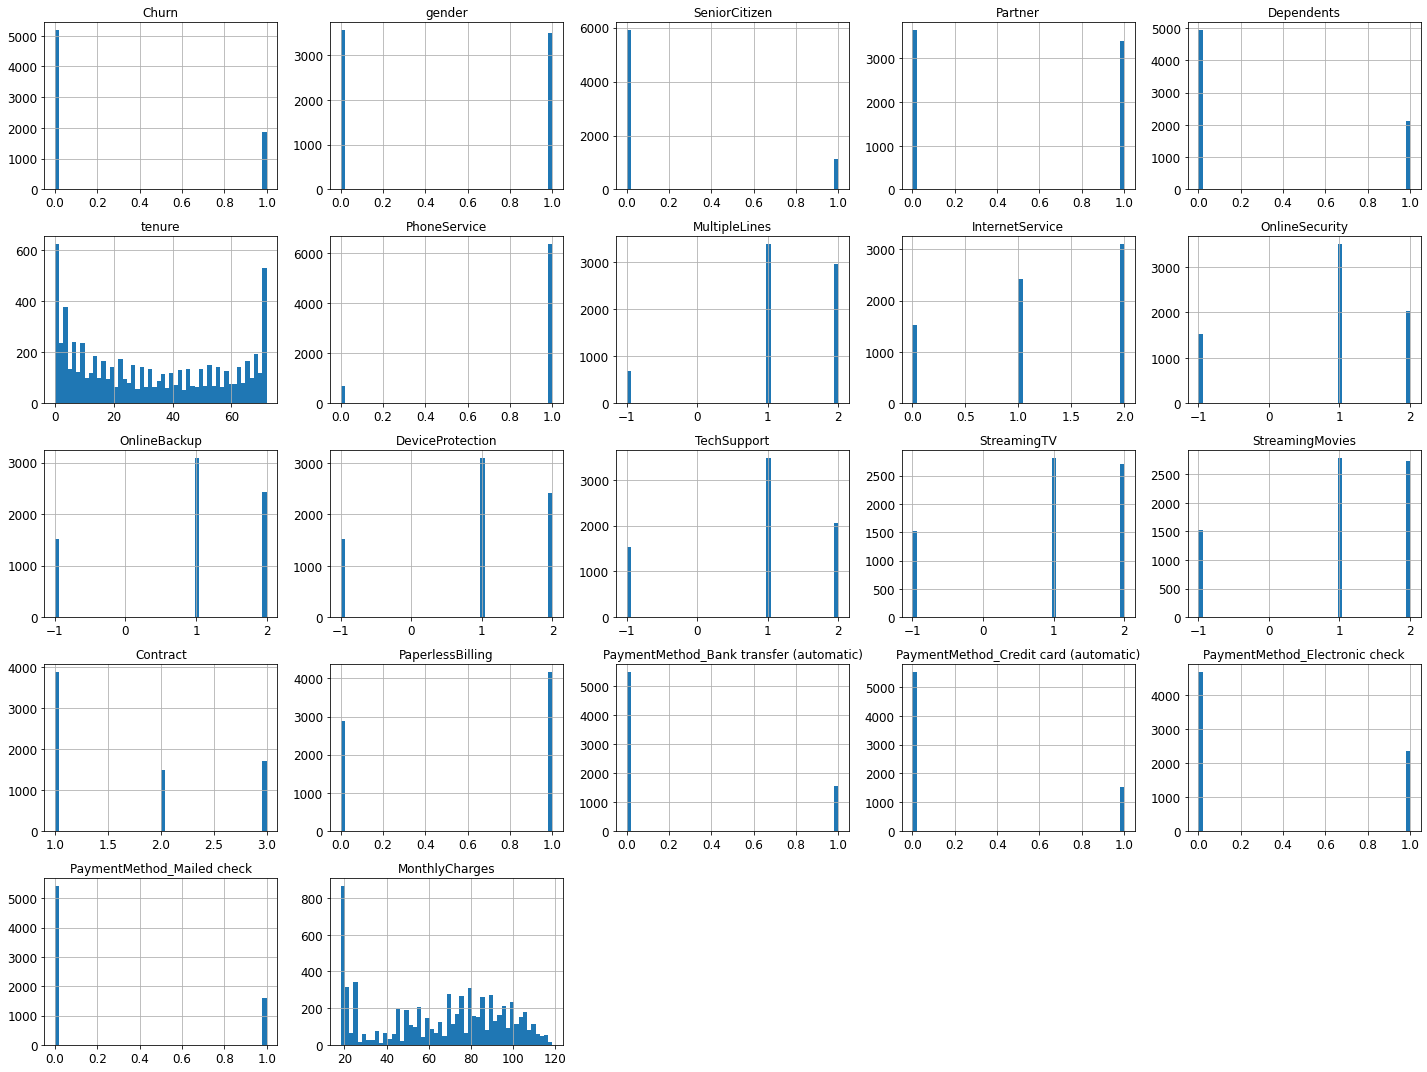

In [14]:
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [15]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_notebook_iframe()
profile.to_file('Pandas Profiling Report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df

Churn  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0         0       1              0        1           0       1             0   
1         0       0              0        0           0      34             1   
2         1       0              0        0           0       2             1   
3         0       0              0        0           0      45             0   
4         1       1              0        0           0       2             1   
...     ...     ...            ...      ...         ...     ...           ...   
7038      0       0              0        1           1      24             1   
7039      0       1              0        1           1      72             1   
7040      0       1              0        1           1      11             0   
7041      1       0              1        1           0       4             1   
7042      0       0              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  ...  StreamingTV  \
0                -1                1               1  ...            1   
1                 1                1               2  ...            1   
2                 1                1               2  ...            1   
3                -1                1               2  ...            1   
4                 1                2               1  ...            1   
...             ...              ...             ...  ...          ...   
7038              2                1               2  ...            2   
7039              2                2               1  ...            2   
7040             -1                1               2  ...            1   
7041              2                2               1  ...            1   
7042              1                2               2  ...            2   

      StreamingMovies  Contract  PaperlessBilling  \
0                   1         1                 1   
1                   1         2                 0   
2                   1         1                 1   
3                   1         2                 0   
4                   1         1                 1   
...               ...       ...               ...   
7038                2         2                 1   
7039                2         2                 1   
7040                1         1                 1   
7041                1         1                 1   
7042                2         3                 1   

      PaymentMethod_Bank transfer (automatic)  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
7038                                        0   
7039                                        0   
7040                                        0   
7041                                        0   
7042                                        1   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                         0                               1   
1                                         0                               0   
2                                         0                               0   
3                                         0                               0   
4                                         0                               1   
...                                     ...                             ...   
7038                                      0                               0   
7039                                      1                               0   
7040                                      0                               1   
7041                                      0                               0   
7042                                      0      

In [17]:
df[df.isnull().any(axis=1)]

Churn  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
488       0       1              0        1           1       0             0   
753       0       0              0        0           1       0             1   
936       0       1              0        1           1       0             1   
1082      0       0              0        1           1       0             1   
1340      0       1              0        1           1       0             0   
3331      0       0              0        1           1       0             1   
3826      0       0              0        1           1       0             1   
4380      0       1              0        1           1       0             1   
5218      0       0              0        1           1       0             1   
6670      0       1              0        1           1       0             1   
6754      0       0              0        0           1       0             1   

      MultipleLines  InternetService  OnlineSecurity  ...  StreamingTV  \
488              -1                1               2  ...            2   
753               1                0              -1  ...           -1   
936               1                1               2  ...            2   
1082              2                0              -1  ...           -1   
1340             -1                1               2  ...            2   
3331              1                0              -1  ...           -1   
3826              2                0              -1  ...           -1   
4380              1                0              -1  ...           -1   
5218              1                0              -1  ...           -1   
6670              2                1               1  ...            2   
6754              2                1               2  ...            1   

      StreamingMovies  Contract  PaperlessBilling  \
488                 1         3                 1   
753                -1         3                 0   
936                 2         3                 0   
1082               -1         3                 0   
1340                1         3                 0   
3331               -1         3                 0   
3826               -1         3                 0   
4380               -1         3                 0   
5218               -1         2                 1   
6670                1         3                 0   
6754                1         3                 1   

      PaymentMethod_Bank transfer (automatic)  \
488                                         1   
753                                         0   
936                                         0   
1082                                        0   
1340                                        0   
3331                                        0   
3826                                        0   
4380                                        0   
5218                                        0   
6670                                        0   
6754                                        1   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
488                                       0                               0   
753                                       0                               0   
936                                       0                               0   
1082                                      0                               0   
1340                                      1                               0   
3331                                      0                               0   
3826                                      0                               0   
4380                                      0                               0   
5218                                      0                               0   
6670                                      0                               0   
6754                                      0      

In [18]:
df = df.dropna()
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Churn, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod_Bank transfer (automatic), PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, MonthlyCharges, TotalCharges]
Index: []

[0 rows x 23 columns]

In [19]:
df.to_csv('Churn_Preprocessed.csv')

# Feature Selection
Contributor(s): @uzairxy, @dany-stefan

## Feature Importance using Boruta

Boruta is a popular method of feature selection, with it's primary advantages to handle regresssion/classification tasks. It can handle multi-variable relationships and interactions between variables.

For our dataset, the most important features are *'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges*.

In [20]:
feat_selector = BorutaPy(
    verbose=2,
    estimator=RandomForestClassifier(),
    max_iter=20
)

In [21]:
BorutaY = df.iloc[:, 0:1]
BorutaY = BorutaY.to_numpy(dtype=None, copy=False) 

BorutaX = df.iloc[:, 1:23]
BorutaX_np = BorutaX.to_numpy(dtype=None, copy=False) 

In [22]:
feat_selector.fit(BorutaX_np, BorutaY)

C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	22
Rejected: 	0


C:\Users\hisha\Anaconda3\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	8 / 20
Confirmed: 	4
Tentative: 	0
Rejected: 	18


BorutaPy finished running.

Iteration: 	9 / 20
Confirmed: 	4
Tentative: 	0
Rejected: 	18


BorutaPy(estimator=RandomForestClassifier(n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x1E55CD4C488),
         max_iter=20, random_state=RandomState(MT19937) at 0x1E55CD4C488,
         verbose=2)

In [23]:
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", 
            BorutaX.columns[i],
            " - Ranking: ", 
            feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
            BorutaX.columns[i], 
            " - Ranking: ", 
            feat_selector.ranking_[i])

Doesn't pass the test:  gender  - Ranking:  12
Doesn't pass the test:  SeniorCitizen  - Ranking:  14
Doesn't pass the test:  Partner  - Ranking:  13
Doesn't pass the test:  Dependents  - Ranking:  15
Passes the test:  tenure  - Ranking:  1
Doesn't pass the test:  PhoneService  - Ranking:  19
Doesn't pass the test:  MultipleLines  - Ranking:  11
Doesn't pass the test:  InternetService  - Ranking:  2
Doesn't pass the test:  OnlineSecurity  - Ranking:  4
Doesn't pass the test:  OnlineBackup  - Ranking:  6
Doesn't pass the test:  DeviceProtection  - Ranking:  7
Doesn't pass the test:  TechSupport  - Ranking:  5
Doesn't pass the test:  StreamingTV  - Ranking:  8
Doesn't pass the test:  StreamingMovies  - Ranking:  8
Passes the test:  Contract  - Ranking:  1
Doesn't pass the test:  PaperlessBilling  - Ranking:  10
Doesn't pass the test:  PaymentMethod_Bank transfer (automatic)  - Ranking:  17
Doesn't pass the test:  PaymentMethod_Credit card (automatic)  - Ranking:  16
Doesn't pass the test:

In [24]:
accepted = BorutaX.columns[feat_selector.support_].to_list()
print('Accepted features:', accepted)

undecided = BorutaX.columns[feat_selector.support_weak_].to_list()
print('Undecided features', undecided)

selected_features = accepted + undecided # include undecided to be safe
selected_features

Accepted features: ['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']
Undecided features []


['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']

In [25]:
df_selected = df[['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges', 'Churn']]
sum(df_selected['Churn'])/len(df_selected)

0.26578498293515357

## Correlation Analysis
Contributor(s): @HishamSalem

Correlation Analysis with VIF helps with identifying features that are strongly correlated. We want to reduce the excess feature as this would improve training time for models without significant loss in information from the predictors.

We find that the Total Charges and Monthly Charges are highly correlated, which makes sense as the Total Charges should be based on the Monthly Charges for a customer.

In [26]:
VIFAddition = '+'.join(df_selected.columns)
VIFAddition
formula = "Churn ~ {X_vars}"
full_formula = formula.format(X_vars=VIFAddition)
print(full_formula)

Churn ~ tenure+Contract+MonthlyCharges+TotalCharges+Churn


In [27]:
def run_vif(formula):
    y, X = dmatrices(formula, data=df_selected, return_type='dataframe')    
    vif = pd.DataFrame()
    vif['variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)
    print('\n')


run_vif(full_formula)
run_vif('Churn ~ tenure+Contract+MonthlyCharges')

         variable        VIF
0       Intercept  20.901490
1          tenure   6.871696
2        Contract   2.120215
3  MonthlyCharges   3.636810
4    TotalCharges   9.719414
5           Churn   1.313938


         variable        VIF
0       Intercept  11.628501
1          tenure   2.203140
2        Contract   2.079884
3  MonthlyCharges   1.200522




In [28]:
df_selected = df_selected.drop(['TotalCharges'],axis=1)
df_selected

tenure  Contract  MonthlyCharges  Churn
0          1         1           29.85      0
1         34         2           56.95      0
2          2         1           53.85      1
3         45         2           42.30      0
4          2         1           70.70      1
...      ...       ...             ...    ...
7038      24         2           84.80      0
7039      72         2          103.20      0
7040      11         1           29.60      0
7041       4         1           74.40      1
7042      66         3          105.65      0

[7032 rows x 4 columns]

## Train/Test Split

In [29]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_selected, df_selected['Churn']):
    print('train:', train_index, 'test:', test_index)
    strat_train_set =df_selected.iloc[train_index]
    strat_test_set = df_selected.iloc[test_index]

train: [1408 6992 3349 ... 4128 4242 1500] test: [ 971  618 4282 ... 2745 4424 2086]


# Analyze Outliers
Contributor(s): @HishamSalem

Using isolation forest in order to detect outliers. By removing outliers we will be able to get a model that generalizes better.

In [30]:
AnomalyX = strat_train_set.iloc[:, 1:23]
AnomalyX_np = AnomalyX.to_numpy(dtype= None, copy= False) 

In [31]:
iforest = IsolationForest(max_samples='auto',
                          n_estimators=50, 
                          contamination=0.02,
                          max_features=1.0)

iforest_= iforest.fit(AnomalyX_np)

In [32]:
strat_train_set['scores'] = iforest_.decision_function(AnomalyX_np)
strat_train_set['anomaly'] = iforest_.predict(AnomalyX_np)

C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
strat_train_set

tenure  Contract  MonthlyCharges  Churn    scores  anomaly
1413      65         3           94.55      0  0.121880        1
7003      26         1           35.75      0  0.092828        1
3355      68         3           90.20      0  0.135553        1
4494       3         1           84.30      0  0.182705        1
3541      49         1           40.65      0  0.104112        1
...      ...       ...             ...    ...       ...      ...
3451      65         2           70.95      0  0.158341        1
5123      15         1           75.30      1  0.173797        1
4135      36         3           92.90      0  0.122906        1
4249      10         2           65.90      0  0.143376        1
1505       1         1           74.70      1  0.178802        1

[5625 rows x 6 columns]

In [34]:
strat_train_set = strat_train_set[strat_train_set['anomaly'] != -1]

In [35]:
strat_train_set

tenure  Contract  MonthlyCharges  Churn    scores  anomaly
1413      65         3           94.55      0  0.121880        1
7003      26         1           35.75      0  0.092828        1
3355      68         3           90.20      0  0.135553        1
4494       3         1           84.30      0  0.182705        1
3541      49         1           40.65      0  0.104112        1
...      ...       ...             ...    ...       ...      ...
3451      65         2           70.95      0  0.158341        1
5123      15         1           75.30      1  0.173797        1
4135      36         3           92.90      0  0.122906        1
4249      10         2           65.90      0  0.143376        1
1505       1         1           74.70      1  0.178802        1

[5512 rows x 6 columns]

In [36]:
strat_train_set = strat_train_set.drop(['scores','anomaly'], axis=1)

# Sampling Training Data
Contributor(s): HishamSalem

We try over-sampling and under-sampling methods as we have a significant class imbalance of *3:1*. Our predictive results are better with over-sampling the minority class.

## X/Y Split

In [37]:
strat_train_set_y = strat_train_set['Churn'].copy()
strat_train_set_x = strat_train_set.drop(['Churn'], axis=1)

In [38]:
sum(strat_train_set_y)/len(strat_train_set_y)

0.25072568940493467

## Oversampler

In [39]:
oversample = SMOTE()

## Undersampler

In [40]:
undersample = NearMiss(version=2, n_neighbors=3)

## Modeling
Models: LightGBM, LogisticRegression,MLP,Random Forest, XGBoost, Gradient Boosting, SVC,Naive Bayes

In [41]:
models = {
    'lr': linear_model.LogisticRegression(),
    'xgb': XGBClassifier(probability=True, scale_pos_weight=100, use_label_encoder=False),
    'rf': RandomForestClassifier(random_state=1),
    'mlp': MLPClassifier(random_state=1, max_iter=300),
    'naive_bayes': GaussianNB(),
    'gb': GradientBoostingClassifier(),
    'svc': SVC(kernel='sigmoid', C=1, random_state=1, probability=True),
    'lightGBM': lgb.LGBMClassifier(scale_pos_weight=25)
}

strat_test_set_y = strat_test_set['Churn'].copy()
strat_test_set_x = strat_test_set.drop(['Churn'], axis=1)

## Stratified k-Fold Cross-Validation Due to Imbalanced Dataset

In [42]:
strat_train_set_x.reset_index(drop=True, inplace=True)
strat_train_set_y.reset_index(drop=True, inplace=True)

In [43]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(strat_train_set_x)

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

## Oversample Model and Under Sample Comparison

Using smote and 5 fold validation we essentially see how our model behaves.

In [45]:
def aggregate_results(modelindex, ResultT):
    Accuracy = []
    Precision = []
    Recall = []
    F1Score = []
    
    for i in set(modelindex):
        Accur = sum(ResultT[i].iloc[0])/5
        Preci = sum(ResultT[i].iloc[1])/5
        Recalls = sum(ResultT[i].iloc[2])/5
        F1Scores = sum(ResultT[i].iloc[3])/5
        Accuracy.append(Accur)
        Precision.append(Preci)
        Recall.append(Recalls)
        F1Score.append(F1Scores)

    ModelComparison = pd.DataFrame(set(modelindex))
    ModelComparison['Accuracy'] = Accuracy
    ModelComparison['Precision'] = Precision
    ModelComparison['Recall'] = Recall
    ModelComparison['F1Score'] = F1Score
    
    return ModelComparison
    

In [46]:
sample_x_over, sample_y_over = oversample.fit_resample(strat_train_set_x, strat_train_set_y)
sample_x_under, sample_y_under = undersample.fit_resample(strat_train_set_x, strat_train_set_y)

def run_all_models_with_5_split(sample_x, sample_y):
    modelindex = []
    iterationindex = []
    acc_score = []
    recall = []
    prec = []
    fscore = []

    for model in models:
        iteration = 1
        print(model)
        key = model
        model = models[model]
        # skf has 5 splits (defined earlier)
        for train_index, validation_index in skf.split(sample_x, sample_y):
            iterationindex.append(iteration)
            modelindex.append(key)
            # Split
            X_train, X_validation = sample_x.iloc[train_index,:], sample_x.iloc[validation_index,:]
            y_train, y_validation = sample_y[train_index], sample_y[validation_index]
            model.fit(X_train, y_train)
            # Prediction
            pred_values = model.predict(X_validation)
            acc = accuracy_score(y_validation, pred_values)
            rs = metrics.recall_score(y_validation, pred_values)
            ps = metrics.precision_score(y_validation, pred_values)
            f1s = metrics.f1_score(y_validation, pred_values)
            acc_score.append(acc)
            recall.append(rs)
            prec.append(ps)
            fscore.append(f1s)
            iteration += 1
    
    arrays = [np.array(modelindex),np.array(iterationindex)]
    Result = pd.DataFrame(index=arrays)
    Result['Accuracy'] = acc_score
    Result['Precision'] = prec
    Result['Recall'] = recall
    Result['F1 Score'] = fscore

    Result_T = Result.transpose()
    Model_Comparison = aggregate_results(modelindex, Result_T)

    return Result_T, Model_Comparison

over_results, over_comparison = run_all_models_with_5_split(sample_x_over, sample_y_over)
under_results, under_comparison = run_all_models_with_5_split(sample_x_under, sample_y_under)

lr
xgb
[23:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistaken

In [47]:
over_results

lr                                               xgb  \
                  1         2         3         4         5         1   
Accuracy   0.824455  0.788136  0.806295  0.785714  0.783293  0.807506   
Precision  0.770161  0.746888  0.745155  0.729572  0.741736  0.727599   
Recall     0.924939  0.871671  0.930993  0.907990  0.869249  0.983051   
F1 Score   0.840484  0.804469  0.827772  0.809061  0.800446  0.836251   

                                                   ...       svc            \
                  2         3         4         5  ...         1         2   
Accuracy   0.793584  0.786925  0.782688  0.785109  ...  0.583535  0.567191   
Precision  0.713656  0.706446  0.700774  0.705318  ...  0.584146  0.566787   
Recall     0.980630  0.981840  0.986683  0.979419  ...  0.579903  0.570218   
F1 Score   0.826109  0.821682  0.819507  0.820071  ...  0.582017  0.568497   

                                         lightGBM                      \
                  3         4         5         1         2         3   
Accuracy   0.556295  0.564165  0.605327  0.805085  0.779661  0.779056   
Precision  0.556777  0.563702  0.608750  0.721053  0.698113  0.696170   
Recall     0.552058  0.567797  0.589588  0.995157  0.985472  0.990315   
F1 Score   0.554407  0.565742  0.599016  0.836216  0.817269  0.817591   

                               
                  4         5  
Accuracy   0.769976  0.776634  
Precision  0.686455  0.694138  
Recall     0.993947  0.989104  
F1 Score   0.812067  0.815776  

[4 rows x 40 columns]

In [48]:
under_results

lr                                               xgb  \
                  1         2         3         4         5         1   
Accuracy   0.670886  0.674503  0.661844  0.716094  0.672101  0.752260   
Precision  0.635838  0.632597  0.630814  0.665746  0.629428  0.689373   
Recall     0.797101  0.829710  0.783394  0.870036  0.836957  0.916667   
F1 Score   0.707395  0.717868  0.698873  0.754304  0.718507  0.786936   

                                                   ...       svc            \
                  2         3         4         5  ...         1         2   
Accuracy   0.723327  0.739602  0.743219  0.746377  ...  0.596745  0.613020   
Precision  0.656489  0.667506  0.681941  0.669154  ...  0.608163  0.607639   
Recall     0.934783  0.956679  0.913357  0.974638  ...  0.539855  0.634058   
F1 Score   0.771300  0.786350  0.780864  0.793510  ...  0.571977  0.620567   

                                         lightGBM                      \
                  3         4         5         1         2         3   
Accuracy   0.603978  0.645570  0.601449  0.746835  0.721519  0.739602   
Precision  0.600000  0.653992  0.600000  0.671717  0.648780  0.664198   
Recall     0.628159  0.620939  0.608696  0.963768  0.963768  0.971119   
F1 Score   0.613757  0.637037  0.604317  0.791667  0.775510  0.788856   

                               
                  4         5  
Accuracy   0.746835  0.717391  
Precision  0.677003  0.643541  
Recall     0.945848  0.974638  
F1 Score   0.789157  0.775216  

[4 rows x 40 columns]

On the balanced the dataset we can see the performance of our models. According to this we cannot determine which method is superior objectively.

In [49]:
over_comparison

0  Accuracy  Precision    Recall   F1Score
0  naive_bayes  0.773608   0.700948  0.954722  0.808359
1          mlp  0.784746   0.763662  0.838015  0.791452
2           gb  0.807869   0.765488  0.887651  0.821981
3           lr  0.797579   0.746702  0.900969  0.816447
4          svc  0.575303   0.576032  0.571913  0.573936
5           rf  0.822760   0.810742  0.842373  0.826166
6          xgb  0.791162   0.710759  0.982324  0.824724
7     lightGBM  0.782082   0.699186  0.990799  0.819784

In [50]:
under_comparison

0  Accuracy  Precision    Recall   F1Score
0  naive_bayes  0.688853   0.623999  0.950787  0.753445
1          mlp  0.768445   0.831456  0.680014  0.742383
2           gb  0.816566   0.837837  0.787278  0.811205
3           lr  0.679086   0.638884  0.823440  0.719389
4          svc  0.612152   0.613959  0.606341  0.609531
5           rf  0.786895   0.799839  0.766285  0.782379
6          xgb  0.740957   0.672893  0.939225  0.783792
7     lightGBM  0.734437   0.661048  0.963828  0.784081

In [51]:
sample_x_over, sample_y_over = oversample.fit_resample(strat_train_set_x,strat_train_set_y)
sample_x_under, sample_y_under = undersample.fit_resample(strat_train_set_x,strat_train_set_y)

def run_all_models_with_true_neg_analy(sample_x, sample_y, strat_test_set_x, strat_test_set_y):
    modelindex = []
    iterationindex = []
    acc_score = []
    recall = []
    prec = []
    fscore = []
    TN = []
    FN = []
    TP = []
    FP = []

    for model in models:
        modelindex.append(model)
        model = models[model]
        model.fit(sample_x, sample_y)
        pred_values = model.predict(strat_test_set_x)
        acc = accuracy_score(strat_test_set_y, pred_values)
        rs = metrics.recall_score(strat_test_set_y, pred_values)
        ps = metrics.precision_score(strat_test_set_y, pred_values)  
        f1s = metrics.f1_score(strat_test_set_y, pred_values)
        cm = confusion_matrix(strat_test_set_y, pred_values)
        
        tn = cm[0][0]
        fn = cm[1][0]
        tp = cm[1][1]
        fp = cm[0][1] 
        
        acc_score.append(acc)
        recall.append(rs)
        prec.append(ps)
        fscore.append(f1s)    
        TN.append(tn)
        FN.append(fn)
        TP.append(tp)    
        FP.append(fp)

        Result = pd.DataFrame(index=modelindex)
        Result['Accuracy'] = acc_score
        Result['Precision'] = prec
        Result['Recall'] = recall
        Result['F1Score'] = fscore
        Result['True Negative'] = TN
        Result['False Negative'] = FN
        Result['True Positive'] = TP
        Result['False Positive'] = FP
    
    return Result

over_result_confusion = run_all_models_with_true_neg_analy(sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)
under_result_confusion = run_all_models_with_true_neg_analy(sample_x_under, sample_y_under, strat_test_set_x, strat_test_set_y)

[23:58:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:58:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly pass

Running the model approaches on under sampling and oversampling and we can see that over sampling is superior. 

In [52]:
over_result_confusion.sort_values('True Positive',ascending=False)

Accuracy  Precision    Recall   F1Score  True Negative  \
lightGBM     0.634684   0.414634  0.909091  0.569514            553   
xgb          0.665245   0.435591  0.877005  0.582076            608   
naive_bayes  0.648188   0.421326  0.866310  0.566929            588   
lr           0.712864   0.476636  0.818182  0.602362            697   
mlp          0.712864   0.476038  0.796791  0.596000            705   
gb           0.742715   0.510490  0.780749  0.617336            753   
rf           0.734186   0.500000  0.577540  0.535980            817   
svc          0.589197   0.337061  0.564171  0.422000            618   

             False Negative  True Positive  False Positive  
lightGBM                 34            340             480  
xgb                      46            328             425  
naive_bayes              50            324             445  
lr                       68            306             336  
mlp                      76            298             328  
gb                       82            292             280  
rf                      158            216             216  
svc                     163            211             415

In [53]:
under_result_confusion.sort_values('True Positive',ascending=False)

Accuracy  Precision    Recall   F1Score  True Negative  \
lightGBM     0.466951   0.323640  0.922460  0.479167            312   
xgb          0.475480   0.326996  0.919786  0.482468            325   
naive_bayes  0.647477   0.420779  0.866310  0.566434            587   
lr           0.739161   0.505983  0.791444  0.617310            744   
mlp          0.534471   0.333333  0.751337  0.461791            471   
rf           0.604833   0.373961  0.721925  0.492701            581   
gb           0.589197   0.362162  0.716578  0.481149            561   
svc          0.586354   0.339506  0.588235  0.430528            605   

             False Negative  True Positive  False Positive  
lightGBM                 29            345             721  
xgb                      30            344             708  
naive_bayes              50            324             446  
lr                       78            296             289  
mlp                      93            281             562  
rf                      104            270             452  
gb                      106            268             472  
svc                     154            220             428

## Plots  
Based on these plots we can see that oversampling is the better method for our predictive modelling. We can also plot the most optimal parameters decision threshold that best maximzies the f1 score. Since a base 0.5 decision threshold is not always optimal.   

In [54]:
sample_x_over, sample_y_over = oversample.fit_resample(strat_train_set_x, strat_train_set_y)
sample_x_under, sample_y_under = undersample.fit_resample(strat_train_set_x, strat_train_set_y)

[23:59:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:59:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Saving figure roc_curves_for_oversample
[23:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language b

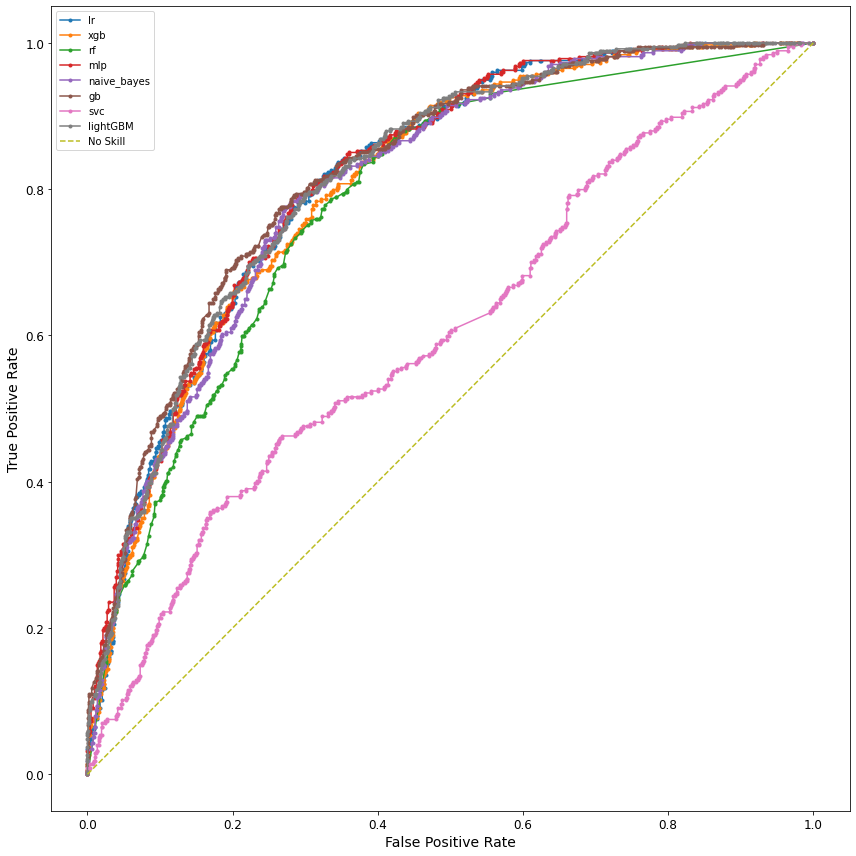

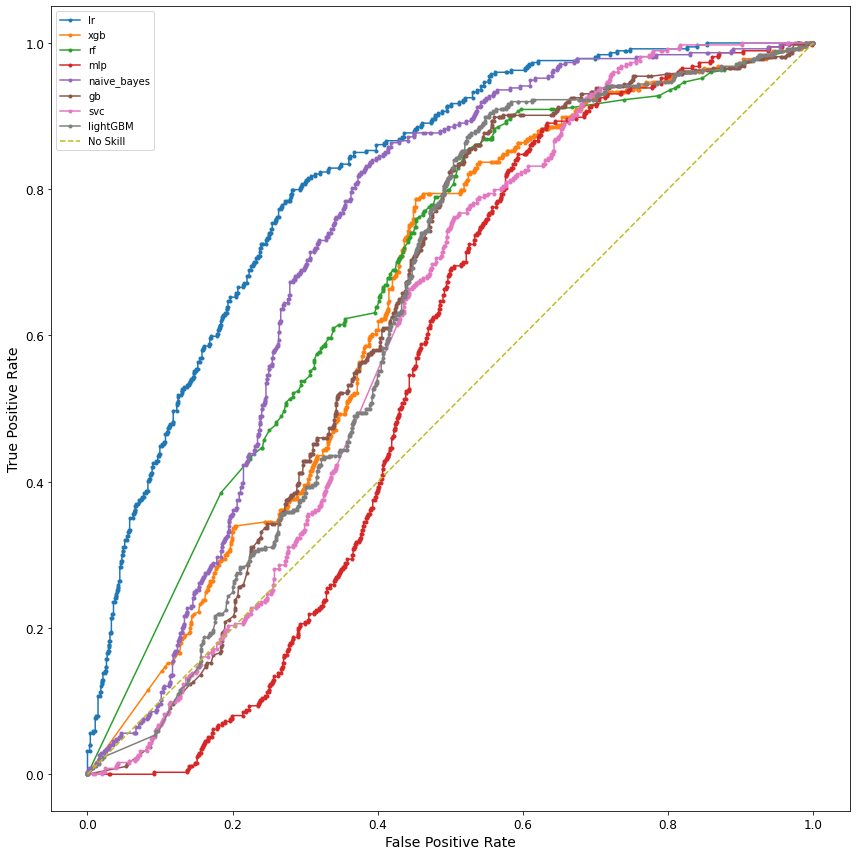

In [55]:
from matplotlib import pyplot

def plot_roc_curves(title, sample_x, sample_y, strat_test_set_x, strat_test_set_y):
    pyplot.figure(figsize=(12,12))
    for model in models:
        key = model
        model = models[model]
        model.fit(sample_x, sample_y)
        y_scores = model.predict_proba(strat_test_set_x)
        # Keep probabilities for the positive outcome only
        y_scores = y_scores[:, 1]
        # Calculate roc curves
        fpr, tpr, thresholds = roc_curve(strat_test_set_y, y_scores)
        # Plot the roc curve for the model
        pyplot.plot(fpr, tpr, marker='.', label='{}'.format(key))
    
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    save_fig(title)
    

plot_roc_curves('roc_curves_for_oversample', sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)
plot_roc_curves('roc_curves_for_undersample', sample_x_under, sample_y_under, strat_test_set_x, strat_test_set_y)
        

Saving figure precision_recall_for_oversample
[23:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_overs

C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Saving figure precision_recall_for_undersample
Saving figure precision_recall_for_undersample
Saving figure precision_recall_for_undersample


C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Saving figure precision_recall_for_undersample


C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Saving figure precision_recall_for_undersample


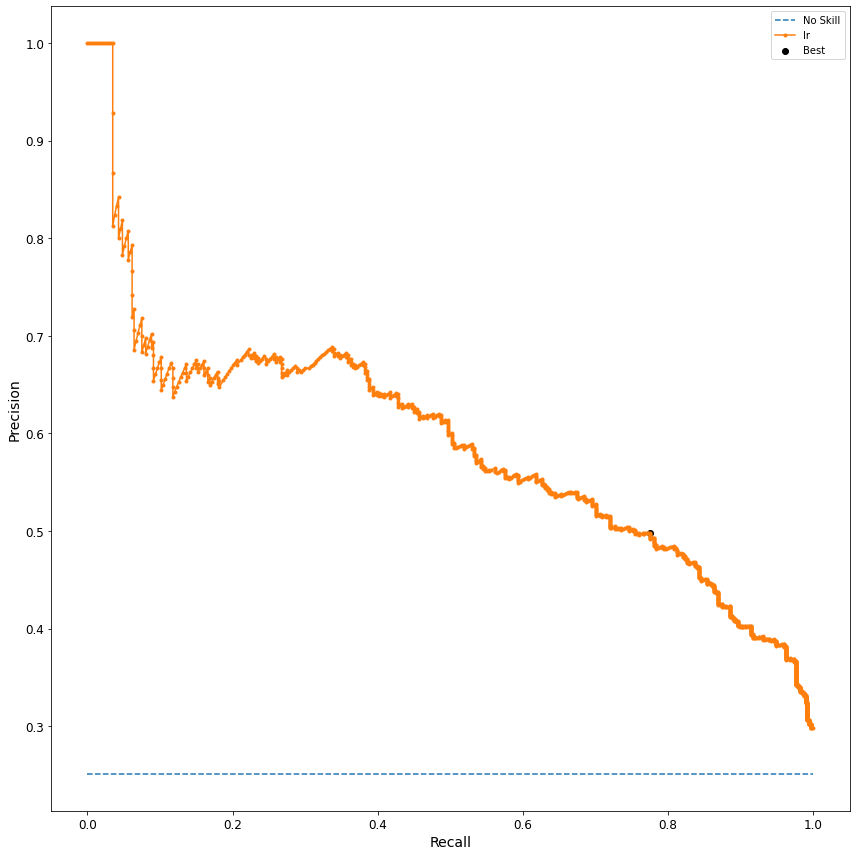

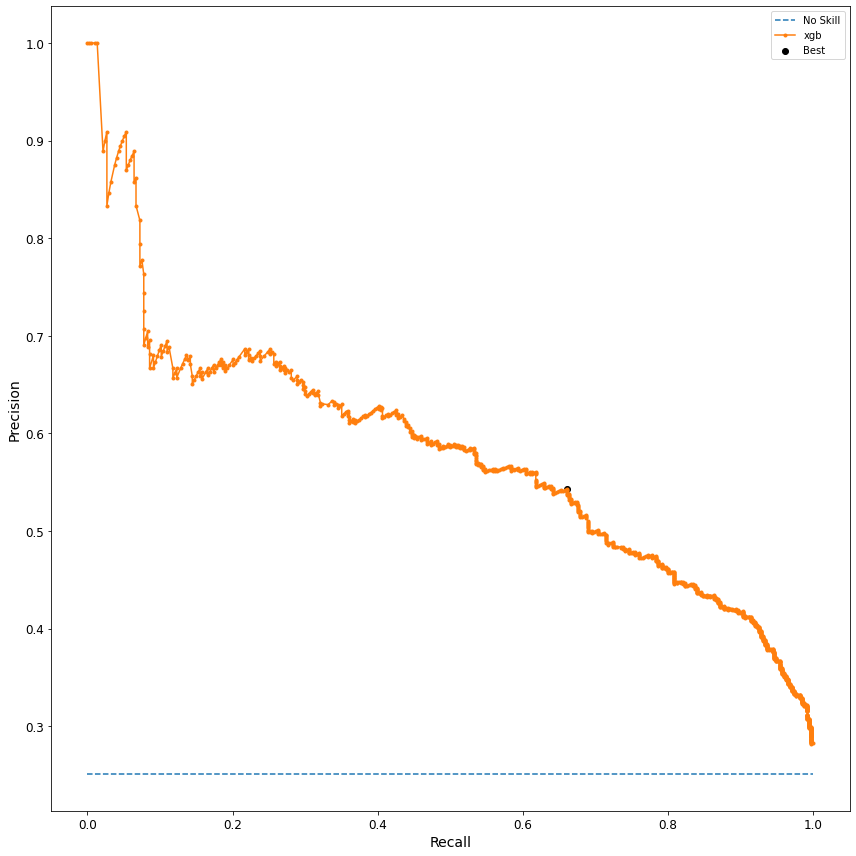

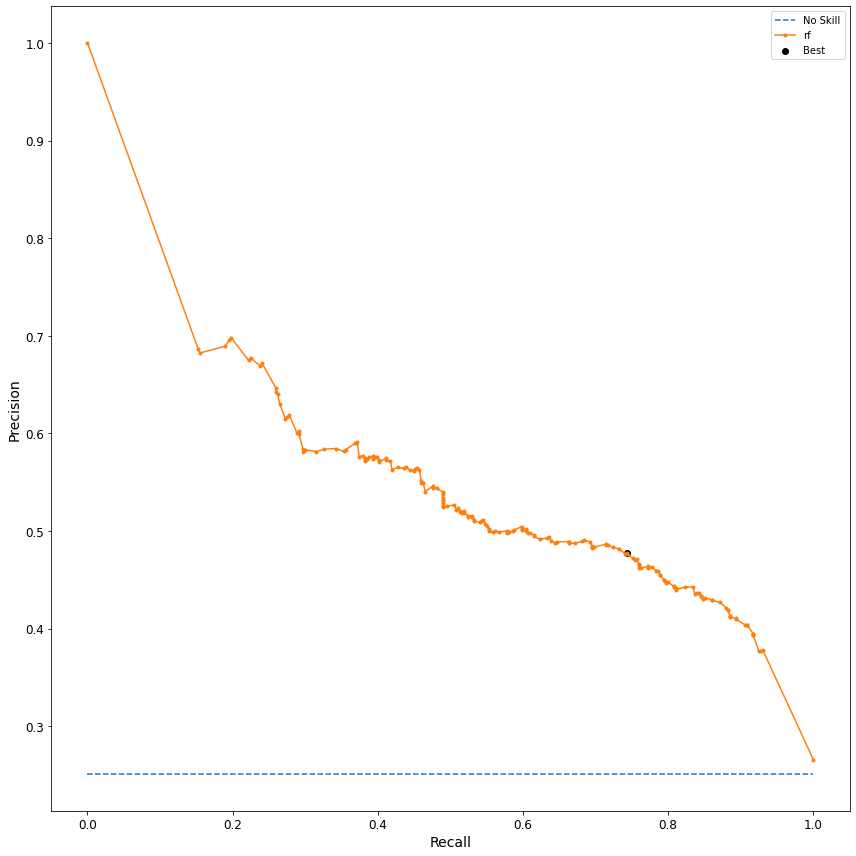

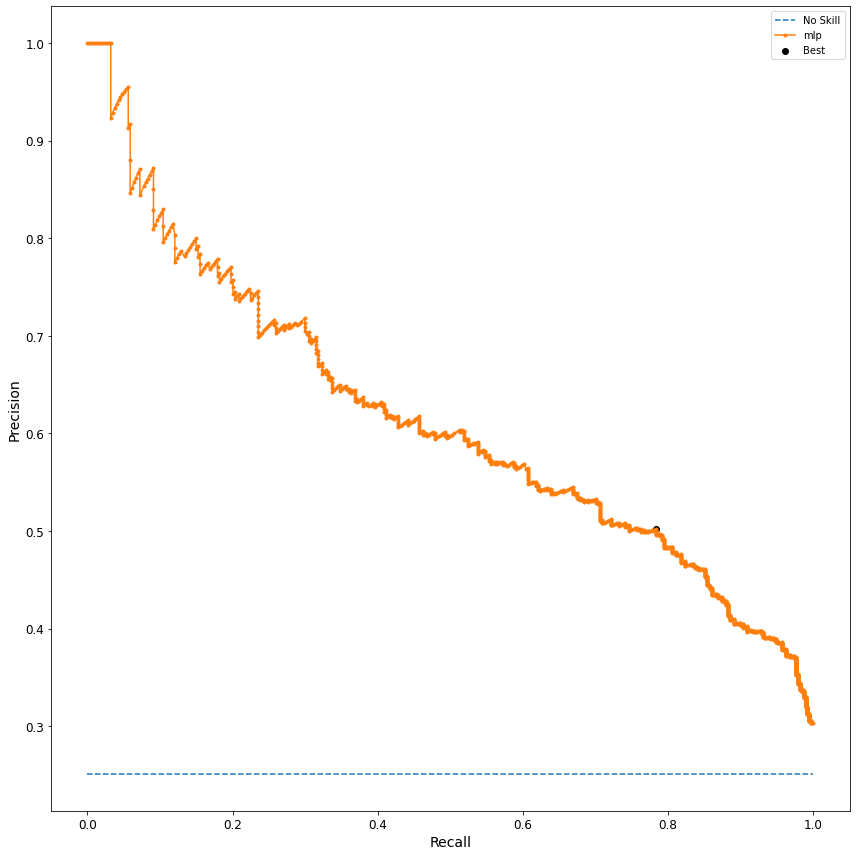

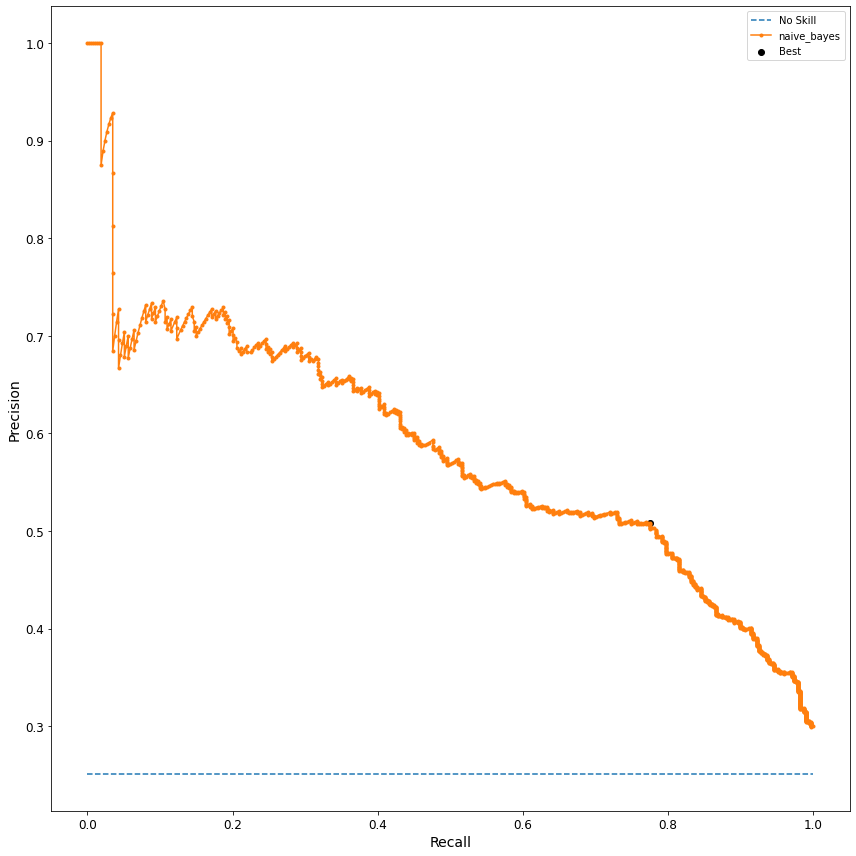

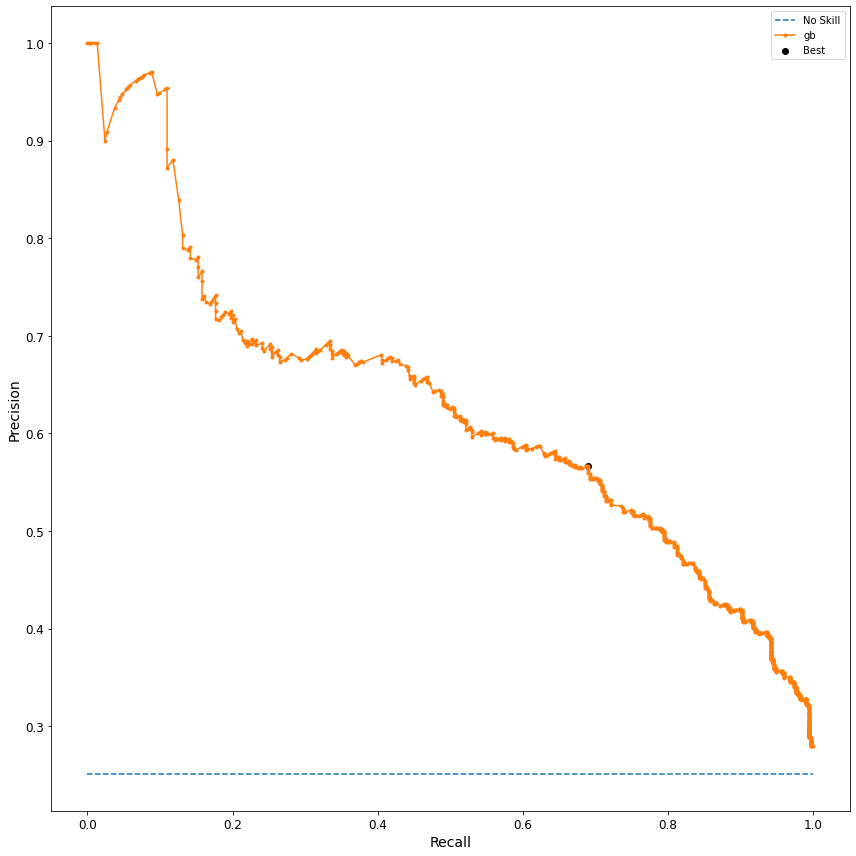

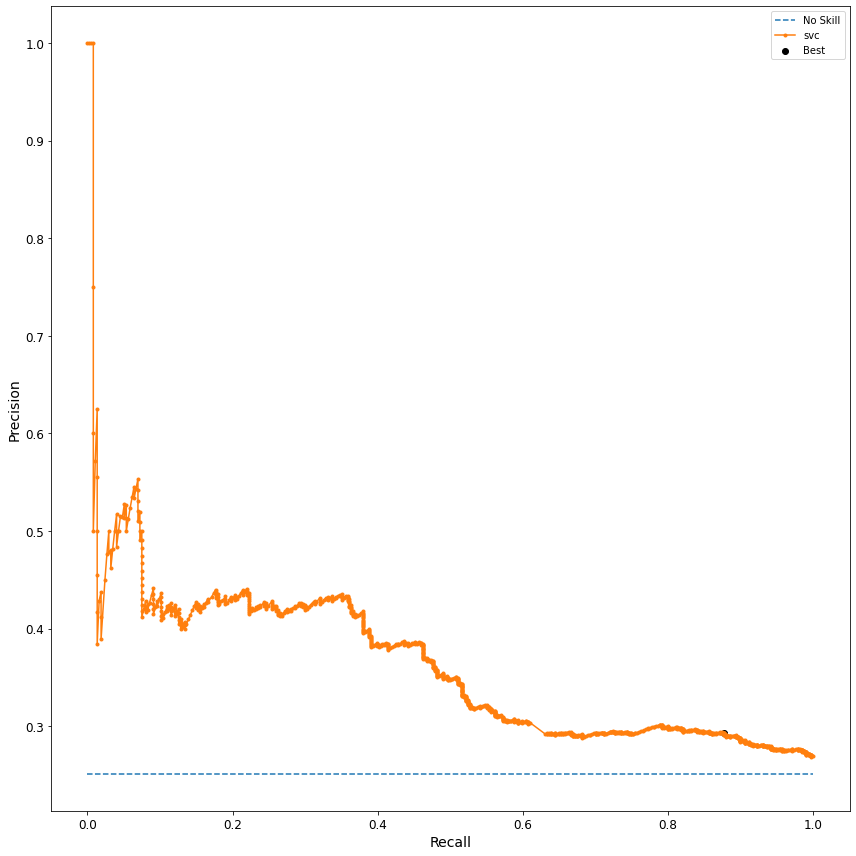

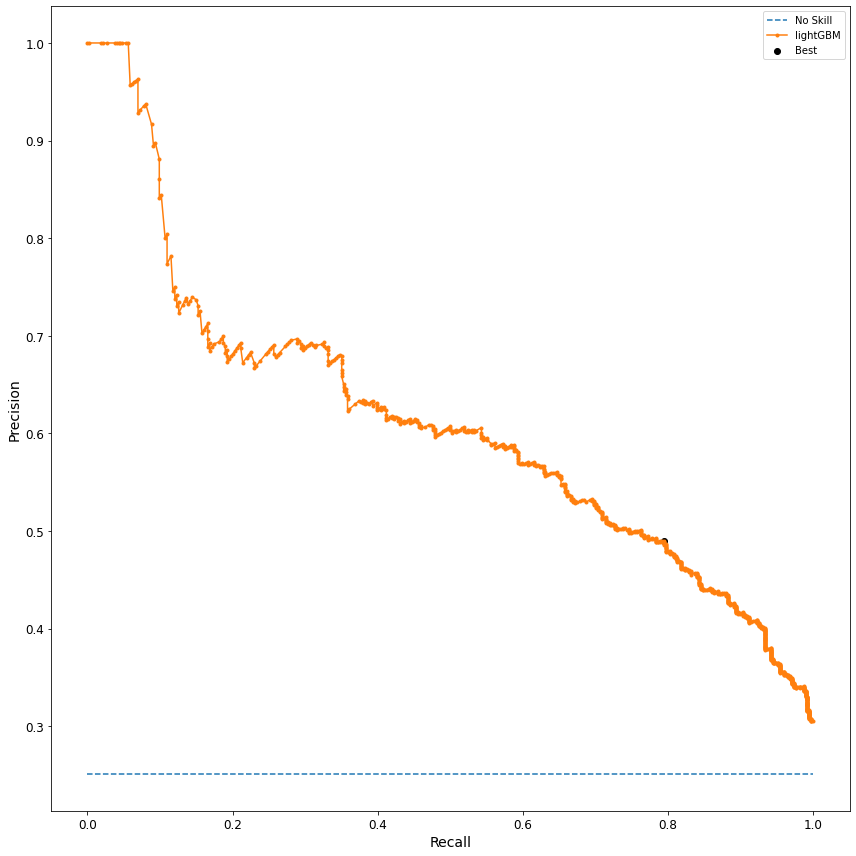

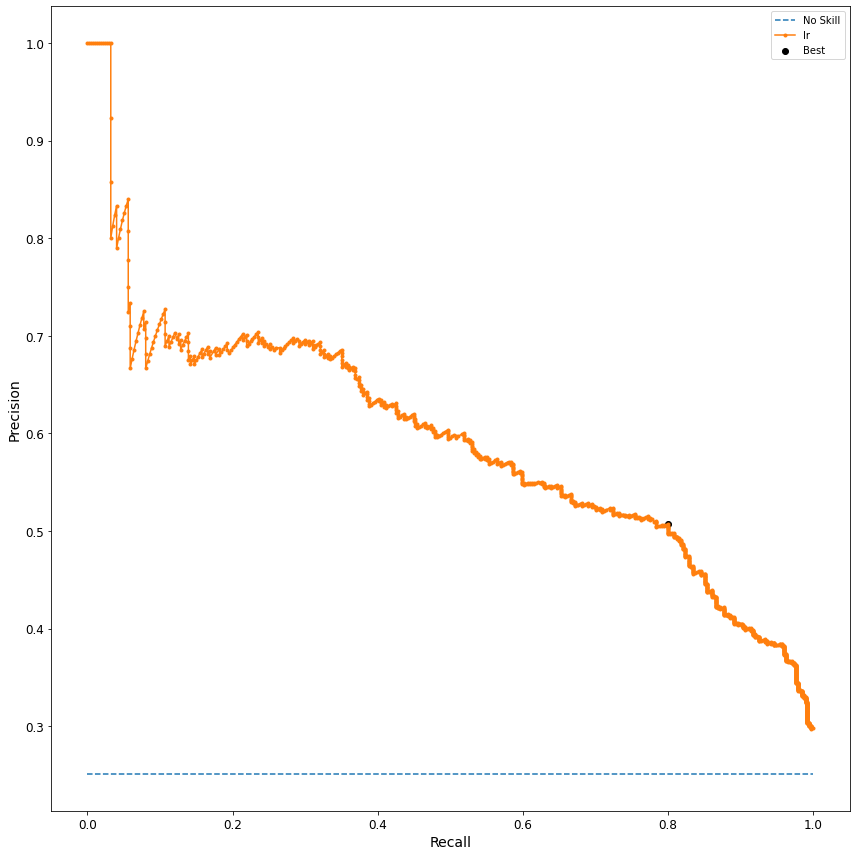

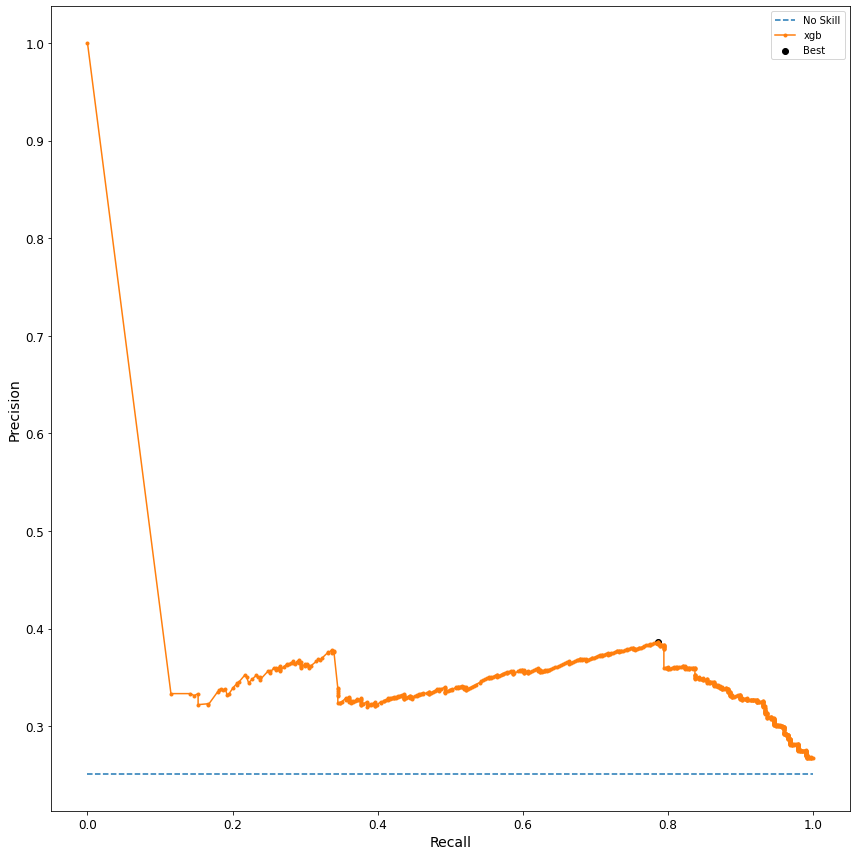

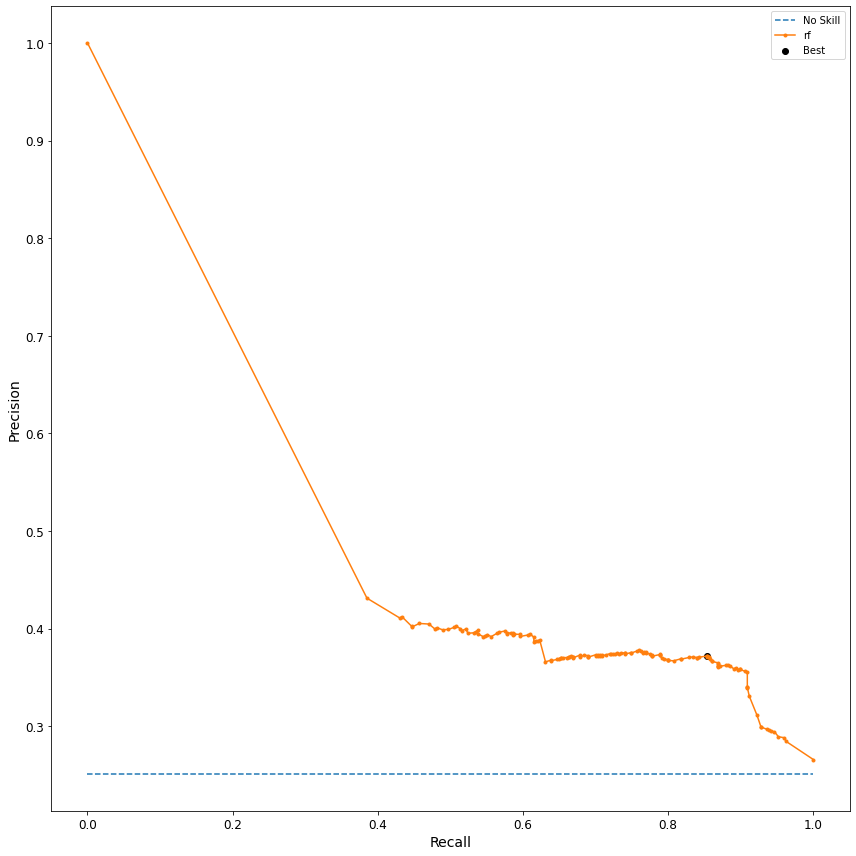

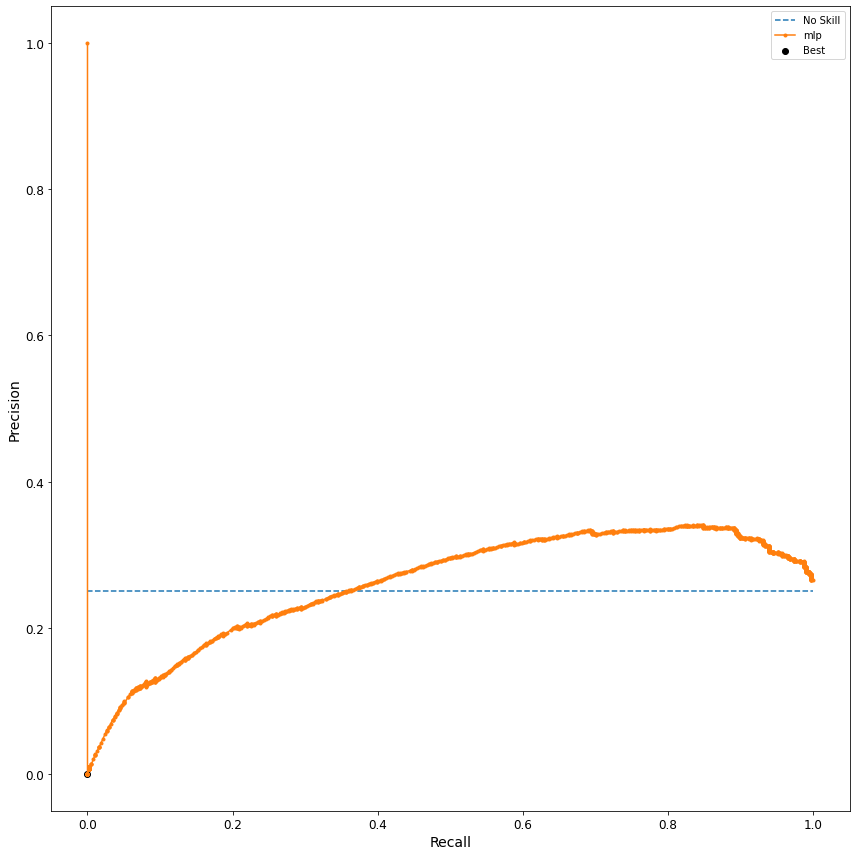

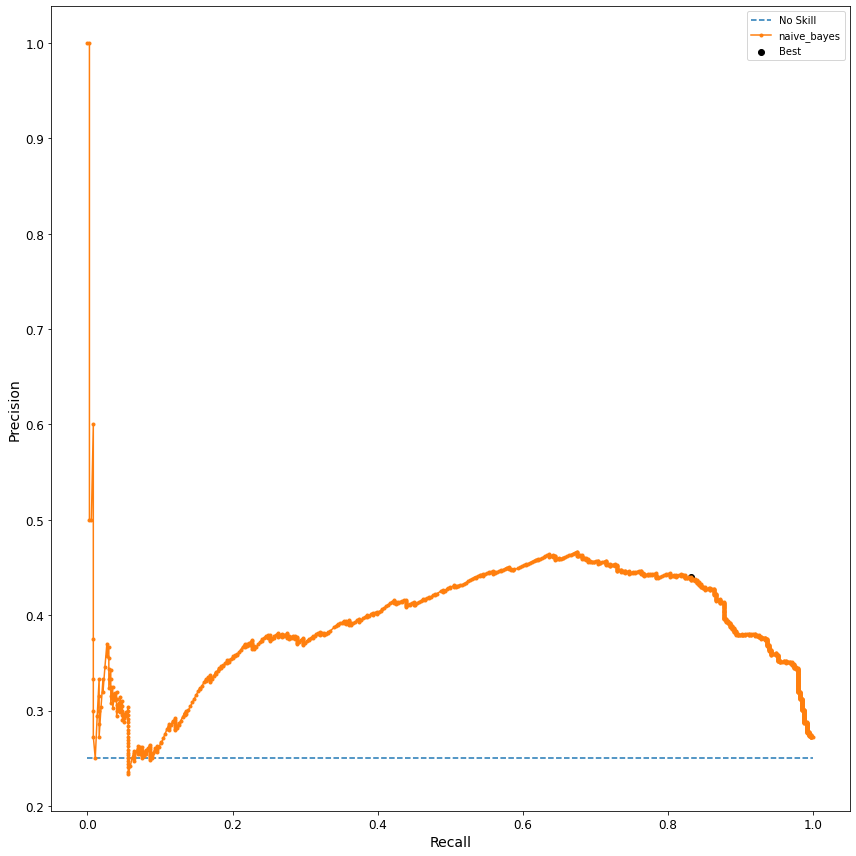

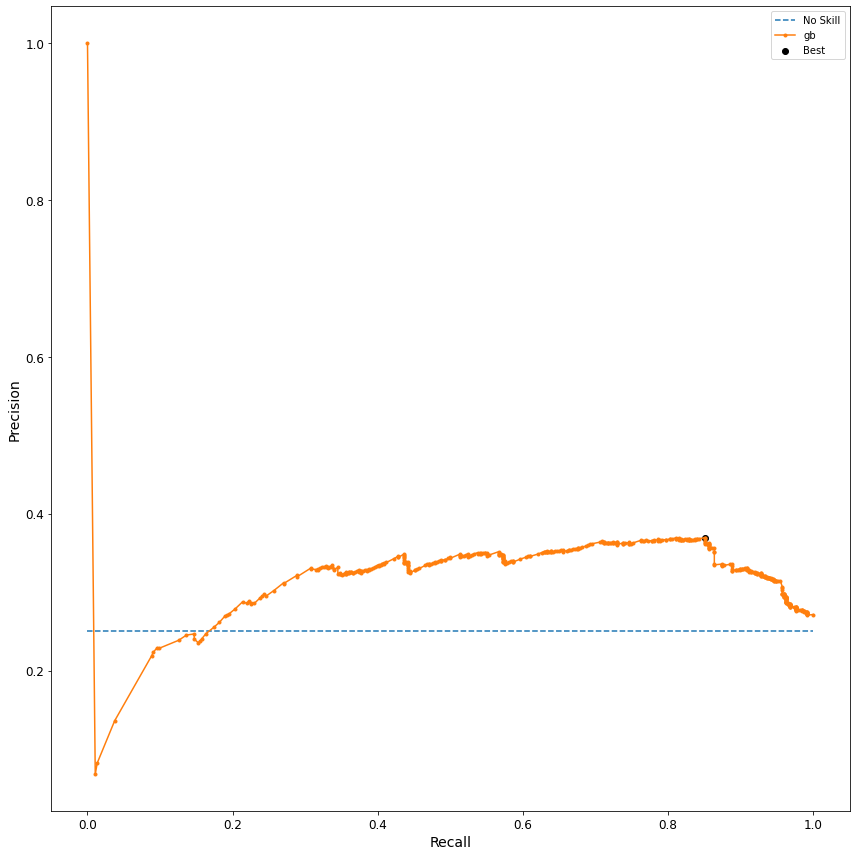

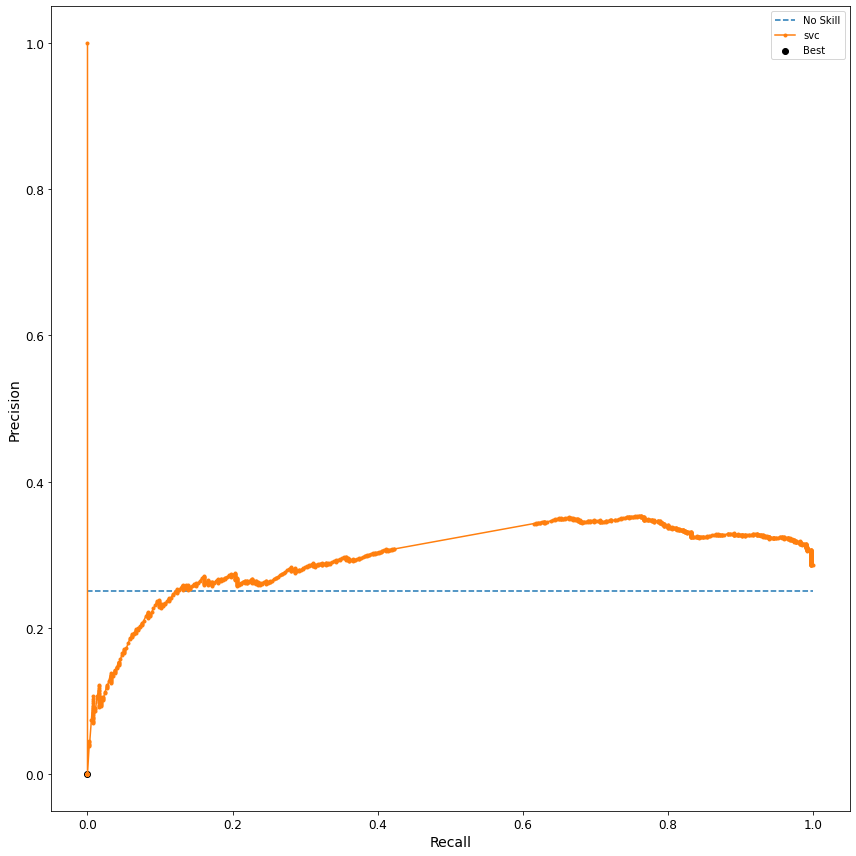

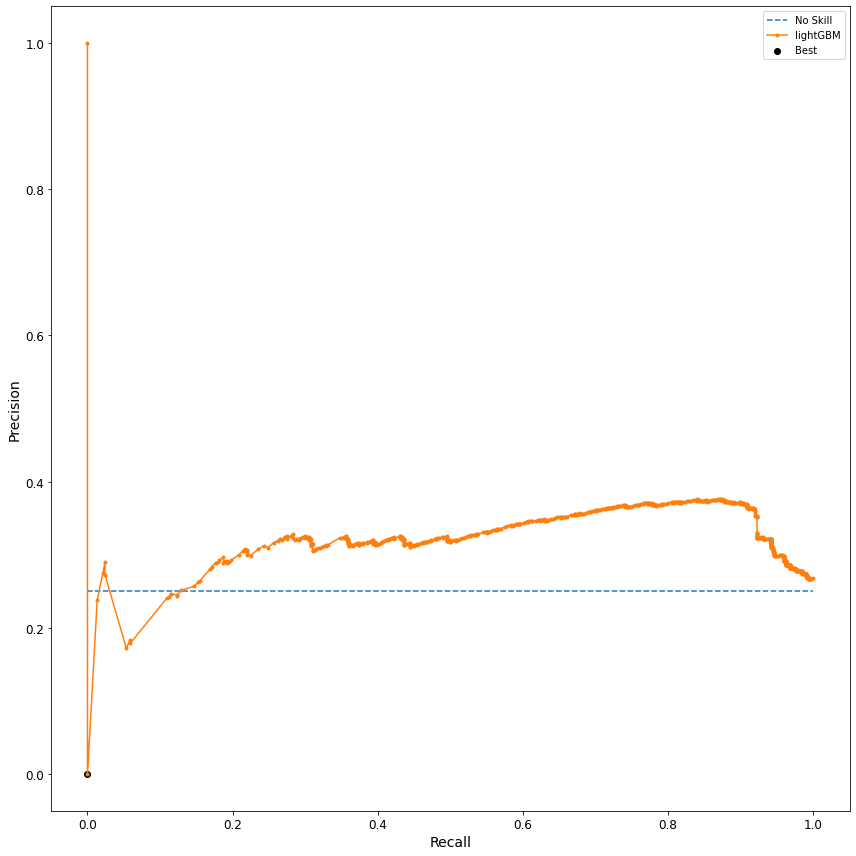

In [56]:
def plot_precision_recall(title, sample_x, sample_y, strat_test_set_x, strat_test_set_y):
    modelrecall = []
    modelprecision = []
    modelfscore = []
    modelthresholds = []
    modelindex = []

    for model in models:
        key = model
        modelindex.append(key)
        model = models[model]
        model.fit(sample_x, sample_y)
        y_scores = model.predict_proba(strat_test_set_x)
        # Keep probabilities for the positive outcome only
        y_scores = y_scores[:, 1]
        # Calculate p/r curves
        precision, recall, thresholds = precision_recall_curve(strat_test_set_y, y_scores)
        # Convert to f-score
        fscore = (2 * precision * recall) / (precision + recall)
        # Locate the index of the largest f-score
        ix = argmax(fscore)
        modelthresholds.append(thresholds[ix])
        modelrecall.append(recall[ix])
        modelprecision.append(precision[ix])
        modelfscore.append(fscore[ix])
        # Plot the curve for the model
        no_skill = len(strat_train_set_y[strat_train_set_y==1]) / len(strat_train_set_y)
        pyplot.figure(figsize=(12,12))
        pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
        pyplot.plot(recall, precision, marker='.', label='{}'.format(key))
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        # Axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        pyplot.legend()
        save_fig(title)

    Model = pd.DataFrame(index=modelindex)
    Model['Recall']=modelrecall
    Model['Precision']=modelprecision
    Model['Fscore']=modelfscore
    Model['Threshold']=modelthresholds

    return Model

precision_recall_over_df = plot_precision_recall('precision_recall_for_oversample', sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)
precision_recall_under_df = plot_precision_recall('precision_recall_for_undersample', sample_x_under, sample_y_under, strat_test_set_x, strat_test_set_y)

In [57]:
precision_recall_over_df.sort_values('Recall', ascending=False)

Recall  Precision    Fscore  Threshold
svc          0.877005   0.293381  0.439678   0.373833
lightGBM     0.794118   0.489292  0.605505   0.938366
mlp          0.783422   0.501712  0.611691   0.487662
lr           0.775401   0.498282  0.606695   0.539083
naive_bayes  0.775401   0.507881  0.613757   0.883967
rf           0.743316   0.477663  0.581590   0.266667
gb           0.689840   0.567033  0.622437   0.601970
xgb          0.660428   0.542857  0.595899   0.988438

In [58]:
precision_recall_under_df.sort_values('Recall', ascending=False)

Recall  Precision    Fscore  Threshold
rf           0.852941   0.371795  0.517857   0.250000
gb           0.850267   0.369338  0.514980   0.328601
naive_bayes  0.831551   0.439887  0.575393   0.696745
lr           0.799465   0.506780  0.620332   0.498213
xgb          0.786096   0.386334  0.518062   0.969209
mlp          0.000000   0.000000       NaN   0.999998
svc          0.000000   0.000000       NaN   0.550625
lightGBM     0.000000   0.000000       NaN   0.999967

# Optuna
Contributor(s): @HishamSalem, @dany-stefan

Using Parameter Tuning with Optuna we find the most optimal parameters that get the best paramaters for F1-Score. Next steps is to use the multiple paramater tuning for perhaps recall and f1 score or maybe minimize the logloss. We can also potentially look into custom loss functions and investigate how the tree based methods specifically lightGBM and XGBoost perform with their custom function.We focus on tuning the LightGBM and XGBoost more as these models are more versatile to focus on precision, recall, or F1-Score.

In [59]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index2, test_index2 in split.split(strat_train_set, strat_train_set['Churn']):
    print('train:', train_index2, 'test:', test_index2)
    strat_train_set2 =strat_train_set.iloc[train_index2]
    strat_1foldvalidate_set = strat_train_set.iloc[test_index2]
strat_train_set_y2 = strat_train_set2['Churn'].copy()
strat_train_set_x2 = strat_train_set2.drop(['Churn'], axis=1)
strat_1foldvalidate_sety = strat_1foldvalidate_set['Churn'].copy()
strat_1foldvalidate_setx = strat_1foldvalidate_set.drop(['Churn'], axis=1)

train: [2214 3395  503 ... 3814 1201 4190] test: [1441 2462 3839 ... 3965 4411 2206]


In [60]:
sample_x_over, sample_y_over = oversample.fit_resample(strat_train_set_x2, strat_train_set_y2)


In [61]:
def LR_Optuna(trial):
    param_grid = {
        "max_iter": trial.suggest_int("max_iter", 50, 170, step=10),
        "C": trial.suggest_float("C",0.05, 1, step=0.05)
        
                 }
    clf = linear_model.LogisticRegression( **param_grid)
    clf.fit(sample_x_over, sample_y_over)
    preds = clf.predict(strat_1foldvalidate_setx)
    probs = clf.predict_proba(strat_1foldvalidate_setx)
 
    # Metrics
    f1 = sklearn.metrics.f1_score(strat_1foldvalidate_sety,preds)
    accuracy = accuracy_score(strat_1foldvalidate_sety,preds)
    precision = metrics.precision_score(strat_1foldvalidate_sety,preds)
    recall = metrics.recall_score(strat_1foldvalidate_sety,preds)
    logloss = metrics.log_loss(strat_1foldvalidate_sety,preds)
    #return f1, logloss, accuracy, precision, recall
    return f1
lrstudy = optuna.create_study(directions=['maximize'])
#study = optuna.create_study(direction='maximize')
lrstudy.optimize(LR_Optuna, n_trials=500)
print('\n\nBEST PARAMETERS : \n',lrstudy.best_params)#get best parameters

[I 2022-02-17 23:59:47,866] A new study created in memory with name: no-name-cc6e49a4-0bb2-4e73-b9ce-77b6677d3d0c
[I 2022-02-17 23:59:47,902] Trial 0 finished with value: 0.635 and parameters: {'max_iter': 70, 'C': 0.15000000000000002}. Best is trial 0 with value: 0.635.
[I 2022-02-17 23:59:47,939] Trial 1 finished with value: 0.6319702602230483 and parameters: {'max_iter': 170, 'C': 0.9000000000000001}. Best is trial 0 with value: 0.635.
[I 2022-02-17 23:59:47,977] Trial 2 finished with value: 0.6334164588528678 and parameters: {'max_iter': 100, 'C': 0.2}. Best is trial 0 with value: 0.635.
[I 2022-02-17 23:59:48,014] Trial 3 finished with value: 0.6319702602230483 and parameters: {'max_iter': 160, 'C': 0.7500000000000001}. Best is trial 0 with value: 0.635.
[I 2022-02-17 23:59:48,052] Trial 4 finished with value: 0.6327543424317618 and parameters: {'max_iter': 110, 'C': 0.4}. Best is trial 0 with value: 0.635.
[I 2022-02-17 23:59:48,083] Trial 5 finished with value: 0.632627646326276



BEST PARAMETERS : 
 {'max_iter': 70, 'C': 0.15000000000000002}


In [62]:
def XGB_Optuna(trial):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 100, step=1),
        'max_features':trial.suggest_int('max_features',1,15,step=1,log=True),        
         'max_depth':trial.suggest_int('max_depth', 1, 20,step=1, log=True),
         'eval_metric':trial.suggest_categorical("eval_metric", ['aucpr','map','error@0.1','error@0.3','error@0.5','error@0.7','error@0.8']),
         'learning_rate':trial.suggest_float("learning_rate", 0, 0.03,step=0.005),
        'tree_method':trial.suggest_categorical("tree_method", ['auto','exact','approx','hist','gpu_hist']),
         'scale_pos_weight':trial.suggest_int("scale_pos_weight", 10, 1000, step=10),
        'max_delta_step':trial.suggest_int("max_delta_step", 0, 100, step=1)
    }
    clf = XGBClassifier( use_label_encoder=False,gpu_hist=0,**param_grid)
    clf.fit(sample_x_over, sample_y_over)
    preds = clf.predict(strat_1foldvalidate_setx)
    probs = clf.predict_proba(strat_1foldvalidate_setx)
 
    # Metrics
    f1 = sklearn.metrics.f1_score(strat_1foldvalidate_sety,preds)
    accuracy = accuracy_score(strat_1foldvalidate_sety,preds)
    precision = metrics.precision_score(strat_1foldvalidate_sety,preds)
    recall = metrics.recall_score(strat_1foldvalidate_sety,preds)
    logloss = metrics.log_loss(strat_1foldvalidate_sety,preds)
    #return f1, logloss, accuracy, precision, recall
    return f1
xgbstudy = optuna.create_study(directions=['maximize'])
xgbstudy.optimize(XGB_Optuna, n_trials=500)
print('\n\nBEST PARAMETERS : \n',xgbstudy.best_params)#get best parameters

[I 2022-02-18 00:00:06,732] A new study created in memory with name: no-name-0b956583-43b1-4465-9157-84f26ab626bb
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:06,784] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 18, 'max_features': 1, 'max_depth': 5, 'eval_metric': 'map', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 520, 'max_delta_step': 73}. Best is trial 0 with value: 0.0.
[I 2022-02-18 00:00:06,866] Trial 1 finished with value: 0.5601617795753285 and parameters: {'n_estimators': 79, 'max_features': 1, 'max_depth': 4, 'eval_metric': 'error@0.7', 'learning_rate': 0.01, 'tree_method': 'approx', 'scale_pos_weight': 130, 'max_delta_step': 62}. Best is trial 1 with value: 0.560161779

[00:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:06,892] Trial 2 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 16, 'max_features': 5, 'max_depth': 1, 'eval_metric': 'error@0.5', 'learning_rate': 0.03, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 89}. Best is trial 1 with value: 0.5601617795753285.


[00:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:06,950] Trial 3 finished with value: 0.5601617795753285 and parameters: {'n_estimators': 40, 'max_features': 1, 'max_depth': 20, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 760, 'max_delta_step': 92}. Best is trial 1 with value: 0.5601617795753285.
[I 2022-02-18 00:00:07,092] Trial 4 finished with value: 0.5783898305084746 and parameters: {'n_estimators': 69, 'max_features': 4, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.02, 'tree_method': 'auto', 'scale_pos_weight': 360, 'max_delta_step': 41}. Best is trial 4 with value: 0.5783898305084746.


[00:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:07,406] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 77, 'max_features': 7, 'max_depth': 7, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'gpu_hist', 'scale_pos_weight': 480, 'max_delta_step': 6}. Best is trial 4 with value: 0.5783898305084746.
[I 2022-02-18 00:00:07,427] Trial 6 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 3, 'max_features': 10, 'max_depth': 1, 'eval_metric': 'error@0.5', 'learning_rate': 0.03, 'tree_method': 'hist', 'scale_pos_weight': 900, 'max_delta_step': 66}. Best is trial 4 with value: 0.5783898305084746.
[I 2022-02-18 00:00:07,452] Trial 7 finished with value: 0.5595959595959596 and paramet

[00:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:07,780] Trial 10 finished with value: 0.5802997858672376 and parameters: {'n_estimators': 98, 'max_features': 3, 'max_depth': 19, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 190, 'max_delta_step': 40}. Best is trial 10 with value: 0.5802997858672376.


[00:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:08,042] Trial 11 finished with value: 0.5802997858672376 and parameters: {'n_estimators': 97, 'max_features': 3, 'max_depth': 20, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 220, 'max_delta_step': 34}. Best is trial 10 with value: 0.5802997858672376.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:08,262] Trial 12 finished with value: 0.5805084745762712 and parameters: {'n_estimators': 96, 'max_features': 2, 'max_depth': 10, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 190, 'max_delta_step': 39}. Best is trial 12 with value: 0.5805084745762712.
[I 2022-02-18 00:00:08,465] Trial 13 finished with value: 0.5741127348643006 and parameters: {'n_estimators': 98, 'max_features': 2, 'max_depth': 9, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 220, 'max_delta_step': 46}. Best is trial 12 with value: 0.5805084745762712.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:08,633] Trial 14 finished with value: 0.5815450643776824 and parameters: {'n_estimators': 57, 'max_features': 2, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 32}. Best is trial 14 with value: 0.5815450643776824.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:08,809] Trial 15 finished with value: 0.5892857142857143 and parameters: {'n_estimators': 45, 'max_features': 2, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 24}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:08,971] Trial 16 finished with value: 0.5891472868217055 and parameters: {'n_estimators': 45, 'max_features': 2, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 25}. Best is trial 15 with value: 0.5892857142857143.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:09,030] Trial 17 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 39, 'max_features': 6, 'max_depth': 2, 'eval_metric': 'error@0.7', 'learning_rate': 0.01, 'tree_method': 'gpu_hist', 'scale_pos_weight': 30, 'max_delta_step': 10}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,095] Trial 18 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 34, 'max_features': 4, 'max_depth': 6, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 600, 'max_delta_step': 24}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,166] Trial 19 finished with value: 0.5612968591691996 and parameters: {'n_estimators': 53, 'max_features': 2, 'max_depth': 3, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 310, 'max_delta_step': 0}. Best is trial 15 with value: 0.5892857142857143.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:09,249] Trial 20 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 29, 'max_features': 3, 'max_depth': 13, 'eval_metric': 'error@0.1', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 130, 'max_delta_step': 28}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,416] Trial 21 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 55, 'max_features': 2, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 53}. Best is trial 15 with value: 0.5892857142857143.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:09,563] Trial 22 finished with value: 0.5752855659397715 and parameters: {'n_estimators': 63, 'max_features': 2, 'max_depth': 8, 'eval_metric': 'error@0.8', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 100, 'max_delta_step': 55}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,721] Trial 23 finished with value: 0.585792349726776 and parameters: {'n_estimators': 47, 'max_features': 4, 'max_depth': 12, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 20, 'max_delta_step': 56}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,763] Trial 24 finished with value: 0.568788501026694 and parameters: {'n_estimators': 46, 'max_features': 4, 'max_depth': 15, 'eval_metric': 'error@0.8', 'learning_rate': 0.01, 'tree_method': 'hist', 'scale_pos_weight': 290, 'max_delta_step': 16}. Best is trial 15 with value: 0.5892857142857143.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:09,827] Trial 25 finished with value: 0.5723140495867769 and parameters: {'n_estimators': 27, 'max_features': 7, 'max_depth': 5, 'eval_metric': 'error@0.8', 'learning_rate': 0.025, 'tree_method': 'exact', 'scale_pos_weight': 100, 'max_delta_step': 74}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:09,935] Trial 26 finished with value: 0.568788501026694 and parameters: {'n_estimators': 47, 'max_features': 3, 'max_depth': 13, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 270, 'max_delta_step': 49}. Best is trial 15 with value: 0.5892857142857143.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:10,107] Trial 27 finished with value: 0.5781083953241233 and parameters: {'n_estimators': 66, 'max_features': 5, 'max_depth': 7, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 13}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:10,157] Trial 28 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 42, 'max_features': 10, 'max_depth': 2, 'eval_metric': 'error@0.1', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 130, 'max_delta_step': 26}. Best is trial 15 with value: 0.5892857142857143.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:10,220] Trial 29 finished with value: 0.0 a

[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:10,410] Trial 31 finished with value: 0.5811240721102863 and parameters: {'n_estimators': 56, 'max_features': 3, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 56}. Best is trial 15 with value: 0.5892857142857143.


[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:10,673] Trial 32 finished with value: 0.5855338691159587 and parameters: {'n_estimators': 61, 'max_features': 2, 'max_depth': 13, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 57}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:10,830] Trial 33 finished with value: 0.5790031813361611 and parameters: {'n_estimators': 61, 'max_features': 5, 'max_depth': 15, 'eval_metric': 'error@0.8', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 160, 'max_delta_step': 61}. Best is trial 15 with value: 0.5892857142857143.


[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:11,018] Trial 34 finished with value: 0.573208722741433 and parameters: {'n_estimators': 76, 'max_features': 1, 'max_depth': 8, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'auto', 'scale_pos_weight': 60, 'max_delta_step': 78}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:11,132] Trial 35 finished with value: 0.5687103594080338 and parameters: {'n_estimators': 49, 'max_features': 4, 'max_depth': 13, 'eval_metric': 'map', 'learning_rate': 0.02, 'tree_method': 'approx', 'scale_pos_weight': 80, 'max_delta_step': 45}. Best is trial 15 with value: 0.5892857142857143.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:11,367] Trial 36 finished with value: 0.5723140495867769 and parameters: {'n_estimators': 72, 'max_features': 3, 'max_depth': 6, 'eval_metric': 'error@0.5', 'learning_rate': 0.01, 'tree_method': 'gpu_hist', 'scale_pos_weight': 20, 'max_delta_step': 60}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:11,572] Trial 37 finished with value: 0.5774946921443737 and parameters: {'n_estimators': 89, 'max_features': 7, 'max_depth': 17, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 240, 'max_delta_step': 86}. Best is trial 15 with value: 0.5892857142857143.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:11,621] Trial 38 finished with value: 0.573208722741433 and parameters: {'n_estimators': 37, 'max_features': 5, 'max_depth': 9, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 160, 'max_delta_step': 68}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:11,689] Trial 39 finished with value: 0.5676229508196722 and parameters: {'n_estimators': 41, 'max_features': 2, 'max_depth': 4, 'eval_metric': 'error@0.7', 'learning_rate': 0.02, 'tree_method': 'auto', 'scale_pos_weight': 740, 'max_delta_step': 3}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:11,789] Trial 40 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 45, 'max_features': 6, 'max_depth': 14, 'eval_metric': 'error@0.5', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 670, 'max_delta_step': 71}. Best is trial 15 with value: 0.5892857142857143.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:11,961] Trial 41 finished with value: 0.5829694323144105 and parameters: {'n_estimators': 52, 'max_features': 2, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 20, 'max_delta_step': 57}. Best is trial 15 with value: 0.5892857142857143.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:12,133] Trial 42 finished with value: 0.582441113490364 and parameters: {'n_estimators': 59, 'max_features': 2, 'max_depth': 12, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 51}. Best is trial 15 with value: 0.5892857142857143.


[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:12,479] Trial 43 finished with value: 0.5878048780487805 and parameters: {'n_estimators': 67, 'max_features': 4, 'max_depth': 18, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 15 with value: 0.5892857142857143.


[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:12,704] Trial 44 finished with value: 0.5802997858672376 and parameters: {'n_estimators': 84, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 160, 'max_delta_step': 43}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:12,765] Trial 45 finished with value: 0.5747126436781609 and parameters: {'n_estimators': 69, 'max_features': 4, 'max_depth': 18, 'eval_metric': 'error@0.8', 'learning_rate': 0.025, 'tree_method': 'hist', 'scale_pos_weight': 450, 'max_delta_step': 63}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:12,895] Trial 46 finished with value: 0.5678233438485805 and parameters: {'n_estimators': 63, 'max_features': 3, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.02, 'tree_method': 'approx', 'scale_pos_weight': 120, 'max_delta_step': 48}. Best is trial 15 with value: 0.5892857142857143.


[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:13,104] Trial 47 finished with value: 0.5809217577706323 and parameters: {'n_estimators': 72, 'max_features': 6, 'max_depth': 9, 'eval_metric': 'error@0.8', 'learning_rate': 0.03, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 38}. Best is trial 15 with value: 0.5892857142857143.
[I 2022-02-18 00:00:13,203] Trial 48 finished with value: 0.5723140495867769 and parameters: {'n_estimators': 50, 'max_features': 4, 'max_depth': 7, 'eval_metric': 'error@0.1', 'learning_rate': 0.02, 'tree_method': 'auto', 'scale_pos_weight': 340, 'max_delta_step': 23}. Best is trial 15 with value: 0.5892857142857143.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:13,366] Trial 49 finished with value: 0.5953488372093024 and parameters: {'n_estimators': 34, 'max_features': 8, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:13,448] Trial 50 finished with value: 0.568788501026694 and parameters: {'n_estimators': 24, 'max_features': 6, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.025, 'tree_method': 'gpu_hist', 'scale_pos_weight': 830, 'max_delta_step': 30}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:13,568] Trial 51 finished with value: 0.5845824411134903 and parameters: {'n_estimators': 37, 'max_features': 15, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 38}. Best is trial 49 with value: 0.5953488372093024.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:13,701] Trial 52 finished with value: 0.5829694323144105 and parameters: {'n_estimators': 34, 'max_features': 11, 'max_depth': 10, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 97}. Best is trial 49 with value: 0.5953488372093024.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:13,815] Trial 53 finished with value: 0.5790031813361611 and parameters: {'n_estimators': 45, 'max_features': 8, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 190, 'max_delta_step': 9}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:13,948] Trial 54 finished with value: 0.5840517241379309 and parameters: {'n_estimators': 43, 'max_features': 13, 'max_depth': 12, 'eval_metric': 'error@0.8', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 21}. Best is trial 49 with value: 0.5953488372093024.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:14,106] Trial 55 finished with value: 0.5769644779332616 and parameters: {'n_estimators': 52, 'max_features': 8, 'max_depth': 8, 'eval_metric': 'error@0.8', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 34}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:14,152] Trial 56 finished with value: 0.5744234800838575 and parameters: {'n_estimators': 11, 'max_features': 13, 'max_depth': 10, 'eval_metric': 'error@0.5', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 150, 'max_delta_step': 18}. Best is trial 49 with value: 0.5953488372093024.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:14,344] Trial 57 finished with value: 0.5825242718446603 and parameters: {'n_estimators': 66, 'max_features': 5, 'max_depth': 14, 'eval_metric': 'error@0.8', 'learning_rate': 0.025, 'tree_method': 'exact', 'scale_pos_weight': 110, 'max_delta_step': 42}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:14,458] Trial 58 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 59, 'max_features': 9, 'max_depth': 17, 'eval_metric': 'error@0.7', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 400, 'max_delta_step': 51}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:14,512] Trial 59 finished with value: 0.5826271186440678 and parameters: {'n_estimators': 34, 'max_features': 3, 'max_depth': 12, 'eval_metric': 'map', 'learning_rate': 0.01, 'tree_method': 'hist', 'scale_pos_weight': 50, 'max_delta_step': 29}. Best is trial 49 with value: 0.5953488372093024.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:14,566] Trial 60 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 22, 'max_features': 2, 'max_depth': 6, 'eval_metric': 'error@0.8', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 200, 'max_delta_step': 58}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:14,667] Trial 61 finished with value: 0.5839572192513368 and parameters: {'n_estimators': 32, 'max_features': 14, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 39}. Best is trial 49 with value: 0.5953488372093024.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:14,801] Trial 62 finished with value: 0.5862068965517241 and parameters: {'n_estimators': 40, 'max_features': 15, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 36}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:14,955] Trial 63 finished with value: 0.5878524945770065 and parameters: {'n_estimators': 48, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 47}. Best is trial 49 with value: 0.5953488372093024.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:15,079] Trial 64 finished with value: 0.582089552238806 and parameters: {'n_estimators': 39, 'max_features': 8, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.025, 'tree_method': 'exact', 'scale_pos_weight': 120, 'max_delta_step': 45}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:15,241] Trial 65 finished with value: 0.5904139433551199 and parameters: {'n_estimators': 48, 'max_features': 11, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 26}. Best is trial 49 with value: 0.5953488372093024.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:15,379] Trial 66 finished with value: 0.5729499467518637 and parameters: {'n_estimators': 38, 'max_features': 12, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'approx', 'scale_pos_weight': 50, 'max_delta_step': 27}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:15,533] Trial 67 finished with value: 0.582089552238806 and parameters: {'n_estimators': 54, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 100, 'max_delta_step': 34}. Best is trial 49 with value: 0.5953488372093024.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:15,711] Trial 68 finished with value: 0.568788501026694 and parameters: {'n_estimators': 48, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'gpu_hist', 'scale_pos_weight': 250, 'max_delta_step': 14}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:15,791] Trial 69 finished with value: 0.5792811839323467 and parameters: {'n_estimators': 28, 'max_features': 11, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.01, 'tree_method': 'auto', 'scale_pos_weight': 150, 'max_delta_step': 24}. Best is trial 49 with value: 0.5953488372093024.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:15,913] Trial 70 finished with value: 0.0 and parameters: {'n_estimators': 43, 'max_features': 15, 'max_depth': 10, 'eval_metric': 'error@0.3', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 19}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:16,057] Trial 71 finished with value: 0.5833333333333333 and parameters: {'n_estimators': 48, 'max_features': 12, 'max_depth': 12, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 32}. Best is trial 49 with value: 0.5953488372093024.


[00:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:16,185] Trial 72 finished with value: 0.5796178343949046 and parameters: {'n_estimators': 45, 'max_features': 7, 'max_depth': 9, 'eval_metric': 'error@0.3', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 25}. Best is trial 49 with value: 0.5953488372093024.
[I 2022-02-18 00:00:16,258] Trial 73 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 41, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.015, 'tree_method': 'exact', 'scale_pos_weight': 520, 'max_delta_step': 36}. Best is trial 49 with value: 0.5953488372093024.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:16,472] Trial 74 finished with value: 0.6006825938566552 and parameters: {'n_estimators': 50, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 74 with value: 0.6006825938566552.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:16,690] Trial 75 finished with value: 0.5988571428571429 and parameters: {'n_estimators': 51, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 74 with value: 0.6006825938566552.
[I 2022-02-18 00:00:16,835] Trial 76 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 57, 'max_features': 9, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 130, 'max_delta_step': 53}. Best is trial 74 with value: 0.6006825938566552.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:17,051] Trial 77 finished with value: 0.6009070294784581 and parameters: {'n_estimators': 52, 'max_features': 8, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 48}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:17,193] Trial 78 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 52, 'max_features': 8, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 48}. Best is trial 77 with value: 0.6009070294784581.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:17,265] Trial 79 finished with value: 0.0 and parameters: {'n_estimators': 55, 'max_features': 7, 'max_depth': 11, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 43}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:17,389] Trial 80 finished with value: 0.5752855659397715 and parameters: {'n_estimators': 52, 'max_features': 9, 'max_depth': 8, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 46}. Best is trial 77 with value: 0.6009070294784581.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:17,584] Trial 81 finished with value: 0.6009070294784581 and parameters: {'n_estimators': 46, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:17,734] Trial 82 finished with value: 0.5843179377013963 and parameters: {'n_estimators': 48, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 65}. Best is trial 77 with value: 0.6009070294784581.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:17,942] Trial 83 finished with value: 0.5981941309255079 and parameters: {'n_estimators': 50, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 55}. Best is trial 77 with value: 0.6009070294784581.


[00:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:18,169] Trial 84 finished with value: 0.596846846846847 and parameters: {'n_estimators': 58, 'max_features': 13, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 59}. Best is trial 77 with value: 0.6009070294784581.


[00:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:18,395] Trial 85 finished with value: 0.596846846846847 and parameters: {'n_estimators': 58, 'max_features': 13, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 60}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:18,588] Trial 86 finished with value: 0.5954545454545453 and parameters: {'n_estimators': 57, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 54}. Best is trial 77 with value: 0.6009070294784581.


[00:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[I 2022-02-18 00:00:18,792] Trial 87 finished with value: 0.5966101694915255 and parameters: {'n_estimators': 63, 'max_features': 13, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 54}. Best is trial 77 with value: 0.6009070294784581.


[I 2022-02-18 00:00:18,924] Trial 88 finished with value: 0.5693430656934307 and parameters: {'n_estimators': 62, 'max_features': 13, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 70, 'max_delta_step': 54}. Best is trial 77 with value: 0.6009070294784581.


[00:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:19,032] Trial 89 finished with value: 0.5684430512016719 and parameters: {'n_estimators': 58, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 130, 'max_delta_step': 60}. Best is trial 77 with value: 0.6009070294784581.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:19,143] Trial 90 finished with value: 0.0 and parameters: {'n_estimators': 56, 'max_features': 10, 'max_depth': 10, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'approx', 'scale_pos_weight': 110, 'max_delta_step': 62}. Best is trial 77 with value: 0.6009070294784581.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:19,366] Trial 91 finished with value: 0.5954545454545453 and parameters: {'n_estimators': 64, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 67}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:19,566] Trial 92 finished with value: 0.5966101694915255 and parameters: {'n_estimators': 64, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 68}. Best is trial 77 with value: 0.6009070294784581.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:19,692] Trial 93 finished with value: 0.5693430656934307 and parameters: {'n_estimators': 61, 'max_features': 13, 'max_depth': 11, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 70, 'max_delta_step': 67}. Best is trial 77 with value: 0.6009070294784581.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:19,860] Trial 94 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 65, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 59}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:20,013] Trial 95 finished with value: 0.5678233438485805 and parameters: {'n_estimators': 72, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 60, 'max_delta_step': 70}. Best is trial 77 with value: 0.6009070294784581.


[00:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:20,162] Trial 96 finished with value: 0.0 and parameters: {'n_estimators': 59, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 55}. Best is trial 77 with value: 0.6009070294784581.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:20,389] Trial 97 finished with value: 0.5986394557823129 and parameters: {'n_estimators': 64, 'max_features': 12, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 63}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:20,511] Trial 98 finished with value: 0.5678233438485805 and parameters: {'n_estimators': 54, 'max_features': 13, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 60, 'max_delta_step': 63}. Best is trial 77 with value: 0.6009070294784581.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:20,656] Trial 99 finished with value: 0.5684430512016719 and parameters: {'n_estimators': 69, 'max_features': 14, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 100, 'max_delta_step': 75}. Best is trial 77 with value: 0.6009070294784581.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:20,797] Trial 100 finished with value: 0.0 and parameters: {'n_estimators': 50, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 570, 'max_delta_step': 50}. Best is trial 77 with value: 0.6009070294784581.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:20,996] Trial 101 finished with value: 0.5966101694915255 and parameters: {'n_estimators': 60, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 65}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:21,190] Trial 102 finished with value: 0.572961373390558 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 65}. Best is trial 77 with value: 0.6009070294784581.


[00:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:21,393] Trial 103 finished with value: 0.5952649379932357 and parameters: {'n_estimators': 68, 'max_features': 9, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 56}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:21,524] Trial 104 finished with value: 0.5684430512016719 and parameters: {'n_estimators': 60, 'max_features': 15, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 80, 'max_delta_step': 70}. Best is trial 77 with value: 0.6009070294784581.


[00:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:21,998] Trial 105 finished with value: 0.5771670190274841 and parameters: {'n_estimators': 63, 'max_features': 12, 'max_depth': 11, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 50, 'max_delta_step': 58}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:22,126] Trial 106 finished with value: 0.5705196182396607 and parameters: {'n_estimators': 51, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 63}. Best is trial 77 with value: 0.6009070294784581.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:22,248] Trial 107 finished with value: 0.5675392670157068 and parameters: {'n_estimators': 54, 'max_features': 13, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 90, 'max_delta_step': 49}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:22,327] Trial 108 finished with value: 0.5768025078369906 and parameters: {'n_estimators': 71, 'max_features': 11, 'max_depth': 9, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'hist', 'scale_pos_weight': 60, 'max_delta_step': 52}. Best is trial 77 with value: 0.6009070294784581.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:22,424] Trial 109 finished with value: 0.0 and p

[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:00:22,459] Trial 110 finished with value: 0.5855263157894737 and parameters: {'n_estimators': 2, 'max_features': 9, 'max_depth': 10, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 72}. Best is trial 77 with value: 0.6009070294784581.



[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:22,659] Trial 111 finished with value: 0.5941043083900227 and parameters: {'n_estimators': 59, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 54}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:22,842] Trial 112 finished with value: 0.5711252653927813 and parameters: {'n_estimators': 57, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 61}. Best is trial 77 with value: 0.6009070294784581.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:22,987] Trial 113 finished with value: 0.5678233438485805 and parameters: {'n_estimators': 56, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 60, 'max_delta_step': 57}. Best is trial 77 with value: 0.6009070294784581.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:23,256] Trial 114 finished with value: 0.5986394557823129 and parameters: {'n_estimators': 64, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 67}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:23,389] Trial 115 finished with value: 0.5690200210748155 and parameters: {'n_estimators': 62, 'max_features': 14, 'max_depth': 19, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 40, 'max_delta_step': 74}. Best is trial 77 with value: 0.6009070294784581.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:23,561] Trial 116 finished with value: 0.568788501026694 and parameters: {'n_estimators': 75, 'max_features': 15, 'max_depth': 12, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 650, 'max_delta_step': 65}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:23,695] Trial 117 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 50, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 110, 'max_delta_step': 80}. Best is trial 77 with value: 0.6009070294784581.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:23,841] Trial 118 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 70, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 900, 'max_delta_step': 63}. Best is trial 77 with value: 0.6009070294784581.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:23,895] Trial 119 finished with value: 0.0 and parameters: {'n_estimators': 64, 'max_features': 13, 'max_depth': 1, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 68}. Best is trial 77 with value: 0.6009070294784581.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:24,047] Trial 120 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 53, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 52}. Best is trial 77 with value: 0.6009070294784581.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:24,302] Trial 121 finished with value: 0.5968109339407746 and parameters: {'n_estimators': 74, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 50}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:24,364] Trial 122 finished with value: 0.5590312815338043 and parameters: {'n_estimators': 61, 'max_features': 12, 'max_depth': 3, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 50, 'max_delta_step': 61}. Best is trial 77 with value: 0.6009070294784581.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:24,599] Trial 123 finished with value: 0.5804347826086957 and parameters: {'n_estimators': 80, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 20, 'max_delta_step': 50}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:24,748] Trial 124 finished with value: 0.5945945945945946 and parameters: {'n_estimators': 46, 'max_features': 14, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 10, 'max_delta_step': 56}. Best is trial 77 with value: 0.6009070294784581.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:24,906] Trial 125 finished with value: 0.5726405090137858 and parameters: {'n_estimators': 66, 'max_features': 9, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.01, 'tree_method': 'approx', 'scale_pos_weight': 50, 'max_delta_step': 46}. Best is trial 77 with value: 0.6009070294784581.


[00:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:25,141] Trial 126 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 68, 'max_features': 11, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 69}. Best is trial 77 with value: 0.6009070294784581.


[00:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:25,393] Trial 127 finished with value: 0.5723472668810289 and parameters: {'n_estimators': 93, 'max_features': 15, 'max_depth': 11, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'approx', 'scale_pos_weight': 30, 'max_delta_step': 76}. Best is trial 77 with value: 0.6009070294784581.


[00:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:25,798] Trial 128 finished with value: 0.6006984866123399 and parameters: {'n_estimators': 81, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 77 with value: 0.6009070294784581.


[00:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:26,025] Trial 129 finished with value: 0.0 and parameters: {'n_estimators': 82, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 50}. Best is trial 77 with value: 0.6009070294784581.


[00:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:26,321] Trial 130 finished with value: 0.5884907709011944 and parameters: {'n_estimators': 79, 'max_features': 12, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 47}. Best is trial 77 with value: 0.6009070294784581.
[I 2022-02-18 00:00:26,511] Trial 131 finished with value: 0.5988571428571429 and parameters: {'n_estimators': 43, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 77 with value: 0.6009070294784581.


[00:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[I 2022-02-18 00:00:26,670] Trial 132 finished with value: 0.588235294117647 and parameters: {'n_estimators': 45, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 40}. Best is trial 77 with value: 0.6009070294784581.



[00:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:27,037] Trial 133 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 88, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 133 with value: 0.6013824884792627.


[00:00:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:27,306] Trial 134 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 89, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 43}. Best is trial 133 with value: 0.6013824884792627.


[00:00:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:27,654] Trial 135 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 82, 'max_features': 13, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 133 with value: 0.6013824884792627.


[00:00:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:27,908] Trial 136 finished with value: 0.5818181818181818 and parameters: {'n_estimators': 90, 'max_features': 15, 'max_depth': 18, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 41}. Best is trial 133 with value: 0.6013824884792627.


[00:00:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:28,194] Trial 137 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 82, 'max_features': 13, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 44}. Best is trial 133 with value: 0.6013824884792627.


[00:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:28,480] Trial 138 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 87, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 48}. Best is trial 133 with value: 0.6013824884792627.
[I 2022-02-18 00:00:28,660] Trial 139 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 74, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 130, 'max_delta_step': 45}. Best is trial 133 with value: 0.6013824884792627.


[00:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:28,904] Trial 140 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 85, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 41}. Best is trial 133 with value: 0.6013824884792627.


[00:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:29,247] Trial 141 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 78, 'max_features': 11, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 141 with value: 0.6016260162601625.


[00:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:29,641] Trial 142 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 77, 'max_features': 12, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 141 with value: 0.6016260162601625.


[00:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:29,966] Trial 143 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 100, 'max_features': 12, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 53}. Best is trial 141 with value: 0.6016260162601625.


[00:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:30,196] Trial 144 finished with value: 0.582441113490364 and parameters: {'n_estimators': 85, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 52}. Best is trial 141 with value: 0.6016260162601625.


[00:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:30,544] Trial 145 finished with value: 0.59837019790454 and parameters: {'n_estimators': 77, 'max_features': 10, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 48}. Best is trial 141 with value: 0.6016260162601625.


[00:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:30,787] Trial 146 finished with value: 0.5865800865800865 and parameters: {'n_estimators': 78, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 47}. Best is trial 141 with value: 0.6016260162601625.


[00:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:31,155] Trial 147 finished with value: 0.59837019790454 and parameters: {'n_estimators': 81, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 141 with value: 0.6016260162601625.


[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:31,387] Trial 148 finished with value: 0.0 and parameters: {'n_estimators': 82, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 38}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:31,537] Trial 149 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 93, 'max_features': 8, 'max_depth': 18, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 320, 'max_delta_step': 45}. Best is trial 141 with value: 0.6016260162601625.


[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:31,748] Trial 150 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 80, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 100, 'max_delta_step': 48}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:31,868] Trial 151 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 470, 'max_delta_step': 43}. Best is trial 141 with value: 0.6016260162601625.


[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:32,230] Trial 152 finished with value: 0.6011560693641618 and parameters: {'n_estimators': 83, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 141 with value: 0.6016260162601625.


[00:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:32,508] Trial 153 finished with value: 0.5888767720828789 and parameters: {'n_estimators': 84, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 141 with value: 0.6016260162601625.


[00:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:32,901] Trial 154 finished with value: 0.59837019790454 and parameters: {'n_estimators': 87, 'max_features': 12, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 45}. Best is trial 141 with value: 0.6016260162601625.


[00:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:33,197] Trial 155 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 87, 'max_features': 12, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 141 with value: 0.6016260162601625.


[00:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:33,419] Trial 156 finished with value: 0.582441113490364 and parameters: {'n_estimators': 83, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 45}. Best is trial 141 with value: 0.6016260162601625.


[00:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:33,837] Trial 157 finished with value: 0.591715976331361 and parameters: {'n_estimators': 87, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 141 with value: 0.6016260162601625.


[00:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:34,077] Trial 158 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 80, 'max_features': 11, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 37}. Best is trial 141 with value: 0.6016260162601625.


[00:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:34,372] Trial 159 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 91, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 49}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:34,565] Trial 160 finished with value: 0.5979381443298969 and parameters: {'n_estimators': 43, 'max_features': 13, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 40}. Best is trial 141 with value: 0.6016260162601625.


[00:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:34,903] Trial 161 finished with value: 0.6006904487917146 and parameters: {'n_estimators': 81, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 47}. Best is trial 141 with value: 0.6016260162601625.


[00:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:35,163] Trial 162 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 81, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 44}. Best is trial 141 with value: 0.6016260162601625.


[00:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:35,476] Trial 163 finished with value: 0.6016073478760046 and parameters: {'n_estimators': 76, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 47}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:35,572] Trial 164 finished with value: 0.5826271186440678 and parameters: {'n_estimators': 75, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 60, 'max_delta_step': 47}. Best is trial 141 with value: 0.6016260162601625.


[00:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:35,811] Trial 165 finished with value: 0.5840517241379309 and parameters: {'n_estimators': 77, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 51}. Best is trial 141 with value: 0.6016260162601625.


[00:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:36,158] Trial 166 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 85, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 46}. Best is trial 141 with value: 0.6016260162601625.


[00:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:36,391] Trial 167 finished with value: 0.582441113490364 and parameters: {'n_estimators': 87, 'max_features': 8, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 44}. Best is trial 141 with value: 0.6016260162601625.


[00:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:36,634] Trial 168 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 83, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 41}. Best is trial 141 with value: 0.6016260162601625.


[00:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:36,951] Trial 169 finished with value: 0.5967365967365968 and parameters: {'n_estimators': 73, 'max_features': 7, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.03, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 48}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:37,092] Trial 170 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 92, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 390, 'max_delta_step': 52}. Best is trial 141 with value: 0.6016260162601625.


[00:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:37,437] Trial 171 finished with value: 0.59837019790454 and parameters: {'n_estimators': 79, 'max_features': 11, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 49}. Best is trial 141 with value: 0.6016260162601625.


[00:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:37,786] Trial 172 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 78, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 46}. Best is trial 141 with value: 0.6016260162601625.


[00:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:38,056] Trial 173 finished with value: 0.5918591859185919 and parameters: {'n_estimators': 81, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 46}. Best is trial 141 with value: 0.6016260162601625.


[00:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:38,385] Trial 174 finished with value: 0.6016073478760046 and parameters: {'n_estimators': 78, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 141 with value: 0.6016260162601625.


[00:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:39,053] Trial 175 finished with value: 0.5805084745762712 and parameters: {'n_estimators': 79, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 50, 'max_delta_step': 50}. Best is trial 141 with value: 0.6016260162601625.


[00:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:39,287] Trial 176 finished with value: 0.5888767720828789 and parameters: {'n_estimators': 75, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 141 with value: 0.6016260162601625.
[I 2022-02-18 00:00:39,497] Trial 177 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 79, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 51}. Best is trial 141 with value: 0.6016260162601625.


[00:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:39,811] Trial 178 finished with value: 0.5990888382687927 and parameters: {'n_estimators': 76, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 54}. Best is trial 141 with value: 0.6016260162601625.


[00:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:00:40,020] Trial 179 finished with value: 0.0 and parameters: {'n_estimators': 71, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 54}. Best is trial 141 with value: 0.6016260162601625.


[00:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:40,283] Trial 180 finished with value: 0.5883644346871569 and parameters: {'n_estimators': 76, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 56}. Best is trial 141 with value: 0.6016260162601625.


[00:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:40,611] Trial 181 finished with value: 0.5984072810011377 and parameters: {'n_estimators': 78, 'max_features': 7, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 141 with value: 0.6016260162601625.


[00:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:40,910] Trial 182 finished with value: 0.604810996563574 and parameters: {'n_estimators': 73, 'max_features': 7, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:41,155] Trial 183 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 76, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:41,364] Trial 184 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 75, 'max_features': 8, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:41,719] Trial 185 finished with value: 0.6020761245674742 and parameters: {'n_estimators': 83, 'max_features': 8, 'max_depth': 15, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:41,938] Trial 186 finished with value: 0.5849462365591398 and parameters: {'n_estimators': 72, 'max_features': 6, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:42,224] Trial 187 finished with value: 0.5950226244343891 and parameters: {'n_estimators': 73, 'max_features': 7, 'max_depth': 13, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:42,491] Trial 188 finished with value: 0.5869565217391305 and parameters: {'n_estimators': 84, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:42,720] Trial 189 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 77, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:42,813] Trial 190 finished with value: 0.5826271186440678 and parameters: {'n_estimators': 79, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 70, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:43,173] Trial 191 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 81, 'max_features': 13, 'max_depth': 17, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:43,374] Trial 192 finished with value: 0.5990888382687927 and parameters: {'n_estimators': 47, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:43,532] Trial 193 finished with value: 0.588235294117647 and parameters: {'n_estimators': 46, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:43,714] Trial 194 finished with value: 0.5948372615039282 and parameters: {'n_estimators': 44, 'max_features': 8, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:43,888] Trial 195 finished with value: 0.5908096280087527 and parameters: {'n_estimators': 49, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:44,005] Trial 196 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 51, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 990, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:44,135] Trial 197 finished with value: 0.5830653804930331 and parameters: {'n_estimators': 42, 'max_features': 7, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:44,318] Trial 198 finished with value: 0.5912653975363941 and parameters: {'n_estimators': 47, 'max_features': 12, 'max_depth': 12, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:44,612] Trial 199 finished with value: 0.5918591859185919 and parameters: {'n_estimators': 85, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:44,740] Trial 200 finished with value: 0.5830653804930331 and parameters: {'n_estimators': 40, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:45,101] Trial 201 finished with value: 0.5993031358885017 and parameters: {'n_estimators': 83, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:45,459] Trial 202 finished with value: 0.5993031358885017 and parameters: {'n_estimators': 83, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:45,753] Trial 203 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 83, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:46,127] Trial 204 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 89, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:46,400] Trial 205 finished with value: 0.5892661555312158 and parameters: {'n_estimators': 85, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:46,751] Trial 206 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 90, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:47,017] Trial 207 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 88, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:47,089] Trial 208 finished with value: 0.5878524945770065 and parameters: {'n_estimators': 15, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:47,311] Trial 209 finished with value: 0.582441113490364 and parameters: {'n_estimators': 80, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 48}. Best is trial 182 with value: 0.604810996563574.


[00:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:47,709] Trial 210 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 94, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:48,123] Trial 211 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 93, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:48,598] Trial 212 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 94, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:48,924] Trial 213 finished with value: 0.5886214442013129 and parameters: {'n_estimators': 100, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 58}. Best is trial 182 with value: 0.604810996563574.


[00:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:49,155] Trial 214 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 95, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 790, 'max_delta_step': 56}. Best is trial 182 with value: 0.604810996563574.


[00:00:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:49,583] Trial 215 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 96, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:00:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:49,892] Trial 216 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 97, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:00:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:50,267] Trial 217 finished with value: 0.5923423423423424 and parameters: {'n_estimators': 91, 'max_features': 14, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:50,607] Trial 218 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 93, 'max_features': 13, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:52,649] Trial 219 finished with value: 0.5955056179775281 and parameters: {'n_estimators': 95, 'max_features': 15, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 10, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:52,891] Trial 220 finished with value: 0.5595959595959596 and parameters: {'n_estimators': 89, 'max_features': 14, 'max_depth': 3, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.


[00:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:54,313] Trial 221 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 92, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:54,764] Trial 222 finished with value: 0.5886214442013129 and parameters: {'n_estimators': 98, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:55,293] Trial 223 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 94, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:55,745] Trial 224 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 91, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:56,126] Trial 225 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 86, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:00:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:56,792] Trial 226 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 89, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:00:56,903] Trial 227 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 93, 'max_features': 12, 'max_depth': 2, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:00:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:57,218] Trial 228 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 83, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 58}. Best is trial 182 with value: 0.604810996563574.


[00:00:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:57,644] Trial 229 finished with value: 0.5984072810011377 and parameters: {'n_estimators': 78, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 54}. Best is trial 182 with value: 0.604810996563574.


[00:00:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:57,974] Trial 230 finished with value: 0.5844155844155844 and parameters: {'n_estimators': 81, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:58,500] Trial 231 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 96, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:59,042] Trial 232 finished with value: 0.6 and parameters: {'n_estimators': 97, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:59,443] Trial 233 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 95, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:00:59,978] Trial 234 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 97, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:00,480] Trial 235 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 99, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:00,855] Trial 236 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 97, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:01,382] Trial 237 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 94, 'max_features': 15, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 48}. Best is trial 182 with value: 0.604810996563574.


[00:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:01,782] Trial 238 finished with value: 0.5873362445414847 and parameters: {'n_estimators': 93, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:02,293] Trial 239 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 91, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:02,640] Trial 240 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 91, 'max_features': 14, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:01:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:03,192] Trial 241 finished with value: 0.6020761245674742 and parameters: {'n_estimators': 95, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:03,609] Trial 242 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 92, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:04,227] Trial 243 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 96, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:04,650] Trial 244 finished with value: 0.5879781420765028 and parameters: {'n_estimators': 95, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:05,187] Trial 245 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 98, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:05,377] Trial 246 finished with value: 0.5928338762214983 and parameters: {'n_estimators': 98, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:05,916] Trial 247 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 100, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:06,276] Trial 248 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 100, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:06,638] Trial 249 finished with value: 0.5869565217391305 and parameters: {'n_estimators': 98, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:07,132] Trial 250 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 96, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:07,318] Trial 251 finished with value: 0.5723140495867769 and parameters: {'n_estimators': 93, 'max_features': 12, 'max_depth': 5, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:07,493] Trial 252 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 95, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 520, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:07,826] Trial 253 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 90, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:08,316] Trial 254 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 92, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.


[00:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:08,781] Trial 255 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 89, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.


[00:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:09,156] Trial 256 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 91, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:09,399] Trial 257 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 95, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 700, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:11,727] Trial 258 finished with value: 0.5955056179775281 and parameters: {'n_estimators': 93, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.


[00:01:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:12,102] Trial 259 finished with value: 0.589010989010989 and parameters: {'n_estimators': 88, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.


[00:01:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:12,512] Trial 260 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 91, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:01:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:13,163] Trial 261 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 100, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.


[00:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:13,661] Trial 262 finished with value: 0.5886214442013129 and parameters: {'n_estimators': 100, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:13,964] Trial 263 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 92, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 940, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.


[00:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:14,354] Trial 264 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 96, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:14,423] Trial 265 finished with value: 0.5903479236812571 and parameters: {'n_estimators': 7, 'max_features': 12, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:14,823] Trial 266 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 79, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:15,172] Trial 267 finished with value: 0.582441113490364 and parameters: {'n_estimators': 87, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:15,813] Trial 268 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 94, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.


[00:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:16,253] Trial 269 finished with value: 0.5863192182410424 and parameters: {'n_estimators': 98, 'max_features': 15, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:16,685] Trial 270 finished with value: 0.5869565217391305 and parameters: {'n_estimators': 100, 'max_features': 15, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:16,944] Trial 271 finished with value: 0.5961319681456201 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:17,266] Trial 272 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 78, 'max_features': 11, 'max_depth': 19, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 90}. Best is trial 182 with value: 0.604810996563574.


[00:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:17,703] Trial 273 finished with value: 0.5886214442013129 and parameters: {'n_estimators': 98, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 48}. Best is trial 182 with value: 0.604810996563574.


[00:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:18,233] Trial 274 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 89, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:01:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:18,554] Trial 275 finished with value: 0.582441113490364 and parameters: {'n_estimators': 92, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 54}. Best is trial 182 with value: 0.604810996563574.


[00:01:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:18,862] Trial 276 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 77, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:01:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:19,154] Trial 277 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 81, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 59}. Best is trial 182 with value: 0.604810996563574.


[00:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:19,701] Trial 278 finished with value: 0.5967365967365968 and parameters: {'n_estimators': 98, 'max_features': 14, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:20,083] Trial 279 finished with value: 0.5918591859185919 and parameters: {'n_estimators': 85, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:01:20,276] Trial 280 finished with value: 0.0 and parameters: {'n_estimators': 96, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 610, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:20,772] Trial 281 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 94, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:21,591] Trial 282 finished with value: 0.5805084745762712 and parameters: {'n_estimators': 94, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 50, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:21,801] Trial 283 finished with value: 0.5699481865284973 and parameters: {'n_estimators': 76, 'max_features': 15, 'max_depth': 7, 'eval_metric': 'error@0.7', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.


[00:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:22,227] Trial 284 finished with value: 0.5923423423423424 and parameters: {'n_estimators': 90, 'max_features': 9, 'max_depth': 12, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:22,609] Trial 285 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 93, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:22,966] Trial 286 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 100, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:23,225] Trial 287 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 95, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 220, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:23,559] Trial 288 finished with value: 0.5918591859185919 and parameters: {'n_estimators': 80, 'max_features': 12, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:24,112] Trial 289 finished with value: 0.5956964892412231 and parameters: {'n_estimators': 86, 'max_features': 13, 'max_depth': 13, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:24,421] Trial 290 finished with value: 0.5818181818181818 and parameters: {'n_estimators': 91, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:24,689] Trial 291 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 12, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:25,074] Trial 292 finished with value: 0.5990888382687927 and parameters: {'n_estimators': 79, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:25,355] Trial 293 finished with value: 0.582441113490364 and parameters: {'n_estimators': 82, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 60}. Best is trial 182 with value: 0.604810996563574.


[00:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:25,695] Trial 294 finished with value: 0.5863192182410424 and parameters: {'n_estimators': 88, 'max_features': 8, 'max_depth': 17, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.


[00:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:26,312] Trial 295 finished with value: 0.5976744186046512 and parameters: {'n_estimators': 96, 'max_features': 14, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 48}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:26,474] Trial 296 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 76, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 440, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:26,631] Trial 297 finished with value: 0.5928338762214983 and parameters: {'n_estimators': 89, 'max_features': 9, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 95}. Best is trial 182 with value: 0.604810996563574.


[00:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:26,980] Trial 298 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 95, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:27,136] Trial 299 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 78, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 350, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:27,357] Trial 300 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 93, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 250, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:27,835] Trial 301 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 84, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:28,209] Trial 302 finished with value: 0.5892661555312158 and parameters: {'n_estimators': 83, 'max_features': 15, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:28,497] Trial 303 finished with value: 0.582441113490364 and parameters: {'n_estimators': 85, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:28,661] Trial 304 finished with value: 0.5664621676891616 and parameters: {'n_estimators': 84, 'max_features': 14, 'max_depth': 4, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:01:28,948] Trial 305 finished with value: 0.0 and parameters: {'n_estimators': 81, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:29,303] Trial 306 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 88, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:01:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:29,840] Trial 307 finished with value: 0.5920177383592019 and parameters: {'n_estimators': 25, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'gpu_hist', 'scale_pos_weight': 10, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:30,127] Trial 308 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 80, 'max_features': 15, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:30,484] Trial 309 finished with value: 0.5896589658965896 and parameters: {'n_estimators': 86, 'max_features': 9, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:30,576] Trial 310 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 36, 'max_features': 7, 'max_depth': 15, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 290, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.


[00:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:30,997] Trial 311 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 82, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:31,333] Trial 312 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 78, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:31,705] Trial 313 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 91, 'max_features': 6, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 85}. Best is trial 182 with value: 0.604810996563574.


[00:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:32,111] Trial 314 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 84, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:32,419] Trial 315 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 87, 'max_features': 8, 'max_depth': 15, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:32,783] Trial 316 finished with value: 0.5854189336235038 and parameters: {'n_estimators': 97, 'max_features': 15, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 56}. Best is trial 182 with value: 0.604810996563574.


[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:33,132] Trial 317 finished with value: 0.5950226244343891 and parameters: {'n_estimators': 73, 'max_features': 15, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:33,395] Trial 318 finished with value: 0.582441113490364 and parameters: {'n_estimators': 80, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 80, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:33,696] Trial 319 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 76, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:34,025] Trial 320 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 94, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:34,291] Trial 321 finished with value: 0.5970149253731344 and parameters: {'n_estimators': 49, 'max_features': 13, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:34,426] Trial 322 finished with value: 0.5915492957746479 and parameters: {'n_estimators': 82, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:34,719] Trial 323 finished with value: 0.582441113490364 and parameters: {'n_estimators': 90, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:34,947] Trial 324 finished with value: 0.5762004175365344 and parameters: {'n_estimators': 79, 'max_features': 9, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.025, 'tree_method': 'exact', 'scale_pos_weight': 870, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:35,511] Trial 325 finished with value: 0.6 and parameters: {'n_estimators': 95, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:35,840] Trial 326 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 92, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:36,248] Trial 327 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 98, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:36,718] Trial 328 finished with value: 0.5990675990675991 and parameters: {'n_estimators': 86, 'max_features': 13, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:37,022] Trial 329 finished with value: 0.5865800865800865 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:37,568] Trial 330 finished with value: 0.5887961859356377 and parameters: {'n_estimators': 98, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 59}. Best is trial 182 with value: 0.604810996563574.


[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:37,890] Trial 331 finished with value: 0.5869565217391305 and parameters: {'n_estimators': 84, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:38,021] Trial 332 finished with value: 0.5830653804930331 and parameters: {'n_estimators': 30, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.


[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:38,717] Trial 333 finished with value: 0.580441640378549 and parameters: {'n_estimators': 89, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 70, 'max_delta_step': 2}. Best is trial 182 with value: 0.604810996563574.


[00:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:38,952] Trial 334 finished with value: 0.5891472868217055 and parameters: {'n_estimators': 53, 'max_features': 11, 'max_depth': 11, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:39,249] Trial 335 finished with value: 0.5914567360350493 and parameters: {'n_estimators': 75, 'max_features': 15, 'max_depth': 18, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 54}. Best is trial 182 with value: 0.604810996563574.


[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:01:39,527] Trial 336 finished with value: 0.0 and parameters: {'n_estimators': 93, 'max_features': 5, 'max_depth': 13, 'eval_metric': 'error@0.1', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:39,861] Trial 337 finished with value: 0.6 and parameters: {'n_estimators': 72, 'max_features': 14, 'max_depth': 20, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:40,187] Trial 338 finished with value: 0.5961754780652418 and parameters: {'n_estimators': 82, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.03, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 56}. Best is trial 182 with value: 0.604810996563574.


[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:40,530] Trial 339 finished with value: 0.5905598243688255 and parameters: {'n_estimators': 96, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:40,776] Trial 340 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 80, 'max_features': 1, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:41,219] Trial 341 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 100, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:41,454] Trial 342 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 87, 'max_features': 8, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 100, 'max_delta_step': 54}. Best is trial 182 with value: 0.604810996563574.


[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:41,749] Trial 343 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 90, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 61}. Best is trial 182 with value: 0.604810996563574.


[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:42,052] Trial 344 finished with value: 0.594170403587444 and parameters: {'n_estimators': 78, 'max_features': 15, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 58}. Best is trial 182 with value: 0.604810996563574.


[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:42,308] Trial 345 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 84, 'max_features': 9, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:42,646] Trial 346 finished with value: 0.6002317497103129 and parameters: {'n_estimators': 75, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:42,747] Trial 347 finished with value: 0.4959713518352731 and parameters: {'n_estimators': 100, 'max_features': 14, 'max_depth': 2, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 52}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:42,853] Trial 348 finished with value: 0.5807814149947201 and parameters: {'n_estimators': 88, 'max_features': 14, 'max_depth': 16, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 80, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.


[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_f

[I 2022-02-18 00:01:43,012] Trial 349 finished with value: 0.5843179377013963 and parameters: {'n_estimators': 46, 'max_features': 15, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 51}. Best is trial 182 with value: 0.604810996563574.



[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:43,340] Trial 350 finished with value: 0.6002317497103129 and parameters: {'n_estimators': 70, 'max_features': 13, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 46}. Best is trial 182 with value: 0.604810996563574.


[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:43,585] Trial 351 finished with value: 0.5805763073639274 and parameters: {'n_estimators': 82, 'max_features': 10, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 60, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:43,846] Trial 352 finished with value: 0.5892661555312158 and parameters: {'n_estimators': 80, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:44,240] Trial 353 finished with value: 0.5923423423423424 and parameters: {'n_estimators': 100, 'max_features': 15, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:44,555] Trial 354 finished with value: 0.5863192182410424 and parameters: {'n_estimators': 97, 'max_features': 14, 'max_depth': 18, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:44,963] Trial 355 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 94, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:45,112] Trial 356 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 90, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 550, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:45,204] Trial 357 finished with value: 0.5878524945770065 and parameters: {'n_estimators': 20, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:45,965] Trial 358 finished with value: 0.5805084745762712 and parameters: {'n_estimators': 93, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 60, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:46,347] Trial 359 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 94, 'max_features': 9, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.


[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:46,636] Trial 360 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 86, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:46,871] Trial 361 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 77, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:01:47,249] Trial 362 finished with value: 0.0 and parameters: {'n_estimators': 95, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 48}. Best is trial 182 with value: 0.604810996563574.


[00:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:47,537] Trial 363 finished with value: 0.5918591859185919 and parameters: {'n_estimators': 82, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:47,751] Trial 364 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 78, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 90, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:47,871] Trial 365 finished with value: 0.5768421052631579 and parameters: {'n_estimators': 44, 'max_features': 14, 'max_depth': 6, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:48,159] Trial 366 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 91, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'map', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 40, 'max_delta_step': 50}. Best is trial 182 with value: 0.604810996563574.


[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:48,402] Trial 367 finished with value: 0.582441113490364 and parameters: {'n_estimators': 84, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:48,694] Trial 368 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 79, 'max_features': 7, 'max_depth': 20, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:49,094] Trial 369 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 94, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:49,251] Trial 370 finished with value: 0.5830653804930331 and parameters: {'n_estimators': 49, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 54}. Best is trial 182 with value: 0.604810996563574.


[00:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:49,603] Trial 371 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 92, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:49,955] Trial 372 finished with value: 0.5950226244343891 and parameters: {'n_estimators': 81, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:50,081] Trial 373 finished with value: 0.5826271186440678 and parameters: {'n_estimators': 89, 'max_features': 13, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 50, 'max_delta_step': 59}. Best is trial 182 with value: 0.604810996563574.


[00:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:01:50,318] Trial 374 finished with value: 0.0 and parameters: {'n_estimators': 75, 'max_features': 15, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 47}. Best is trial 182 with value: 0.604810996563574.


[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:50,587] Trial 375 finished with value: 0.582441113490364 and parameters: {'n_estimators': 96, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 70, 'max_delta_step': 44}. Best is trial 182 with value: 0.604810996563574.


[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:50,902] Trial 376 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 73, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:51,142] Trial 377 finished with value: 0.5927552140504939 and parameters: {'n_estimators': 68, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:51,437] Trial 378 finished with value: 0.5952649379932357 and parameters: {'n_estimators': 70, 'max_features': 8, 'max_depth': 13, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:51,673] Trial 379 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 75, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 55}. Best is trial 182 with value: 0.604810996563574.


[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:51,940] Trial 380 finished with value: 0.5914567360350493 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 57}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:52,066] Trial 381 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 73, 'max_features': 9, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 490, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:52,392] Trial 382 finished with value: 0.5912240184757507 and parameters: {'n_estimators': 71, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:52,631] Trial 383 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 77, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 50, 'max_delta_step': 49}. Best is trial 182 with value: 0.604810996563574.


[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:52,918] Trial 384 finished with value: 0.5912087912087911 and parameters: {'n_estimators': 85, 'max_features': 8, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:53,045] Trial 385 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 51, 'max_features': 10, 'max_depth': 11, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 790, 'max_delta_step': 53}. Best is trial 182 with value: 0.604810996563574.


[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:53,315] Trial 386 finished with value: 0.568788501026694 and parameters: {'n_estimators': 80, 'max_features': 7, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 380, 'max_delta_step': 56}. Best is trial 182 with value: 0.604810996563574.


[00:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:53,680] Trial 387 finished with value: 0.6020761245674742 and parameters: {'n_estimators': 83, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:54,045] Trial 388 finished with value: 0.5981735159817351 and parameters: {'n_estimators': 86, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:54,282] Trial 389 finished with value: 0.582441113490364 and parameters: {'n_estimators': 83, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:54,544] Trial 390 finished with value: 0.5886214442013129 and parameters: {'n_estimators': 81, 'max_features': 10, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:54,683] Trial 391 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 84, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 410, 'max_delta_step': 45}. Best is trial 182 with value: 0.604810996563574.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:54,962] Trial 392 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 88, 'max_features': 9, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 43}. Best is trial 182 with value: 0.604810996563574.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:55,316] Trial 393 finished with value: 0.6016073478760046 and parameters: {'n_estimators': 78, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:55,660] Trial 394 finished with value: 0.59837019790454 and parameters: {'n_estimators': 72, 'max_features': 12, 'max_depth': 19, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:55,916] Trial 395 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 77, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:56,160] Trial 396 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 79, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:56,526] Trial 397 finished with value: 0.5971896955503512 and parameters: {'n_estimators': 76, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:56,800] Trial 398 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 78, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:01:57,019] Trial 399 finished with value: 0.582441113490364 and parameters: {'n_estimators': 73, 'max_features': 14, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:57,316] Trial 400 finished with value: 0.5899122807017544 and parameters: {'n_estimators': 87, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:57,726] Trial 401 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 91, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:58,105] Trial 402 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 91, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:58,378] Trial 403 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 90, 'max_features': 11, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:58,656] Trial 404 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 92, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 90, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:58,942] Trial 405 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 88, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:59,356] Trial 406 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 93, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:01:59,821] Trial 407 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 93, 'max_features': 12, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:00,145] Trial 408 finished with value: 0.5837837837837838 and parameters: {'n_estimators': 94, 'max_features': 13, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 40, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:00,414] Trial 409 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 94, 'max_features': 11, 'max_depth': 12, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 60, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:00,722] Trial 410 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 90, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:01,122] Trial 411 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 90, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:01,490] Trial 412 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 91, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:01,700] Trial 413 finished with value: 0.5771670190274841 and parameters: {'n_estimators': 89, 'max_features': 13, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.025, 'tree_method': 'auto', 'scale_pos_weight': 650, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:02:01,995] Trial 414 finished with value: 0.0 and parameters: {'n_estimators': 92, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 40, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:02,382] Trial 415 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 89, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:02,674] Trial 416 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 89, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:02,879] Trial 417 finished with value: 0.5798319327731093 and parameters: {'n_estimators': 91, 'max_features': 10, 'max_depth': 14, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 190, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:03,140] Trial 418 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 87, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 60, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:03,557] Trial 419 finished with value: 0.5986078886310905 and parameters: {'n_estimators': 93, 'max_features': 14, 'max_depth': 17, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:03,862] Trial 420 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 89, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:04,167] Trial 421 finished with value: 0.589771490750816 and parameters: {'n_estimators': 92, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'aucpr', 'learning_rate': 0.01, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:04,598] Trial 422 finished with value: 0.5963718820861678 and parameters: {'n_estimators': 95, 'max_features': 12, 'max_depth': 13, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:05,006] Trial 423 finished with value: 0.582441113490364 and parameters: {'n_estimators': 90, 'max_features': 13, 'max_depth': 18, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 80, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:05,297] Trial 424 finished with value: 0.5854189336235038 and parameters: {'n_estimators': 88, 'max_features': 10, 'max_depth': 12, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:05,674] Trial 425 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 86, 'max_features': 14, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:05,922] Trial 426 finished with value: 0.5805084745762712 and parameters: {'n_estimators': 94, 'max_features': 11, 'max_depth': 11, 'eval_metric': 'error@0.8', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 110, 'max_delta_step': 37}. Best is trial 182 with value: 0.604810996563574.


[00:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:06,200] Trial 427 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 91, 'max_features': 12, 'max_depth': 17, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:06,511] Trial 428 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 86, 'max_features': 14, 'max_depth': 14, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:07,012] Trial 429 finished with value: 0.6004618937644343 and parameters: {'n_estimators': 87, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 39}. Best is trial 182 with value: 0.604810996563574.


[00:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:07,353] Trial 430 finished with value: 0.5870755750273822 and parameters: {'n_estimators': 86, 'max_features': 13, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:07,608] Trial 431 finished with value: 0.582441113490364 and parameters: {'n_estimators': 85, 'max_features': 14, 'max_depth': 14, 'eval_metric': 'error@0.7', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:08,022] Trial 432 finished with value: 0.6013824884792627 and parameters: {'n_estimators': 92, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:08,258] Trial 433 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 75, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:02:08,534] Trial 434 finished with value: 0.0 and parameters: {'n_estimators': 93, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'error@0.3', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:08,959] Trial 435 finished with value: 0.59837019790454 and parameters: {'n_estimators': 90, 'max_features': 11, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:09,091] Trial 436 finished with value: 0.5826271186440678 and parameters: {'n_estimators': 97, 'max_features': 15, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 50, 'max_delta_step': 27}. Best is trial 182 with value: 0.604810996563574.


[00:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:09,392] Trial 437 finished with value: 0.5854189336235038 and parameters: {'n_estimators': 96, 'max_features': 14, 'max_depth': 12, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 38}. Best is trial 182 with value: 0.604810996563574.


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:11,525] Trial 438 finished with value: 0.5955056179775281 and parameters: {'n_estimators': 94, 'max_features': 12, 'max_depth': 14, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 10, 'max_delta_step': 25}. Best is trial 182 with value: 0.604810996563574.


[00:02:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:11,834] Trial 439 finished with value: 0.572020725388601 and parameters: {'n_estimators': 96, 'max_features': 9, 'max_depth': 7, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.


[00:02:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:12,158] Trial 440 finished with value: 0.604810996563574 and parameters: {'n_estimators': 73, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:12,377] Trial 441 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 70, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:12,505] Trial 442 finished with value: 0.5664621676891616 and parameters: {'n_estimators': 73, 'max_features': 10, 'max_depth': 4, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 27}. Best is trial 182 with value: 0.604810996563574.


[00:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:12,826] Trial 443 finished with value: 0.6039035591274396 and parameters: {'n_estimators': 71, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:13,074] Trial 444 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 71, 'max_features': 9, 'max_depth': 14, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:13,300] Trial 445 finished with value: 0.5874730021598272 and parameters: {'n_estimators': 68, 'max_features': 15, 'max_depth': 17, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 40, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:13,441] Trial 446 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 72, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 270, 'max_delta_step': 36}. Best is trial 182 with value: 0.604810996563574.


[00:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:13,577] Trial 447 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 320, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:13,912] Trial 448 finished with value: 0.6022988505747128 and parameters: {'n_estimators': 74, 'max_features': 9, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:14,075] Trial 449 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 74, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 720, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:14,395] Trial 450 finished with value: 0.6002317497103129 and parameters: {'n_estimators': 72, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:14,610] Trial 451 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 75, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 90, 'max_delta_step': 100}. Best is trial 182 with value: 0.604810996563574.


[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:14,833] Trial 452 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 69, 'max_features': 9, 'max_depth': 13, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:15,109] Trial 453 finished with value: 0.5914567360350493 and parameters: {'n_estimators': 76, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 35}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:15,228] Trial 454 finished with value: 0.5909090909090909 and parameters: {'n_estimators': 71, 'max_features': 8, 'max_depth': 18, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 61}. Best is trial 182 with value: 0.604810996563574.


[00:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:15,468] Trial 455 finished with value: 0.5757250268528463 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 8, 'eval_metric': 'error@0.5', 'learning_rate': 0.01, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:15,682] Trial 456 finished with value: 0.582441113490364 and parameters: {'n_estimators': 73, 'max_features': 9, 'max_depth': 14, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 40}. Best is trial 182 with value: 0.604810996563574.


[00:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:16,029] Trial 457 finished with value: 0.6016073478760046 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:16,188] Trial 458 finished with value: 0.5717234262125902 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 5, 'eval_metric': 'error@0.5', 'learning_rate': 0.015, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 24}. Best is trial 182 with value: 0.604810996563574.


[00:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:16,420] Trial 459 finished with value: 0.5853131749460043 and parameters: {'n_estimators': 78, 'max_features': 11, 'max_depth': 10, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:02:16,707] Trial 460 finished with value: 0.0 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 11}. Best is trial 182 with value: 0.604810996563574.


[00:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:16,942] Trial 461 finished with value: 0.5818181818181818 and parameters: {'n_estimators': 76, 'max_features': 4, 'max_depth': 11, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 40, 'max_delta_step': 26}. Best is trial 182 with value: 0.604810996563574.


[00:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:17,217] Trial 462 finished with value: 0.5955056179775281 and parameters: {'n_estimators': 67, 'max_features': 10, 'max_depth': 12, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:17,440] Trial 463 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 74, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 60, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:17,700] Trial 464 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 71, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:18,412] Trial 465 finished with value: 0.5774946921443737 and parameters: {'n_estimators': 79, 'max_features': 8, 'max_depth': 14, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'gpu_hist', 'scale_pos_weight': 40, 'max_delta_step': 42}. Best is trial 182 with value: 0.604810996563574.


[00:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:18,724] Trial 466 finished with value: 0.593431483578709 and parameters: {'n_estimators': 77, 'max_features': 11, 'max_depth': 13, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:18,850] Trial 467 finished with value: 0.5915492957746479 and parameters: {'n_estimators': 75, 'max_features': 10, 'max_depth': 16, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'hist', 'scale_pos_weight': 30, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:19,076] Trial 468 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 73, 'max_features': 9, 'max_depth': 17, 'eval_metric': 'error@0.1', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 60, 'max_delta_step': 34}. Best is trial 182 with value: 0.604810996563574.


[00:02:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:19,416] Trial 469 finished with value: 0.6016073478760046 and parameters: {'n_estimators': 76, 'max_features': 11, 'max_depth': 15, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:19,680] Trial 470 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 79, 'max_features': 5, 'max_depth': 14, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:20,027] Trial 471 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 76, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:20,284] Trial 472 finished with value: 0.5878524945770065 and parameters: {'n_estimators': 76, 'max_features': 10, 'max_depth': 19, 'eval_metric': 'error@0.5', 'learning_rate': 0.01, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:20,549] Trial 473 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 76, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 27}. Best is trial 182 with value: 0.604810996563574.


[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:20,774] Trial 474 finished with value: 0.5793397231096913 and parameters: {'n_estimators': 78, 'max_features': 11, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 90, 'max_delta_step': 22}. Best is trial 182 with value: 0.604810996563574.


[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:21,116] Trial 475 finished with value: 0.6 and parameters: {'n_estimators': 73, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 25}. Best is trial 182 with value: 0.604810996563574.


[00:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:21,355] Trial 476 finished with value: 0.582441113490364 and parameters: {'n_estimators': 81, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:21,612] Trial 477 finished with value: 0.5895196506550219 and parameters: {'n_estimators': 76, 'max_features': 12, 'max_depth': 15, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:21,841] Trial 478 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 74, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:22,200] Trial 479 finished with value: 0.5997693194925029 and parameters: {'n_estimators': 79, 'max_features': 9, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:22,451] Trial 480 finished with value: 0.5888767720828789 and parameters: {'n_estimators': 78, 'max_features': 8, 'max_depth': 13, 'eval_metric': 'error@0.5', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 41}. Best is trial 182 with value: 0.604810996563574.


[00:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:22,768] Trial 481 finished with value: 0.6032110091743119 and parameters: {'n_estimators': 70, 'max_features': 11, 'max_depth': 16, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:23,199] Trial 482 finished with value: 0.6020761245674742 and parameters: {'n_estimators': 70, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:23,461] Trial 483 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 69, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 17}. Best is trial 182 with value: 0.604810996563574.


[00:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:23,708] Trial 484 finished with value: 0.5927552140504939 and parameters: {'n_estimators': 68, 'max_features': 11, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 29}. Best is trial 182 with value: 0.604810996563574.


[00:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:24,037] Trial 485 finished with value: 0.6041666666666667 and parameters: {'n_estimators': 71, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:24,255] Trial 486 finished with value: 0.582441113490364 and parameters: {'n_estimators': 72, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 26}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:24,405] Trial 487 finished with value: 0.5705458290422245 and parameters: {'n_estimators': 66, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 970, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-02-18 00:02:24,647] Trial 488 finished with value: 0.0 and parameters: {'n_estimators': 69, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.0, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:24,822] Trial 489 finished with value: 0.577449947312961 and parameters: {'n_estimators': 70, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 170, 'max_delta_step': 28}. Best is trial 182 with value: 0.604810996563574.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:25,140] Trial 490 finished with value: 0.6034682080924855 and parameters: {'n_estimators': 69, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:25,396] Trial 491 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 70, 'max_features': 10, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:25,642] Trial 492 finished with value: 0.5921052631578948 and parameters: {'n_estimators': 71, 'max_features': 10, 'max_depth': 17, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:25,872] Trial 493 finished with value: 0.5821697099892588 and parameters: {'n_estimators': 68, 'max_features': 9, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 50, 'max_delta_step': 30}. Best is trial 182 with value: 0.604810996563574.


[00:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:26,207] Trial 494 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 72, 'max_features': 10, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:26,445] Trial 495 finished with value: 0.5927552140504939 and parameters: {'n_estimators': 66, 'max_features': 9, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 30, 'max_delta_step': 26}. Best is trial 182 with value: 0.604810996563574.


[00:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:26,775] Trial 496 finished with value: 0.6016260162601625 and parameters: {'n_estimators': 72, 'max_features': 8, 'max_depth': 18, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.


[00:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:27,105] Trial 497 finished with value: 0.6009280742459396 and parameters: {'n_estimators': 71, 'max_features': 8, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 10, 'max_delta_step': 33}. Best is trial 182 with value: 0.604810996563574.
[I 2022-02-18 00:02:27,311] Trial 498 finished with value: 0.582441113490364 and parameters: {'n_estimators': 69, 'max_features': 7, 'max_depth': 20, 'eval_metric': 'error@0.3', 'learning_rate': 0.005, 'tree_method': 'auto', 'scale_pos_weight': 70, 'max_delta_step': 32}. Best is trial 182 with value: 0.604810996563574.


[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "gpu_hist", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-02-18 00:02:27,603] Trial 499 finished with value: 0.5919282511210763 and parameters: {'n_estimators': 72, 'max_features': 8, 'max_depth': 19, 'eval_metric': 'error@0.3', 'learning_rate': 0.02, 'tree_method': 'auto', 'scale_pos_weight': 40, 'max_delta_step': 31}. Best is trial 182 with value: 0.604810996563574.




BEST PARAMETERS : 
 {'n_estimators': 73, 'max_features': 7, 'max_depth': 15, 'eval_metric': 'aucpr', 'learning_rate': 0.005, 'tree_method': 'exact', 'scale_pos_weight': 10, 'max_delta_step': 39}


In [63]:
def LightGBM_Optuna(trial):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 100, step=1),       
        'max_depth':trial.suggest_int('max_depth', 1, 20,step=1, log=True),
        'metric':trial.suggest_categorical("metric", ['mape','huber','l1','l2','fair','poisson','auc','average_precision','binary_logloss','binary_error','cross_entropy','cross_entropy_lambda','kullback_leibler']),
        'learning_rate':trial.suggest_float("learning_rate", 0.00000001, 0.03,step=0.005),
        'scale_pos_weight':trial.suggest_int("scale_pos_weight", 10, 1000, step=10),
        'max_delta_step':trial.suggest_int("max_delta_step", 1, 100, step=1),
        'tree_learner':trial.suggest_categorical('tree_learner',['serial', 'feature', 'data', 'voting'])
    }
    clf = lgb.LGBMClassifier(**param_grid)
    clf.fit(sample_x_over, sample_y_over)
    preds = clf.predict(strat_1foldvalidate_setx)
    probs = clf.predict_proba(strat_1foldvalidate_setx)
 
    # Metrics
    f1 = sklearn.metrics.f1_score(strat_1foldvalidate_sety,preds)
    accuracy = accuracy_score(strat_1foldvalidate_sety,preds)
    precision = metrics.precision_score(strat_1foldvalidate_sety,preds)
    recall = metrics.recall_score(strat_1foldvalidate_sety,preds)
    logloss = metrics.log_loss(strat_1foldvalidate_sety,preds)
    #return f1, logloss, accuracy, precision, recall
    return f1
lgbstudy = optuna.create_study(directions=['maximize'])
lgbstudy.optimize(LightGBM_Optuna, n_trials=500)
print('\n\nBEST PARAMETERS : \n',lgbstudy.best_params)#get best parameters


[I 2022-02-18 00:02:27,625] A new study created in memory with name: no-name-f582b208-020c-4a2f-904d-a8df70655968
C:\Users\hisha\Anaconda3\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [1e-08, 0.03] and q=0.005, but the range is not divisible by `q`. It will be replaced by [1e-08, 0.02500001].
  low=low, old_high=old_high, high=high, step=q
[I 2022-02-18 00:02:27,682] Trial 0 finished with value: 0.5595959595959596 and parameters: {'n_estimators': 43, 'max_depth': 12, 'metric': 'l2', 'learning_rate': 0.020000010000000002, 'scale_pos_weight': 110, 'max_delta_step': 11, 'tree_learner': 'voting'}. Best is trial 0 with value: 0.5595959595959596.
C:\Users\hisha\Anaconda3\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [1e-08, 0.03] and q=0.005, but the range is not divisible by `q`. It will be replaced by [1e-08, 0.02500001].
  low=low, old_high=old_high, high=high, step=q
[I 2022-02-18 00:02:27,708]



BEST PARAMETERS : 
 {'n_estimators': 47, 'max_depth': 1, 'metric': 'fair', 'learning_rate': 1e-08, 'scale_pos_weight': 10, 'max_delta_step': 12, 'tree_learner': 'data'}


In [64]:
def GB_Optuna(trial):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 100, step=1),       
        'max_depth':trial.suggest_int('max_depth', 1, 20,step=1, log=True),
        'max_features':trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2']),
        'loss':trial.suggest_categorical('loss',['deviance', 'exponential']),
        'learning_rate':trial.suggest_float("learning_rate", 0.00000001, 0.03,step=0.005)
    }
    clf = GradientBoostingClassifier(**param_grid)
    clf.fit(sample_x_over, sample_y_over)
    preds = clf.predict(strat_1foldvalidate_setx)
    probs = clf.predict_proba(strat_1foldvalidate_setx)
 
    # Metrics
    f1 = sklearn.metrics.f1_score(strat_1foldvalidate_sety,preds)
    accuracy = accuracy_score(strat_1foldvalidate_sety,preds)
    precision = metrics.precision_score(strat_1foldvalidate_sety,preds)
    recall = metrics.recall_score(strat_1foldvalidate_sety,preds)
    logloss = metrics.log_loss(strat_1foldvalidate_sety,preds)
    #return f1, logloss, accuracy, precision, recall
    return f1
gbstudy = optuna.create_study(directions=['maximize'])
gbstudy.optimize(GB_Optuna, n_trials=500)
print('\n\nBEST PARAMETERS : \n',gbstudy.best_params)#get best parameters

[I 2022-02-18 00:02:51,498] A new study created in memory with name: no-name-dd53a72b-88af-4910-876d-f97790ebca35
C:\Users\hisha\Anaconda3\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [1e-08, 0.03] and q=0.005, but the range is not divisible by `q`. It will be replaced by [1e-08, 0.02500001].
  low=low, old_high=old_high, high=high, step=q
[I 2022-02-18 00:02:52,195] Trial 0 finished with value: 0.5700325732899022 and parameters: {'n_estimators': 15, 'max_depth': 16, 'max_features': 'sqrt', 'loss': 'exponential', 'learning_rate': 0.00500001}. Best is trial 0 with value: 0.5700325732899022.
C:\Users\hisha\Anaconda3\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [1e-08, 0.03] and q=0.005, but the range is not divisible by `q`. It will be replaced by [1e-08, 0.02500001].
  low=low, old_high=old_high, high=high, step=q
[I 2022-02-18 00:02:57,536] Trial 1 finished with value: 0.5544554455445544 and



BEST PARAMETERS : 
 {'n_estimators': 30, 'max_depth': 6, 'max_features': 'log2', 'loss': 'deviance', 'learning_rate': 0.01500001}


In [97]:
tunelgb=lgb.LGBMClassifier(n_estimators=90,max_depth=18, metric='average_precision',learning_rate=0.02500001,scale_pos_weight=10,max_delta_step=63,tree_learner='feature')
tunexgb=XGBClassifier(n_estimators= 98,max_features=13,max_depth=19,eval_metric='aucpr',learning_rate=0.025,tree_method= 'auto',scale_pos_weight= 10, max_delta_step= 7)
tunelr=LogisticRegression(max_iter=150,C=0.1)
tunegb=GradientBoostingClassifier(n_estimators=58,max_depth=7,max_features='log2',loss='exponential',learning_rate=1e-08)

In [98]:
models = {
    'lr': tunelr,
    'xgb': tunexgb,
    'gb':tunegb,
    'lightGBM': tunelgb
}

In [99]:
over_result_confusion = run_all_models_with_true_neg_analy(sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)

C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [100]:
over_result_confusion

Accuracy  Precision    Recall   F1Score  True Negative  \
lr        0.704335   0.468182  0.826203  0.597679            682   
xgb       0.700782   0.462400  0.772727  0.578579            697   
gb        0.734186   0.500000  0.767380  0.605485            746   
lightGBM  0.621180   0.406139  0.919786  0.563473            530   

          False Negative  True Positive  False Positive  
lr                    65            309             351  
xgb                   85            289             336  
gb                    87            287             287  
lightGBM              30            344             503

After doing the adjustment and tuning of the models we can see the models are very similar in performance. We would have to modify the models even further.

C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Saving figure roc_curves_for_oversample


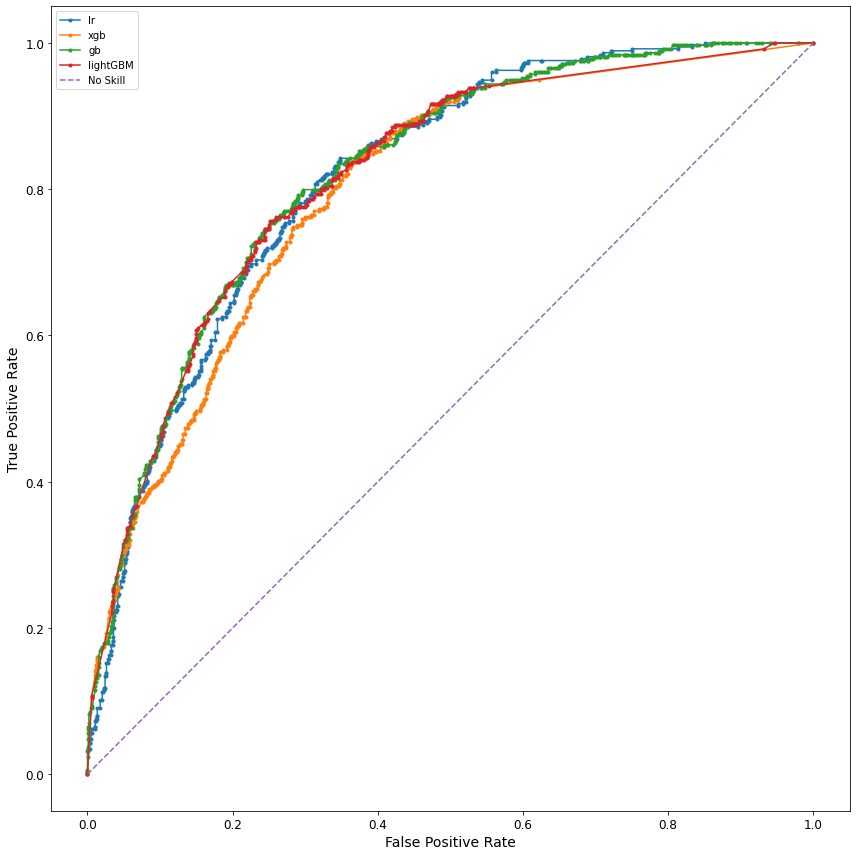

In [101]:
plot_roc_curves('roc_curves_for_oversample',sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)

In [102]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

Based on the data we can see based on the precision and recall threshold we can see that models such as XGB and Light GBM are not very sensitive in terms of precision recall threshold until you go to higher threshold numbers. While Logistic regression and Gradient boosting give estimates that are more spread out hence the recall/precision changes according to the decision threshold

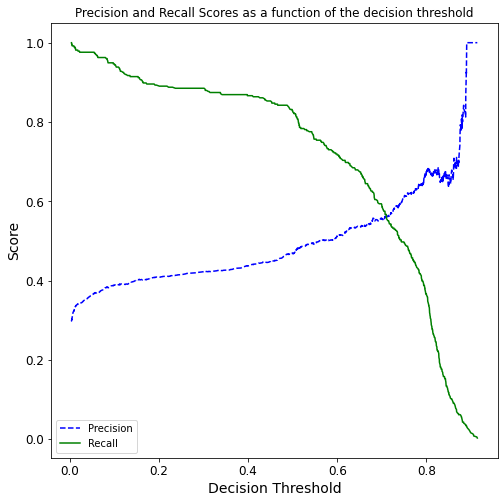

C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




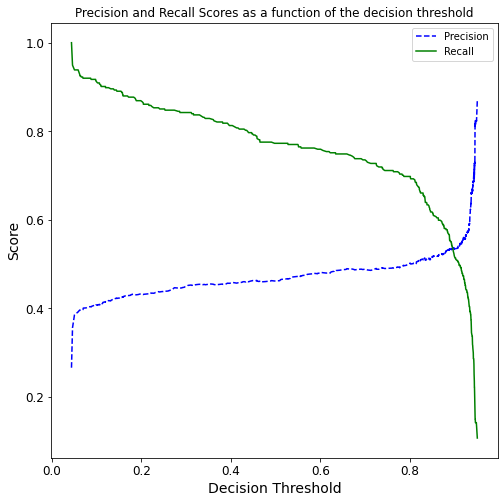

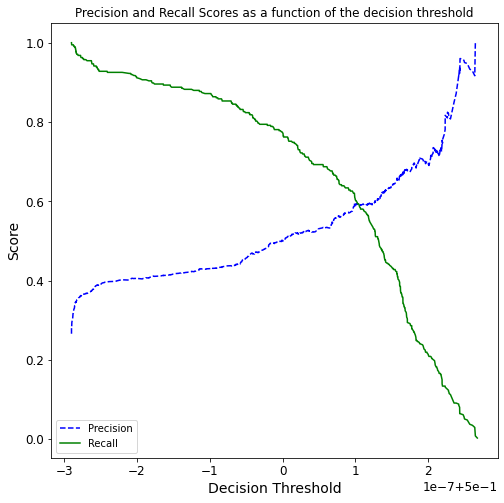

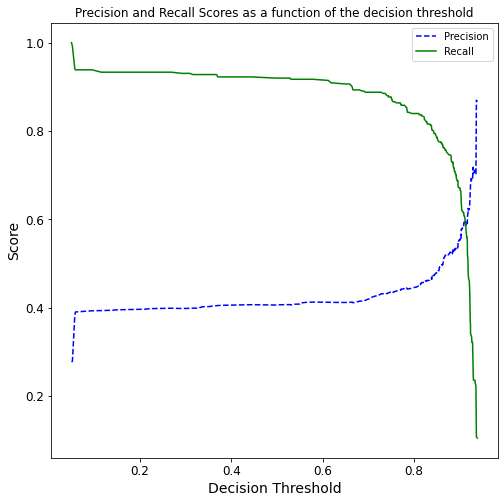

In [103]:
for model in models:
    key = model
    model = models[model]
    model.fit(sample_x_over, sample_y_over)
    y_scores = model.predict_proba(strat_test_set_x)
    # keep probabilities for the positive outcome only
    y_scores = y_scores[:, 1]
    precision, recall, thresholds = precision_recall_curve(strat_test_set_y, y_scores)
    plot_precision_recall_vs_threshold(precision, recall, thresholds)
    plt.show()

# Base Threshold
Contributor(s): @HishamSalem

We look at the results for machine learning models with their default classification threshold.

lr


C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


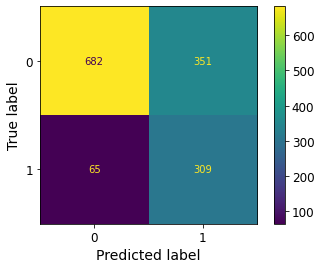

xgb
[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


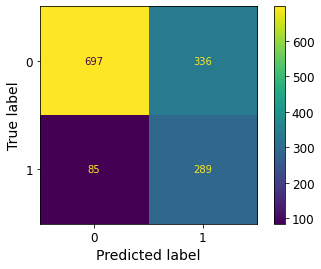

gb


C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


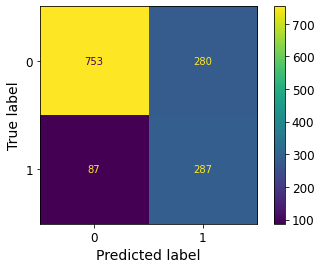

C:\Users\hisha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


lightGBM


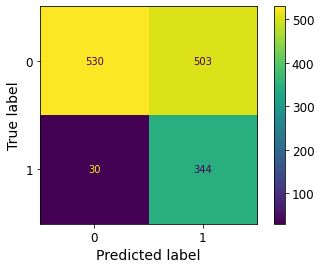

In [104]:
Base_Thresh={}
for model in models:  
    key=model
    print(key)
    model=models[model]
    model.fit(sample_x_over, sample_y_over)
    Base_Thresh["{0}".format(key)]=model.predict(strat_test_set_x)
    plot_confusion_matrix(model,strat_test_set_x,strat_test_set_y)
    plt.show()

In [105]:
strat_test_set_Base = df_selected.iloc[test_index]
strat_test_set_Base['Logistic Regression']=Base_Thresh['lr']
strat_test_set_Base['XGB']=Base_Thresh['xgb']
strat_test_set_Base['Light GBM']=Base_Thresh['lightGBM']
strat_test_set_Base['Gradient Boosting']=Base_Thresh['gb']

C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

# Optimal F1 Score Threshold
Contributor(s): @HishamSalem

Since our goal is to maximize F1-Score, we get the custom threshold for our machine learning models. These models give better F1-scores compared to the base thresholds.

Saving figure precision_recall_for_oversample


C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_oversample
Saving figure precision_recall_for_oversample


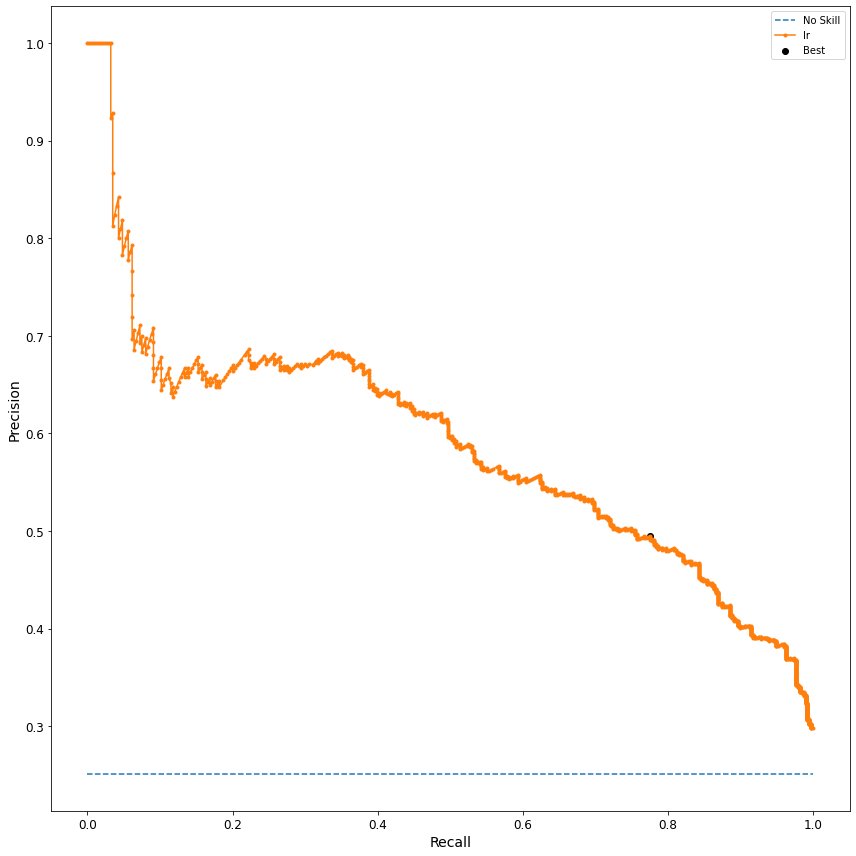

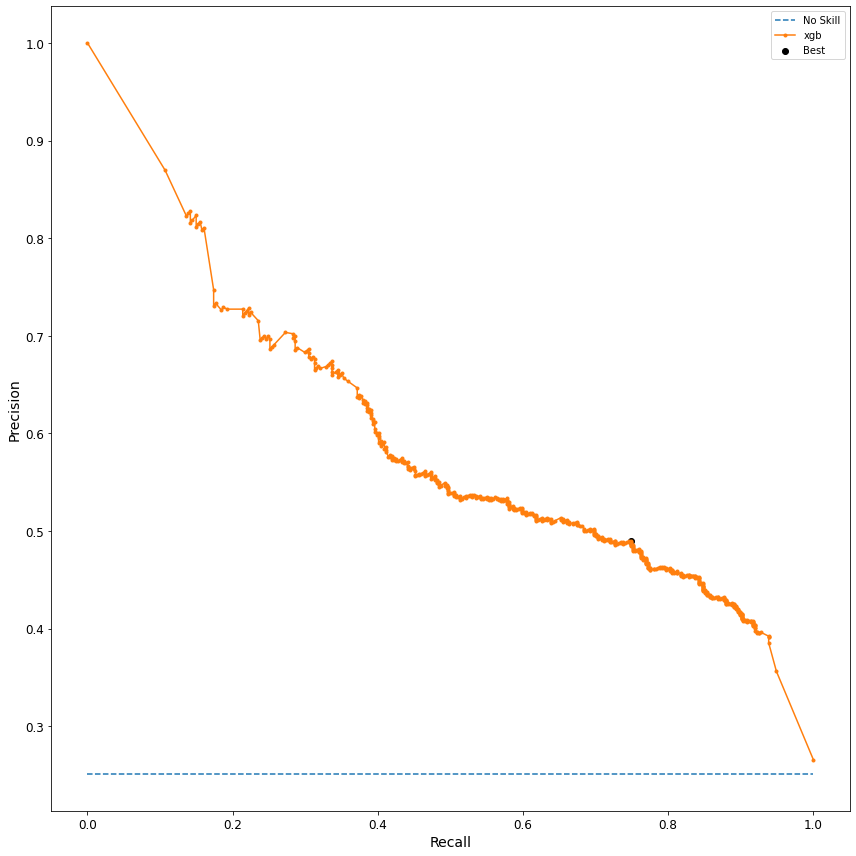

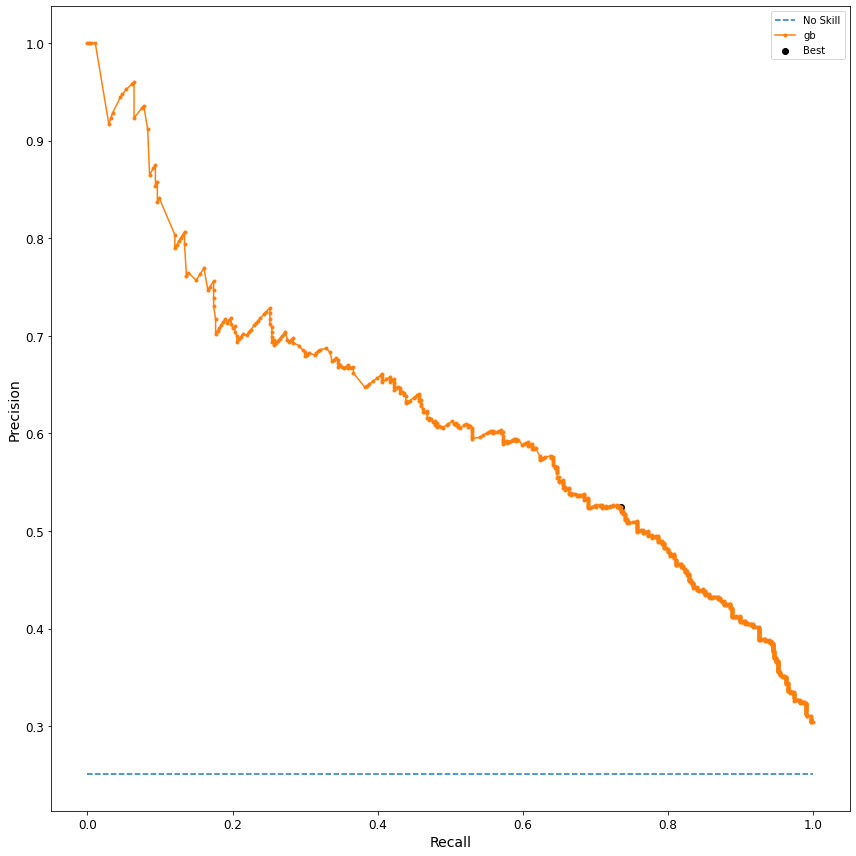

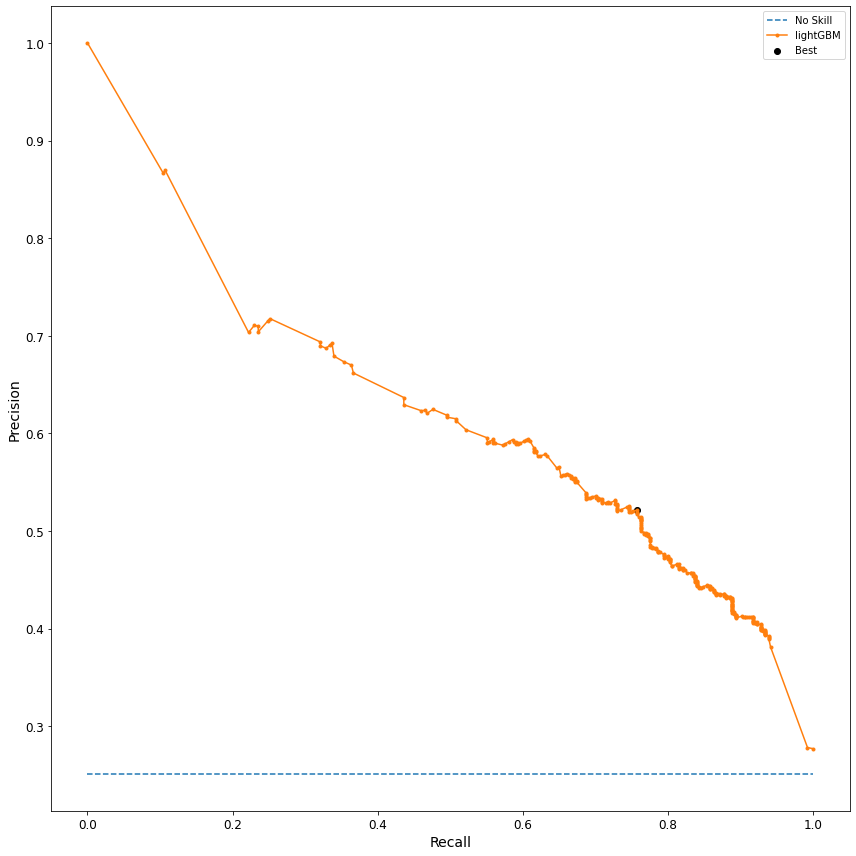

In [106]:
TunedModelsCustomThresh = plot_precision_recall('precision_recall_for_oversample', sample_x_over, sample_y_over, strat_test_set_x, strat_test_set_y)

Here are the numerical numbers for getting the most optimal numbers for maximizing f1 Score.

In [107]:
TunedModelsCustomThresh

Recall  Precision    Fscore  Threshold
lr        0.775401   0.494881  0.604167   0.542832
xgb       0.748663   0.489510  0.591966   0.659565
gb        0.735294   0.524809  0.612472   0.500000
lightGBM  0.756684   0.521179  0.617230   0.870174

Here are our confusion matrixes. We can ultimately see that lightgbm is the best model in terms of F1 Score

lr
xgb
[00:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\hisha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


gb
lightGBM


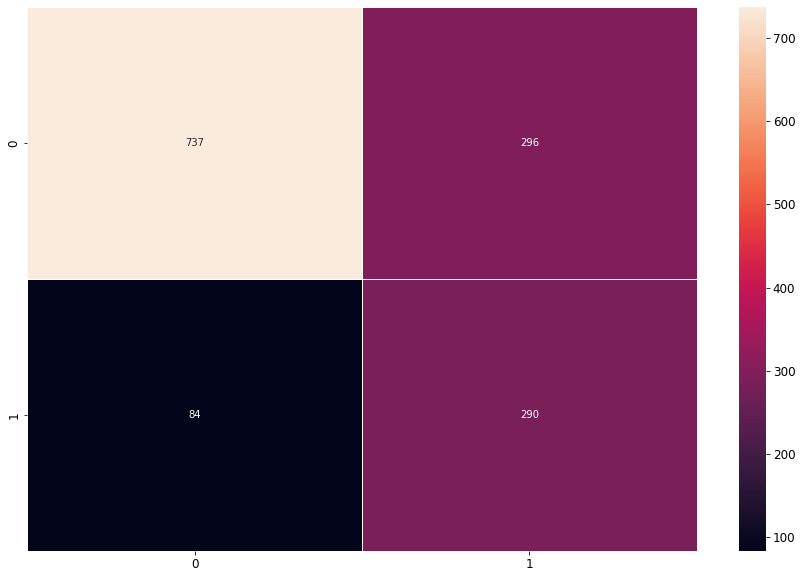

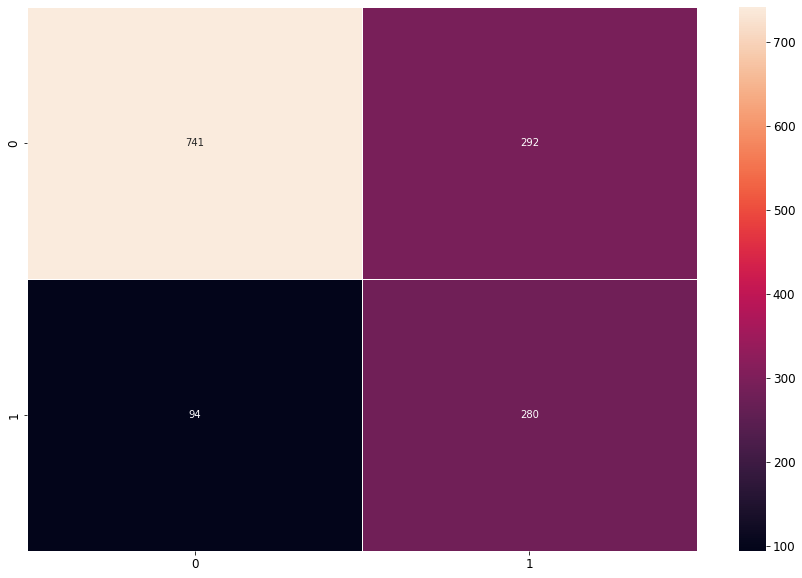

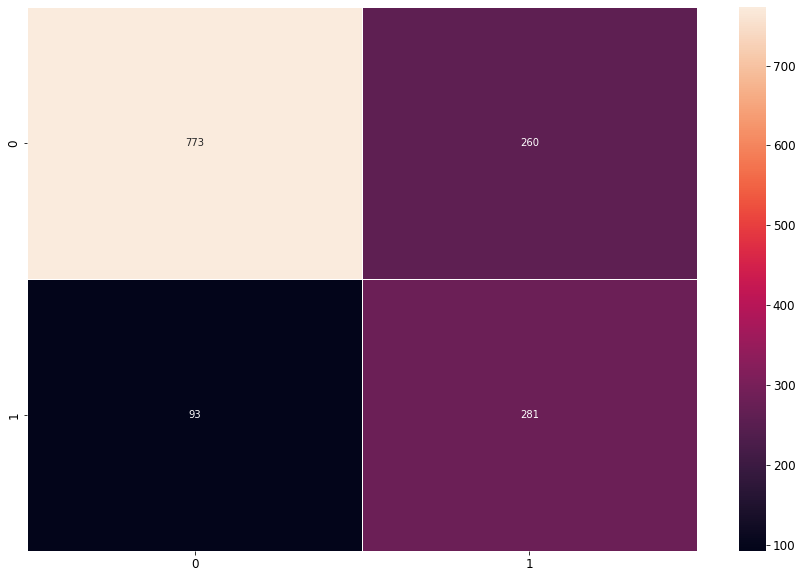

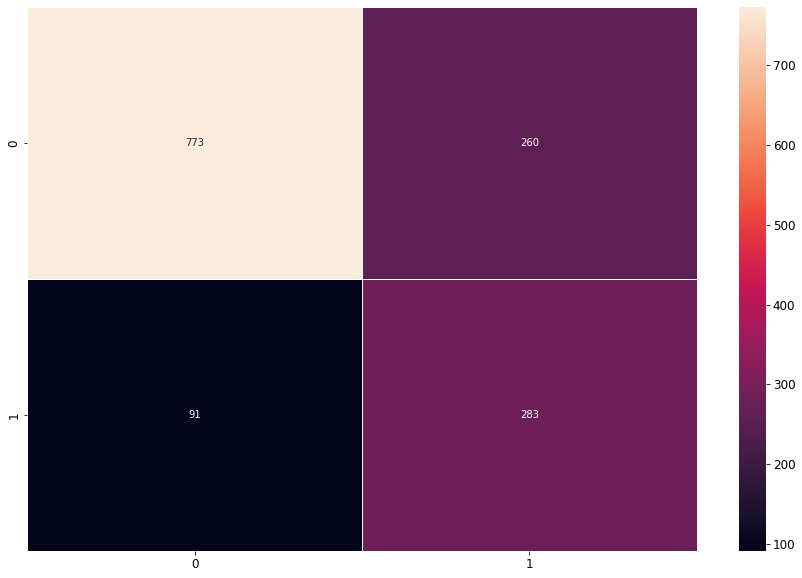

In [108]:
Custom_Thresh={}
j=0
for model in models:      
    key=model
    print(key)
    model=models[model]
    model.fit(sample_x_over, sample_y_over)
    Custom_Thresh["{0}".format(key)]=model.predict_proba(strat_test_set_x)
    Custom_Thresh["{0}".format(key)]=Custom_Thresh["{0}".format(key)][:,1]
    for i in range(len(Custom_Thresh["{0}".format(key)])):
        if Custom_Thresh["{0}".format(key)][i]>=TunedModelsCustomThresh['Threshold'][j]:
            Custom_Thresh["{0}".format(key)][i]=1
        else:
            Custom_Thresh["{0}".format(key)][i]=0
    j+=1
    cf_matrix = confusion_matrix(strat_test_set_y, Custom_Thresh["{0}".format(key)])
    fig, ax = plt.subplots(figsize=(15,10)) 
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [77]:
strat_test_set_custom_Threshold = df_selected.iloc[test_index]
strat_test_set_custom_Threshold['Logistic Regression']=Custom_Thresh['lr']
strat_test_set_custom_Threshold['XGB']=Custom_Thresh['xgb']
strat_test_set_custom_Threshold['Light GBM']=Custom_Thresh['lightGBM']
strat_test_set_custom_Threshold['Gradient Boosting']=Custom_Thresh['gb']

C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [78]:
strat_test_set_custom_Threshold_Merged=pd.merge(df, strat_test_set_custom_Threshold, left_index=True, right_index=True)

In [79]:
strat_test_set_custom_Threshold_Merged=strat_test_set_custom_Threshold_Merged.drop(['Churn_x','tenure_x','MonthlyCharges_x','MonthlyCharges_x'],axis=1)
strat_test_set_custom_Threshold_Merged=strat_test_set_custom_Threshold_Merged.rename(columns={'tenure_y': 'tenure',
                                                  'Contract_y': 'Contract',
                                                  'MonthlyCharges_y': 'MonthlyCharges', 
                                                  'Churn_y': 'Churn'})

In [80]:
strat_test_set_Base_Merged=pd.merge(df, strat_test_set_Base, left_index=True, right_index=True)

In [81]:
strat_test_set_Base_Merged

Churn_x  gender  SeniorCitizen  Partner  Dependents  tenure_x  \
6           0       0              0        0           1        22   
7           0       1              0        0           0        10   
9           0       0              0        0           1        62   
14          0       0              0        0           0        25   
18          1       1              0        1           1        10   
...       ...     ...            ...      ...         ...       ...   
7016        0       1              0        0           0         1   
7023        0       1              1        1           0        63   
7024        0       0              0        1           0        44   
7033        0       0              0        0           0        38   
7036        0       1              0        0           0        12   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
6                1              2                2               1  ...   
7                0             -1                1               2  ...   
9                1              1                1               2  ...   
14               1              1                2               2  ...   
18               1              1                1               1  ...   
...            ...            ...              ...             ...  ...   
7016             1              1                1               1  ...   
7023             1              2                2               1  ...   
7024             1              2                2               2  ...   
7033             1              1                2               1  ...   
7036             0             -1                1               1  ...   

      MonthlyCharges_x  TotalCharges  tenure_y  Contract_y  MonthlyCharges_y  \
6                89.10       1949.40        22           1             89.10   
7                29.75        301.90        10           1             29.75   
9                56.15       3487.95        62           2             56.15   
14              105.50       2686.05        25           1            105.50   
18               55.20        528.35        10           1             55.20   
...                ...           ...       ...         ...               ...   
7016             49.95         49.95         1           1             49.95   
7023            103.50       6479.40        63           1            103.50   
7024             84.80       3626.35        44           1             84.80   
7033             69.50       2625.25        38           1             69.50   
7036             60.65        743.30        12           2             60.65   

      Churn_y  Logistic Regression  XGB  Light GBM  Gradient Boosting  
6           0                    1    0          1                  1  
7           0                    1    1          1                  1  
9           0                    0    0          0                  0  
14          0                    1    1          1                  1  
18          1                    1    0          1                  0  
...       ...                  ...  ...        ...                ...  
7016        0                    1    1          1                  1  
7023        0                    1    1          1                  1  
7024        0                    1    1          1                  1  
7033        0                    1    0          1                  1  
7036        0                    0    0          0                  0  

[1407 rows x 31 columns]

In [82]:
strat_test_set_Base_Merged=strat_test_set_Base_Merged.drop(['Churn_x','tenure_x','MonthlyCharges_x','MonthlyCharges_x'],axis=1)
strat_test_set_Base_Merged=strat_test_set_Base_Merged.rename(columns={'tenure_y': 'tenure',
                                                  'Contract_y': 'Contract',
                                                  'MonthlyCharges_y': 'MonthlyCharges', 
                                                  'Churn_y': 'Churn'})

In [83]:
strat_test_set_Base_Merged.to_csv('Base.csv')

In [84]:
strat_test_set_custom_Threshold_Merged.to_csv('CustomThreshold.csv')

# Decision Optimization
Contributor(s): @NathanMurstein, @jeewonk

Based on our models' output, we want to send coupons to the customers. Howover, due to limited marketing budget (as in most marketing scenarios), we would only like to send coupons to the customers that provide the highest monthly charges. Therefore, we use an optimization model to optimize a list of customers to send a coupon to to minimize churn using predictions from each algorithm. Then, using the ground truth, we evaluate the realized loss in dollars for each coupon targeting list (generated from optimizing using each algorithm's predictions), to determine which model would lead to the superior optimized coupon targeting list.


**Target:** Selectively send coupons to the customers that are likely to churn that bring in the highest revenue.

## Model Formulation

### Parameters

$Mailingcost_{i}$$_{(i = 1, ..., 7043)}$: Cost of sending coupon to customer $i$. 

$Charges_{i}$$_{(i = 1, ..., 7043)}$: Monthly charge of customer $i$. 

$predChurned_{i}$$_{(i = 1, ..., 7043)}$: Whether the customer $i$ is expected to churn or not. $predChurned_{i} = 1$ if the customer $i$ is expected to churn, otherwise $predChurned_{i} = 0$.

$Churned_{i}$$_{(i = 1, ..., 7043)}$: Whether the customer $i$ churns or not. $Churned_{i} = 1$ if the customer $i$ churns, otherwise $Churned_{i} = 0$. **(It's the Ground Truth, so we can't learn this information when we do optimization. But we will use this information when we will calculate 'the realized loss after the coupon promo.')**

Coupon_amount = $12.95: The face value per coupon. The value came from 20% of mean value of Monthly Charges.

Total_budget = $5,000: The given total budget for the sum of coupon amount.



### Decision Variables

$Coupon_{i}$$_{(i = 1, ..., 7043)}$: Whether to send customer $i$ a coupon. $Coupon_{i} = 1$ if Telco decides to send coupon to customer $i$, otherwise $Coupon_{i} = 0$.



### Objective Function

- **Maximizing marginal value (Minimizing expected loss)**. We can interpret this problem as to maximize the marginal value with coupon promotion. It can be represented as the sum of 'The margin contribution of customer $i$ after the coupon promotion.'

* if $Churned_{i} = 1$ and $Coupon_{i} = 1$, the marginal value of the customer $i$ can be '$Charges_{i}$ - $Mailingcost_{i}$ - Coupon amount'. (*We assumed that the expected retention rate of customer would be 100% when Telco sends coupon*)
    
* if $Churned_{i} = 1$ and $Coupon_{i} = 0$, the expected value of the customer will be $- Charges_{i}$.
 

### Constraints

- **Budget**. Sum of coupon cost should be less than the budget.

- **Assumption for retention**. If we send a coupon to a customer predicted to churn, the customer will not churn. If we do not send a coupon, the customer will churn.

In [85]:
import pandas as pd
import gurobipy as gp
from gurobipy import *
import numpy as np
import random
import operator

In [86]:
#import predictions of base and custom threshold models, as well as ground truth churn and montly charges
ground_truth = pd.read_csv('Base.csv').iloc[:,23:25]
base_threshold_pred = pd.read_csv('Base.csv').iloc[:,25:].add_prefix('pred_base_')
custom_threshold_pred = pd.read_csv('CustomThreshold.csv').iloc[:,25:].add_prefix('pred_custom_')
churn_df = pd.concat([ground_truth, base_threshold_pred, custom_threshold_pred], axis = 1)
churn_df.insert(0, 'Customer_ID', range(1, 1 + len(churn_df)))
churn_df.head()

Customer_ID  MonthlyCharges  Churn  pred_base_Logistic Regression  \
0            1           89.10      0                              1   
1            2           29.75      0                              1   
2            3           56.15      0                              0   
3            4          105.50      0                              1   
4            5           55.20      1                              1   

   pred_base_XGB  pred_base_Light GBM  pred_base_Gradient Boosting  \
0              0                    1                            1   
1              1                    1                            1   
2              0                    0                            0   
3              1                    1                            1   
4              0                    1                            0   

   pred_custom_Logistic Regression  pred_custom_XGB  pred_custom_Light GBM  \
0                              1.0              0.0                    1.0   
1                              0.0              1.0                    1.0   
2                              0.0              0.0                    0.0   
3                              1.0              1.0                    1.0   
4                              1.0              0.0                    0.0   

   pred_custom_Gradient Boosting  
0                            1.0  
1                            1.0  
2                            0.0  
3                            1.0  
4                            0.0

In [87]:
# define a function to use optimiztion as described above to output list of companies to send coupons to for each set of predictions

def optimize_targeting(churn_df, model):
    '''
    Based on churn predicted by a certain given model (i.e. custom threshold gradient boosting), and certain assumptions,
    optimizes targeting of coupons to a specific subset of customers to maximize marginal value.
    '''
    # Parameters 
    predChurn = list(churn_df[model])
    charges = list(churn_df['MonthlyCharges'])
    customers = list(churn_df['Customer_ID'])

    ### Assumptions ###
    # If a company churns, it's monthly value will be zero. If it doeesn't churn, it will be equal to the previous month's value
    # If we send a 20% coupon to a customer predicted to churn, the customer will not churn. If we do not send a coupon, the customer will churn.

    mailing_cost = list(np.random.randint(low = 2, high = 5,size = len(predChurn)))
    coupon_amount = churn_df.MonthlyCharges.mean()*0.20
    total_budget = 5000
    
    model = gp.Model("Churn Optimization")
    
    #expected number of customers receive coupons
    total_budget/coupon_amount
    
    # Decision Variables
    coupon = model.addVars(len(predChurn), vtype = GRB.BINARY, name = ['Send coupon to customer ' + str(i) for i in customers])
    
    # Objective Function (see explanation below)

    marginal_value = sum(coupon[i]*(charges[i] - mailing_cost[i] - coupon_amount) - 
                     (1 - coupon[i])*predChurn[i]*charges[i] for i in range(len(predChurn)))

    model.setObjective(marginal_value, GRB.MAXIMIZE) 
    
    # Constraints

    #budget
    model.addConstr(sum(coupon_amount * coupon[i] for i in range(len(predChurn))) <= total_budget)

    #if you give coupon, the churn should be 0
    for i in range(len(predChurn)):
        model.addConstr((1 - coupon[i]) >= predChurn[i])
        
    model.setParam('TimeLimit', 2*60)
    model.optimize()
    
    customer_coupon = []
    for v in model.getVars():
        if v.x !=0:
            customer_coupon.append(v.varName)
            
    tgt_customer = []
    for i in range(len(customer_coupon)):
        tgt_customer.append(int(re.search(r'\d+', customer_coupon[i]).group(0)))
        
    return tgt_customer

In [88]:
models = list(base_threshold_pred.columns) + list(custom_threshold_pred.columns) #list of model names

# create dataframe to store coupon targeting lists for each model
prediction_targeting_optimized = pd.DataFrame(models, columns = ['model'])

#run optimization function to obtain lists
prediction_targeting_optimized['coupon_target'] = prediction_targeting_optimized['model'].apply(lambda x: optimize_targeting(churn_df, x))

Academic license - for non-commercial use only - expires 2022-03-18
Using license file C:\Users\hisha\gurobi.lic
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads
Optimize a model with 1408 rows, 1407 columns and 2814 nonzeros
Model fingerprint: 0x763d4baf
Variable types: 0 continuous, 1407 integer (1407 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective -31101.54819
Presolve removed 1407 rows and 878 columns
Presolve time: 0.00s
Presolved: 1 rows, 529 columns, 529 nonzeros
Variable types: 0 continuous, 529 integer (400 binary)

Root relaxation: objective -1.988235e+04, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     

In [89]:
prediction_targeting_optimized

model  \
0    pred_base_Logistic Regression   
1                    pred_base_XGB   
2              pred_base_Light GBM   
3      pred_base_Gradient Boosting   
4  pred_custom_Logistic Regression   
5                  pred_custom_XGB   
6            pred_custom_Light GBM   
7    pred_custom_Gradient Boosting   

                                       coupon_target  
0  [3, 7, 10, 26, 29, 32, 36, 45, 46, 49, 55, 57,...  
1  [1, 9, 10, 22, 26, 29, 36, 45, 46, 48, 49, 52,...  
2  [3, 10, 13, 26, 29, 36, 43, 46, 49, 55, 57, 59...  
3  [10, 25, 26, 29, 32, 36, 45, 46, 49, 52, 55, 5...  
4  [3, 7, 10, 26, 29, 32, 36, 45, 46, 48, 49, 55,...  
5  [1, 9, 22, 26, 29, 32, 36, 45, 46, 48, 49, 54,...  
6  [26, 29, 32, 36, 45, 46, 48, 49, 52, 55, 59, 6...  
7  [10, 14, 25, 26, 29, 32, 36, 45, 46, 49, 52, 5...

In [90]:
# create binary columns for whether each customer gets a coupon according to the optimization for each model's set of predictions
churn_df = churn_df.join(pd.DataFrame({model_name.replace('pred_', 'coupon_'): 0 for model_name in models}, index = churn_df.index))

# using prediction_targeting_optimized dataframe, fill binary columns 
coupon_lists = list(churn_df.iloc[:,11:].columns)
for model, target_list in zip(coupon_lists, prediction_targeting_optimized['coupon_target']):
    for customer_id in target_list:
        churn_df.loc[customer_id-1, model] = 1
    
churn_df.head()

Customer_ID  MonthlyCharges  Churn  pred_base_Logistic Regression  \
0            1           89.10      0                              1   
1            2           29.75      0                              1   
2            3           56.15      0                              0   
3            4          105.50      0                              1   
4            5           55.20      1                              1   

   pred_base_XGB  pred_base_Light GBM  pred_base_Gradient Boosting  \
0              0                    1                            1   
1              1                    1                            1   
2              0                    0                            0   
3              1                    1                            1   
4              0                    1                            0   

   pred_custom_Logistic Regression  pred_custom_XGB  pred_custom_Light GBM  \
0                              1.0              0.0                    1.0   
1                              0.0              1.0                    1.0   
2                              0.0              0.0                    0.0   
3                              1.0              1.0                    1.0   
4                              1.0              0.0                    0.0   

   pred_custom_Gradient Boosting  coupon_base_Logistic Regression  \
0                            1.0                                0   
1                            1.0                                0   
2                            0.0                                1   
3                            1.0                                0   
4                            0.0                                0   

   coupon_base_XGB  coupon_base_Light GBM  coupon_base_Gradient Boosting  \
0                1                      0                              0   
1                0                      0                              0   
2                0                      1                              0   
3                0                      0                              0   
4                0                      0                              0   

   coupon_custom_Logistic Regression  coupon_custom_XGB  \
0                                  0                  1   
1                                  0                  0   
2                                  1                  0   
3                                  0                  0   
4                                  0                  0   

   coupon_custom_Light GBM  coupon_custom_Gradient Boosting  
0                        0                                0  
1                        0                                0  
2                        0                                0  
3                        0                                0  
4                        0                                0

In [91]:
churn_df

Customer_ID  MonthlyCharges  Churn  pred_base_Logistic Regression  \
0               1           89.10      0                              1   
1               2           29.75      0                              1   
2               3           56.15      0                              0   
3               4          105.50      0                              1   
4               5           55.20      1                              1   
...           ...             ...    ...                            ...   
1402         1403           49.95      0                              1   
1403         1404          103.50      0                              1   
1404         1405           84.80      0                              1   
1405         1406           69.50      0                              1   
1406         1407           60.65      0                              0   

      pred_base_XGB  pred_base_Light GBM  pred_base_Gradient Boosting  \
0                 0                    1                            1   
1                 1                    1                            1   
2                 0                    0                            0   
3                 1                    1                            1   
4                 0                    1                            0   
...             ...                  ...                          ...   
1402              1                    1                            1   
1403              1                    1                            1   
1404              1                    1                            1   
1405              0                    1                            1   
1406              0                    0                            0   

      pred_custom_Logistic Regression  pred_custom_XGB  pred_custom_Light GBM  \
0                                 1.0              0.0                    1.0   
1                                 0.0              1.0                    1.0   
2                                 0.0              0.0                    0.0   
3                                 1.0              1.0                    1.0   
4                                 1.0              0.0                    0.0   
...                               ...              ...                    ...   
1402                              1.0              1.0                    1.0   
1403                              1.0              1.0                    1.0   
1404                              1.0              1.0                    1.0   
1405                              1.0              0.0                    0.0   
1406                              0.0              0.0                    0.0   

      pred_custom_Gradient Boosting  coupon_base_Logistic Regression  \
0                               1.0                                0   
1                               1.0                                0   
2                               0.0                                1   
3                               1.0                                0   
4                               0.0                                0   
...                             ...                              ...   
1402                            1.0                                0   
1403                            1.0                                0   
1404                            1.0                                0   
1405                            0.0                                0   
1406                            0.0                                1   

      coupon_base_XGB  coupon_base_Light GBM  coupon_base_Gradient Boosting  \
0                   1                      0                              0   
1                   0                      0                              0   
2                   0                      1                              0   
3                   0                      0                              

In [92]:
Churned = list(churn_df['Churn']) # list of ground truth churn values

model_values = {} # initialize dictionary to hold expected savings for each model

# iterate through each model, and calculate the expected savings by using optimized coupon strategy
for coupon_list in coupon_lists:
    
    coupon_targets = list(churn_df[coupon_list]) 
    
    predChurn = list(churn_df[coupon_list])
    charges = list(churn_df['MonthlyCharges'])
    mailing_cost = list(np.random.randint(low = 2, high = 5,size = len(predChurn)))
    coupon_amount = churn_df.MonthlyCharges.mean()*0.20
    
    #IF Telco send coupon, the realized loss for this month would be:
    real_value = sum(coupon_targets[i]*(charges[i] - mailing_cost[i] - coupon_amount) - (1 - coupon_targets[i])*Churned[i]*charges[i] for i in range(len(Churned)))
    
    #IF Telco doesn't send coupon, the expected loss for this month would be:
    exp_loss = -sum(churn_df.Churn[i] * churn_df.MonthlyCharges[i] for i in range(len(churn_df)))
    
    upside = real_value - exp_loss 
    
    model_name = coupon_list.replace('coupon_', '')
    
    model_values[model_name] = upside # update dictionary
    
    print("Using " + coupon_list.replace('coupon_', '') + ", we can save", "%.2f" % upside, "dollars from the expected loss of upcoming month with the coupon promotion.")

Using base_Logistic Regression, we can save 31433.10 dollars from the expected loss of upcoming month with the coupon promotion.
Using base_XGB, we can save 33576.85 dollars from the expected loss of upcoming month with the coupon promotion.
Using base_Light GBM, we can save 24032.70 dollars from the expected loss of upcoming month with the coupon promotion.
Using base_Gradient Boosting, we can save 32844.80 dollars from the expected loss of upcoming month with the coupon promotion.
Using custom_Logistic Regression, we can save 31798.40 dollars from the expected loss of upcoming month with the coupon promotion.
Using custom_XGB, we can save 34355.45 dollars from the expected loss of upcoming month with the coupon promotion.
Using custom_Light GBM, we can save 33565.20 dollars from the expected loss of upcoming month with the coupon promotion.
Using custom_Gradient Boosting, we can save 33033.15 dollars from the expected loss of upcoming month with the coupon promotion.


In [93]:
# sort dictionary to obtain best model according to expected savings using optimized coupon strategy
best_models = sorted(model_values.items(), key = operator.itemgetter(1), reverse = True)
best_models

[('custom_XGB', 34355.45181236676),
 ('base_XGB', 33576.85181236675),
 ('custom_Light GBM', 33565.20181236675),
 ('custom_Gradient Boosting', 33033.151812366756),
 ('base_Gradient Boosting', 32844.80181236676),
 ('custom_Logistic Regression', 31798.401812366745),
 ('base_Logistic Regression', 31433.101812366745),
 ('base_Light GBM', 24032.70181236674)]

# In-depth EDA
**Contributor(s):** @oleg19989, @JuniperZhuDiwei

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

### Overview of data structure

In [ ]:
df = pd.read_csv("Churn_Processed_EDA_causality.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.head(5)

Churn  gender  ...  MonthlyCharges  TotalCharges
0      0       1  ...           29.85         29.85
1      0       0  ...           56.95       1889.50
2      1       0  ...           53.85        108.15
3      0       0  ...           42.30       1840.75
4      1       1  ...           70.70        151.65

[5 rows x 23 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Churn                                    7032 non-null   int64  
 1   gender                                   7032 non-null   int64  
 2   SeniorCitizen                            7032 non-null   int64  
 3   Partner                                  7032 non-null   int64  
 4   Dependents                               7032 non-null   int64  
 5   tenure                                   7032 non-null   int64  
 6   PhoneService                             7032 non-null   int64  
 7   MultipleLines                            7032 non-null   int64  
 8   InternetService                          7032 non-null   int64  
 9   OnlineSecurity                           7032 non-null   int64  
 10  OnlineBackup                             7032 no

In [ ]:
df.describe()

Churn       gender  ...  MonthlyCharges  TotalCharges
count  7032.000000  7032.000000  ...     7032.000000   7032.000000
mean      0.265785     0.495307  ...       64.798208   2283.300441
std       0.441782     0.500014  ...       30.085974   2266.771362
min       0.000000     0.000000  ...       18.250000     18.800000
25%       0.000000     0.000000  ...       35.587500    401.450000
50%       0.000000     0.000000  ...       70.350000   1397.475000
75%       1.000000     1.000000  ...       89.862500   3794.737500
max       1.000000     1.000000  ...      118.750000   8684.800000

[8 rows x 23 columns]

### Visulization of data distribution

#### Categorical/binary variables

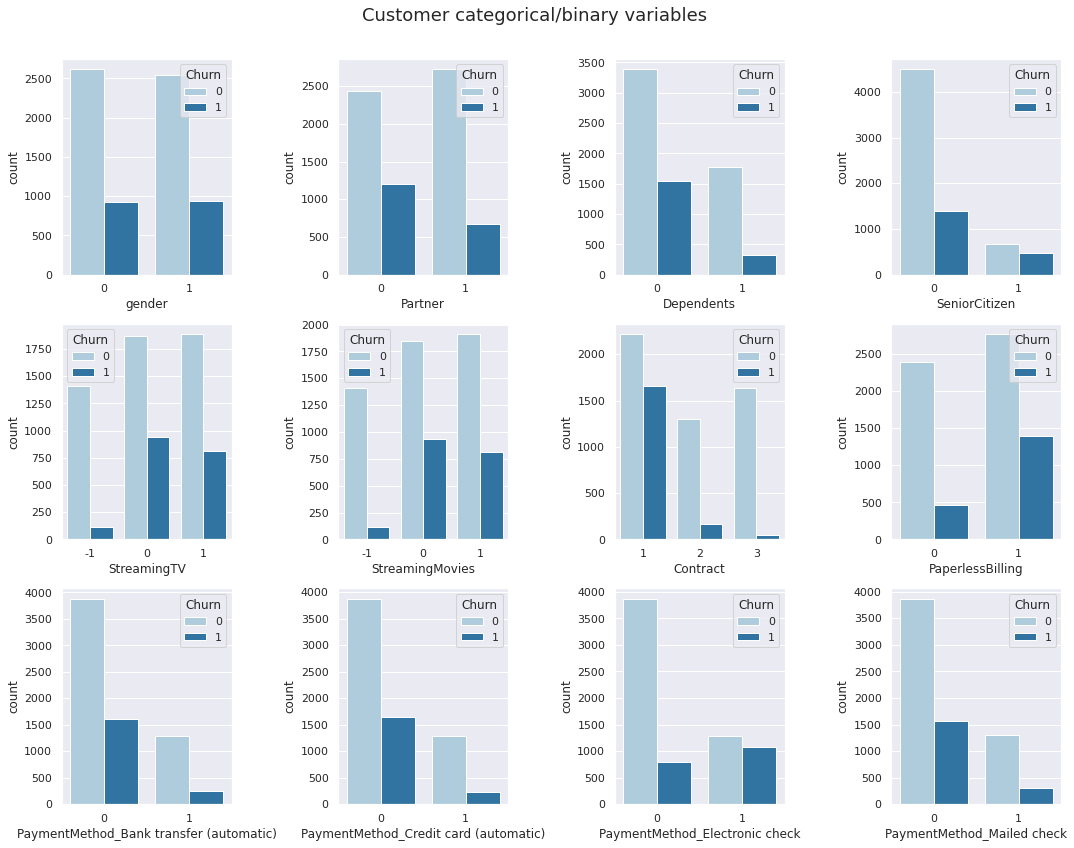

In [ ]:
# customer demographics and subscription choices
sns.set(style='darkgrid')
sns.set_palette("Paired")

fig, ax = plt.subplots(3, 4, figsize=(15, 12))
sns.countplot(data=df, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df, x='Dependents', hue='Churn', ax=ax[0][2])
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', ax=ax[0][3])
sns.countplot(data=df, x='StreamingTV', hue='Churn', ax=ax[1][0])
sns.countplot(data=df, x='StreamingMovies', hue='Churn', ax=ax[1][1])
sns.countplot(data=df, x='Contract', hue='Churn', ax=ax[1][2])
sns.countplot(data=df, x='PaperlessBilling', hue='Churn', ax=ax[1][3])
sns.countplot(data=df, x='PaymentMethod_Bank transfer (automatic)', hue='Churn', ax=ax[2][0])
sns.countplot(data=df, x='PaymentMethod_Credit card (automatic)', hue='Churn', ax=ax[2][1])
sns.countplot(data=df, x='PaymentMethod_Electronic check', hue='Churn', ax=ax[2][2])
sns.countplot(data=df, x='PaymentMethod_Mailed check', hue='Churn', ax=ax[2][3])

plt.tight_layout()
plt.suptitle("Customer categorical/binary variables", fontsize = 18)
plt.subplots_adjust(top=0.92)
plt.show()

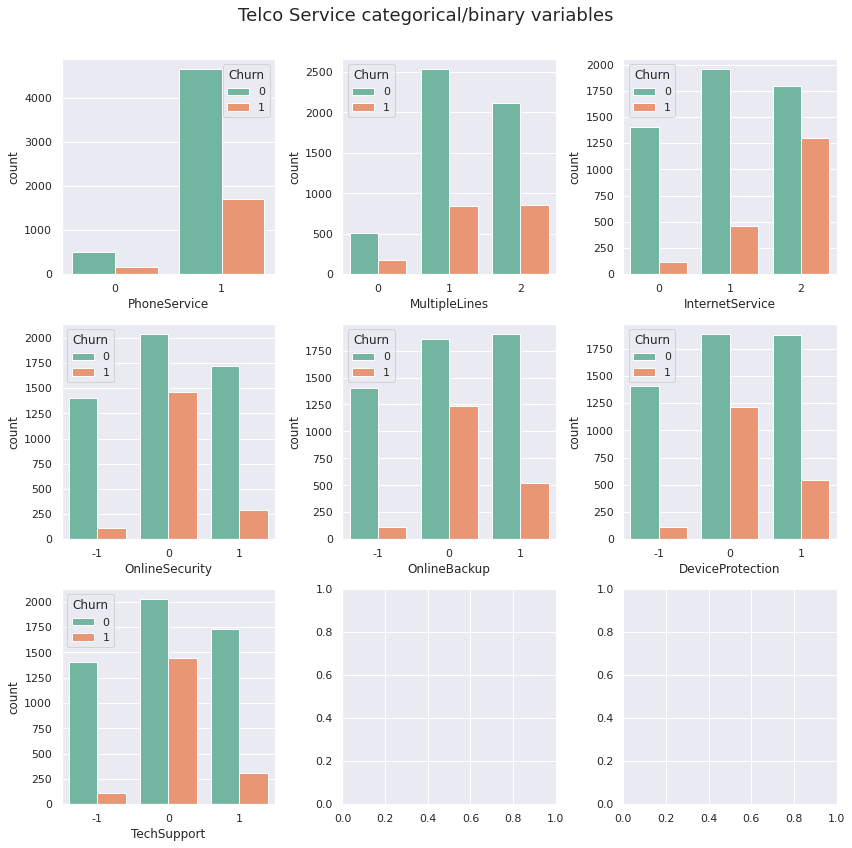

In [ ]:
# Telco services type received by customers
sns.set(style='darkgrid')
sns.set_palette("Set2")

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
sns.countplot(data=df, x='PhoneService', hue='Churn', ax=ax[0][0])
sns.countplot(data=df, x='MultipleLines', hue='Churn', ax=ax[0][1])
sns.countplot(data=df, x='InternetService', hue='Churn', ax=ax[0][2])
sns.countplot(data=df, x='OnlineSecurity', hue='Churn', ax=ax[1][0])
sns.countplot(data=df, x='OnlineBackup', hue='Churn', ax=ax[1][1])
sns.countplot(data=df, x='DeviceProtection', hue='Churn', ax=ax[1][2])
sns.countplot(data=df, x='TechSupport', hue='Churn', ax=ax[2][0])

plt.tight_layout()
plt.suptitle("Telco Service categorical/binary variables", fontsize = 18)
plt.subplots_adjust(top=0.92)
plt.show()

#### Numerical variables

In [ ]:
# numerical dataset
# divide dataset by left and stayed customers
df_num = df[["tenure","MonthlyCharges","TotalCharges","Churn"]]
df_num_leave = df_num[df_num["Churn"]==1]
df_num_stay = df_num[df_num["Churn"]==0]

mth_leave = df_num_leave["MonthlyCharges"]
mth_stay = df_num_stay["MonthlyCharges"]
total_leave = df_num_leave["TotalCharges"]
total_stay = df_num_stay["TotalCharges"]
tenure_leave = df_num_leave["tenure"]
tenure_stay = df_num_stay["tenure"]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


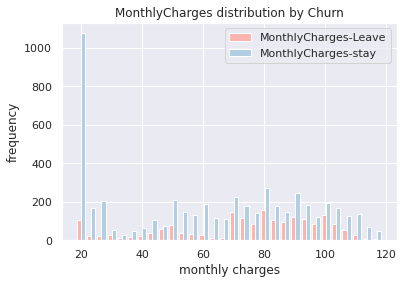

In [ ]:
sns.set(style='darkgrid')
sns.set_palette("Pastel1")

plt.hist([mth_leave, mth_stay], bins=30, alpha=1, label=['MonthlyCharges-Leave','MonthlyCharges-stay'])
plt.legend(loc='upper right')
plt.ylabel("frequency")
plt.xlabel("monthly charges")
plt.title("MonthlyCharges distribution by Churn")
plt.show()

The churn rate is higher when the Monthly charge ranges from ~70 to 100 dollars. Some business insights can be drawn based on this pattern.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


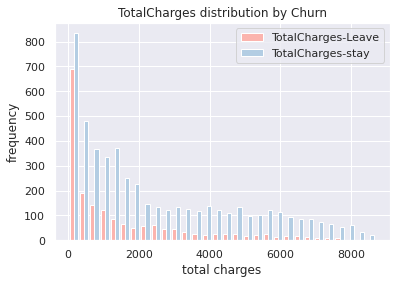

In [ ]:
plt.hist([total_leave, total_stay], bins=30, alpha=1, label=['TotalCharges-Leave','TotalCharges-stay'])
plt.legend(loc='upper right')
plt.title("TotalCharges distribution by Churn")
plt.ylabel("frequency")
plt.xlabel("total charges")
plt.show()

When the total charges is very low, the churn rate of customers are the highest. As the total charges goes higher, the customer who left decreases but the churn rate seems to remain stable.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


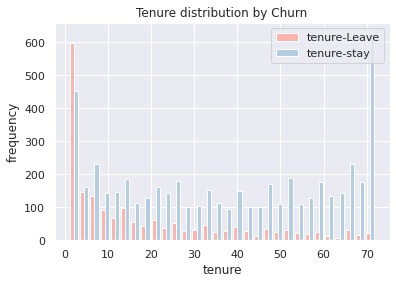

In [ ]:
plt.hist([tenure_leave, tenure_stay], bins=30, alpha=1, label=['tenure-Leave','tenure-stay'])
plt.legend(loc='upper right')
plt.title("Tenure distribution by Churn")
plt.ylabel("frequency")
plt.xlabel("tenure")
plt.show()

Customers who left are usually of low tenure. Only small portion of long-time customers who left. As tenure increases, the percentage of customers who left goes down.

####  Correlations

In [ ]:
# correlations
corr_matrix = df.corr()

# check columns that show high corr with the target variable
corr_matrix["Churn"].sort_values(ascending=False)

# Non of the predictors has strong (>0.8 or <-0.8) correlation with the target variable. 

Churn                                      1.000000
InternetService                            0.316350
PaymentMethod_Electronic check             0.301455
MonthlyCharges                             0.192858
PaperlessBilling                           0.191454
StreamingTV                                0.164509
StreamingMovies                            0.162672
SeniorCitizen                              0.150541
DeviceProtection                           0.084402
OnlineBackup                               0.073934
MultipleLines                              0.036148
TechSupport                                0.026744
OnlineSecurity                             0.023014
PhoneService                               0.011691
gender                                     0.008545
PaymentMethod_Mailed check                -0.090773
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Credit card (automatic)     -0.134687
Partner                                   -0.149982
Dependents  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66b652bb10>,
      dtype=object)

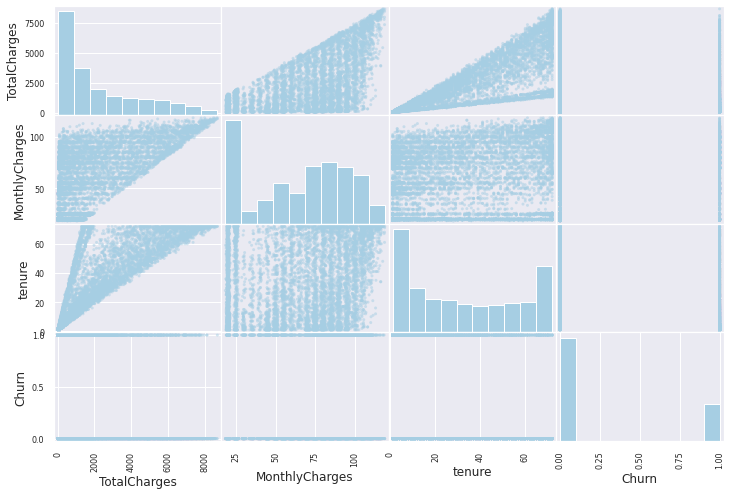

In [ ]:
sns.set_palette("Paired")
attributes = ["TotalCharges", "MonthlyCharges", "tenure","Churn"]
scatter_matrix(df[attributes], figsize=(12, 8))

# from the scatter matrix, we can observe a positive relationship between TotalCharges and MonthlyCharges, 
# and between TotalCharges and tenure. 
# This observational result fits the intuition. 

In [ ]:
# check correlation between predictors
corr_matrix.style.background_gradient(cmap='coolwarm')

Similar to the observational result from the scatter matrix, we see a strong correlation between tenure and TotalCharges (0.826), between MonthlyCharges and InternetService (0.905), StreamingTV and StreamingMovies (0.807), MonthlyCharges and StreamingTV (0.820) and StreamingMovies (0.818). <br>

These colinearities give indications that Internet Service, Streaming TV and Streaming Movies are expensive services that Telco provides. <br>

Surprisingly, MonthlyCharges and TotalCharges have no colinearity. Infer from the colinearity between TotalCharges and tenure, we can see that in order to create more long-term revenue for the company, it is more important to make sure customers subscribe for longer years rather than charging a high short-term monthly fee. 





# Causal Analysis
Contributor(s): @oleg19989, @JuniperZhuDiwei

Causal effects were studied for various categorical variables. Various Meta-learners and Neural Network algorithms were used to esitimate the Average Treatment Effects. The Average Treatment Effects calculated were in-consistent across the algorithms. 

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [ ]:
import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("Churn_Processed_EDA_causality.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.head()

Churn  gender  ...  MonthlyCharges  TotalCharges
0      0       1  ...           29.85         29.85
1      0       0  ...           56.95       1889.50
2      1       0  ...           53.85        108.15
3      0       0  ...           42.30       1840.75
4      1       1  ...           70.70        151.65

[5 rows x 23 columns]

In [ ]:
# check data type
df.dtypes

# binary features (with 0 and 1) need to be changed into Bool data type for causality check

Churn                                        int64
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
InternetService                              int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
Contract                                     int64
PaperlessBilling                             int64
PaymentMethod_Bank transfer (automatic)      int64
PaymentMethod_Credit card (automatic)        int64
PaymentMethod_Electronic check 

In [ ]:
# create separate df for different treatment causality check
df_gen = df.copy()
df_paperless = df.copy()
df_seniorcitizen = df.copy()
df_partner = df.copy()
df_dependents  = df.copy()
df_phoneservice = df.copy()
df_banktrans = df.copy()
df_credit = df.copy()
df_electronic = df.copy()
df_mailed = df.copy()

In [ ]:
# change to boolean for treatment
df_paperless['PaperlessBilling'] = df_paperless['PaperlessBilling'].astype('boolean')
df_gen['gender'] = df_gen['gender'].astype('boolean')
df_seniorcitizen['SeniorCitizen'] = df_seniorcitizen['SeniorCitizen'].astype('boolean')
df_partner['Partner'] = df_partner['Partner'].astype('boolean')
df_dependents['Dependents'] = df_dependents['Dependents'].astype('boolean')
df_phoneservice['PhoneService'] = df_phoneservice['PhoneService'].astype('boolean')
df_banktrans['PaymentMethod_Bank transfer (automatic)'] = df_banktrans['PaymentMethod_Bank transfer (automatic)'].astype('boolean')
df_credit['PaymentMethod_Credit card (automatic)'] = df_credit['PaymentMethod_Credit card (automatic)'].astype('boolean')
df_electronic['PaymentMethod_Electronic check'] = df_electronic['PaymentMethod_Electronic check'].astype('boolean')
df_mailed['PaymentMethod_Mailed check'] = df_mailed['PaymentMethod_Mailed check'].astype('boolean')

In [ ]:
# identifying target (y), control features (X), and treatment features
X = []
treatments = []
y = []
list_name = ['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
       'PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

# paperless
X_paperless = df_paperless.drop(columns = ["PaperlessBilling","Churn"])
treatment_paperless = df_paperless['PaperlessBilling']
y_paperless = df_paperless['Churn']
X.append(X_paperless)
treatments.append(treatment_paperless)
y.append(y_paperless)

# gender
X_gender = df_gen.drop(columns = ["gender","Churn"])
treatment_gender = df_gen['gender']
y_gender = df_gen['Churn']
X.append(X_gender)
treatments.append(treatment_gender)
y.append(y_gender)

# senior citizen
X_seniorcitizen = df_seniorcitizen.drop(columns = ["SeniorCitizen","Churn"])
treatment_seniorcitizen = df_seniorcitizen["SeniorCitizen"]
y_seniorcitizen = df_seniorcitizen['Churn']
X.append(X_seniorcitizen)
treatments.append(treatment_seniorcitizen)
y.append(y_seniorcitizen)

# partner
X_partner = df_partner.drop(columns = ["Partner","Churn"])
treatment_partner = df_partner['Partner']
y_partner = df_partner['Churn']
X.append(X_partner)
treatments.append(treatment_partner)
y.append(y_partner)

# dependents
X_dependents = df_dependents.drop(columns = ["Dependents","Churn"])
treatment_dependents = df_dependents['Dependents']
y_dependents = df_dependents['Churn']
X.append(X_dependents)
treatments.append(treatment_dependents)
y.append(y_dependents)

# phoneservice
X_phoneservice = df_phoneservice.drop(columns = ["PhoneService","Churn"])
treatment_phoneservice = df_phoneservice['PhoneService']
y_phoneservice = df_phoneservice['Churn']
X.append(X_phoneservice)
treatments.append(treatment_phoneservice)
y.append(y_phoneservice)

# bank transfer
X_banktrans = df_banktrans.drop(columns = ['PaymentMethod_Bank transfer (automatic)',"Churn"])
treatment_banktrans = df_banktrans['PaymentMethod_Bank transfer (automatic)']
y_banktrans = df_banktrans['Churn']
X.append(X_banktrans)
treatments.append(treatment_banktrans)
y.append(y_banktrans)

# credit
X_credit = df_credit.drop(columns = ['PaymentMethod_Credit card (automatic)',"Churn"])
treatment_credit = df_credit['PaymentMethod_Credit card (automatic)']
y_credit = df_credit['Churn']
X.append(X_credit)
treatments.append(treatment_credit)
y.append(y_credit)

# electronic
X_electronic = df_electronic.drop(columns = ['PaymentMethod_Electronic check',"Churn"])
treatment_electronic = df_electronic['PaymentMethod_Electronic check']
y_electronic = df_electronic['Churn']
X.append(X_electronic)
treatments.append(treatment_electronic)
y.append(y_electronic)

# mailed
X_mailed = df_mailed.drop(columns = ['PaymentMethod_Mailed check',"Churn"])
treatment_mailed = df_mailed['PaymentMethod_Mailed check']
y_mailed = df_mailed['Churn']
X.append(X_mailed)
treatments.append(treatment_mailed)
y.append(y_mailed)

In [ ]:
#utilizing LRSRegressor (LR) for ATE
lr = LRSRegressor()
LR_result = []

for i in range(len(X)):
    xi = X[i]
    ti = treatments[i]
    yi = y[i]
    te, lb, ub = lr.estimate_ate(xi, ti, yi)
    LR_result.append(te[0])
    print(list_name[i]+': Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

PaperlessBilling: Average Treatment Effect (Linear Regression): 0.05 (0.03, 0.07)
gender: Average Treatment Effect (Linear Regression): 0.00 (-0.01, 0.02)
SeniorCitizen: Average Treatment Effect (Linear Regression): 0.05 (0.02, 0.07)
Partner: Average Treatment Effect (Linear Regression): -0.00 (-0.02, 0.02)
Dependents: Average Treatment Effect (Linear Regression): -0.02 (-0.04, -0.00)
PhoneService: Average Treatment Effect (Linear Regression): -0.09 (-0.15, -0.03)
PaymentMethod_Bank transfer (automatic): Average Treatment Effect (Linear Regression): 0.03 (0.01, 0.05)
PaymentMethod_Credit card (automatic): Average Treatment Effect (Linear Regression): 0.03 (0.01, 0.05)
PaymentMethod_Electronic check: Average Treatment Effect (Linear Regression): 0.10 (0.08, 0.12)
PaymentMethod_Mailed check: Average Treatment Effect (Linear Regression): 0.03 (0.01, 0.05)


In [ ]:
#utilizing XGBoost for ATE
xg = XGBTRegressor(random_state=42)
XG_result = []

for i in range(len(X)):
    xi = X[i]
    ti = treatments[i]
    yi = y[i]
    te, lb, ub = xg.estimate_ate(xi, ti, yi)
    XG_result.append(te[0])
    print(list_name[i]+': Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[16:10:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
PaperlessBilling: Average Treatment Effect (XGBoost): 0.05 (0.04, 0.07)
[16:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
gender: Average Treatment Effect (XGBoost): 0.00 (-0.01, 0.02)
[16:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SeniorCitizen: Average Treatment Effect (XGBoost): 0.06 (0.04, 0.08)
[16:10:09] WARNING: /workspace/src

In [ ]:
#utilizing MPLTRegressor (Neural Network) for ATE
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
 learning_rate_init=.1,
 early_stopping=True,
 random_state=42)
NN_result = []

for i in range(len(X)):
    xi = X[i]
    ti = treatments[i]
    yi = y[i]
    te, lb, ub = nn.estimate_ate(xi, ti, yi)
    NN_result.append(te[0])
    print(list_name[i]+': Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

PaperlessBilling: Average Treatment Effect (Neural Network (MLP)): 0.13 (0.11, 0.15)
gender: Average Treatment Effect (Neural Network (MLP)): 0.01 (-0.01, 0.03)
SeniorCitizen: Average Treatment Effect (Neural Network (MLP)): -0.25 (-0.28, -0.22)
Partner: Average Treatment Effect (Neural Network (MLP)): -0.09 (-0.11, -0.07)
Dependents: Average Treatment Effect (Neural Network (MLP)): -0.09 (-0.11, -0.07)
PhoneService: Average Treatment Effect (Neural Network (MLP)): 0.24 (0.20, 0.27)
PaymentMethod_Bank transfer (automatic): Average Treatment Effect (Neural Network (MLP)): -0.05 (-0.07, -0.03)
PaymentMethod_Credit card (automatic): Average Treatment Effect (Neural Network (MLP)): -0.33 (-0.35, -0.31)
PaymentMethod_Electronic check: Average Treatment Effect (Neural Network (MLP)): 0.24 (0.22, 0.26)
PaymentMethod_Mailed check: Average Treatment Effect (Neural Network (MLP)): -0.10 (-0.12, -0.07)


In [ ]:
#utilizing BaseXRegressor (using XGBoost) for ATE
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
XL_result = []

for i in range(len(X)):
    xi = X[i]
    ti = treatments[i]
    yi = y[i]
    te, lb, ub = xl.estimate_ate(xi, ti, yi)
    XL_result.append(te[0])
    print(list_name[i]+': Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [ ]:
#utilizing BaseRRegressor (using XGBoost) for ATE
rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
RL_result = []

for i in range(len(X)):
    xi = X[i]
    ti = treatments[i]
    yi = y[i]
    te, lb, ub = rl.estimate_ate(xi, ti, yi)
    RL_result.append(te[0])
    print(list_name[i]+': Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [ ]:
# zip up results generated by different methods into one dictionary
dict_causal = {'Treatment':list_name, 'LR':LR_result, 'XGBoost_T':XG_result, 'Neural Network': NN_result, 'XGBoost_BaseX': XL_result, 'XGBoost_BaseR': RL_result}

In [ ]:
# display results in dataframe for easier comparison
df_causal_result = pd.DataFrame.from_dict(dict_causal)
df_causal_result

Treatment  ...  XGBoost_BaseR
0                         PaperlessBilling  ...       0.045284
1                                   gender  ...       0.004890
2                            SeniorCitizen  ...       0.052779
3                                  Partner  ...       0.002543
4                               Dependents  ...      -0.017628
5                             PhoneService  ...       0.019827
6  PaymentMethod_Bank transfer (automatic)  ...       0.020069
7    PaymentMethod_Credit card (automatic)  ...      -0.001930
8           PaymentMethod_Electronic check  ...       0.017346
9               PaymentMethod_Mailed check  ...      -0.004676

[10 rows x 6 columns]

# Conclusion

In a nutshell, we successfully predicted the customers to churn and conducted optimization based on the prediction. Hence, we confirmed that we could expect financial upside preventing customers' expected churn. We learned from this exercise how powerful it could be when the prediction and optimization come together in business strategy - achieving monetary gains.

However, we know there are still threats to the validity of our model. First, uncertainty remains; drastic changes in environmental factors or data integrity issues may exist. Second, the assumptions used for the optimization model may be invalid; we can't guarantee that customers will be retained only by coupons. 

# Next Steps
As the next steps to remedy the problem of churn, we would recommend to explore the following:

> * Acquiring external factors and including them as variables in the predictive model.
> - Trying to optimize the predictive model further using custom loss function, or SPO+ loss suggested by Adam Elmachtoub and Paul Grigas.
> - Utilizing Optuna to optimize multiple scores concurrently.
> * As the next step for the optimization model, to tackle the ambiguity of assumption:
> - We can employ 'coupon rate,' which was constant in our previous model, as a decision variable for the model to decide. 
> - To validate the coupon's efficiency for customer retention, we can also conduct an additional A/B test to calculate the 'Causal Effect of coupon' on retention rate.